In [1]:
import os
import shap
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import lang2vec.lang2vec as l2v
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from joblib import Parallel, delayed
from scipy.stats import pearsonr, zscore
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
language_map = {
    "same": "English",
    "avg": "Average",
    "af": "Afrikaans",
    "ar": "Arabic",
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "el": "Greek",
    "es": "Spanish",
    "fa": "Persian",
    "fi": "Finnish",
    "fr": "French",
    "he": "Hebrew",
    "hi": "Hindi",
    "hu": "Hungarian",
    "it": "Italian",
    "ja": "Japanese",
    "ko": "Korean",
    "lt": "Lithuanian",
    "lv": "Latvian",
    "no": "Norwegian",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sk": "Slovak",
    "sl": "Slovenian",
    "sv": "Swedish",
    "ta": "Tamil",
    "th": "Thai",
    "tr": "Turkish",
    "uk": "Ukrainian",
    "vi": "Vietnamese",
    "zh": "Chinese",
    "sw": "Swahili",
    "ur": "Urdu",
    "en": "English"
}

In [3]:
method_names = {
    'baseline': 'Fine-tuning Only',
    'before_fastalign': 'Before FastAlign',
    'before_awesome': 'Before Awesome',
    'before_dico': 'Before Dict',
    'during_fastalign': 'During FastAlign',
    'during_awesome': 'During Awesome',
    'during_dico': 'During Dict',
    'freeze_realign_unfreeze_fastalign': 'Before - Front Freeze FastAlign',
    'freeze_realign_unfreeze_awesome': 'Before - Front Freeze Awesome',
    'freeze_realign_unfreeze_dico': 'Before - Front Freeze Dict',
    'freeze_realign_unfreeze_last_6_fastalign': 'Before - Back Freeze FastAlign',
    'freeze_realign_unfreeze_last_6_awesome': 'Before - Back Freeze Awesome',
    'freeze_realign_unfreeze_last_6_dico': 'Before - Back Freeze Dict',
    'during_partial_freeze_front_fastalign': 'During Front Freeze FastAlign',
    'during_partial_freeze_front_awesome': 'During Front Freeze Awesome',
    'during_partial_freeze_front_dico': 'During Front Freeze Dict',
    'during_partial_freeze_back_fastalign': 'During Back Freeze FastAlign',
    'during_partial_freeze_back_awesome': 'During Back Freeze Awesome',
    'during_partial_freeze_back_dico': 'During Back Freeze Dict',
}

In [4]:
lang2vec_mapping = {
    "English": "eng",
    "Afrikaans": "afr",
    "Arabic": "arb",
    "Bulgarian": "bul",
    "Catalan": "cat",
    "Czech": "ces",
    "Danish": "dan",
    "German": "deu",
    "Greek": "ell",
    "Spanish": "spa",
    "Persian": "fas",
    "Finnish": "fin",
    "French": "fra",
    "Hebrew": "heb",
    "Hindi": "hin",
    "Hungarian": "hun",
    "Italian": "ita",
    "Japanese": "jpn",
    "Korean": "kor",
    "Lithuanian": "lit",
    "Latvian": "lav",
    "Norwegian": "nob",
    "Polish": "pol",
    "Portuguese": "por",
    "Romanian": "ron",
    "Russian": "rus",
    "Slovak": "slk",
    "Slovenian": "slv",
    "Swedish": "swe",
    "Tamil": "tam",
    "Thai": "tha",
    "Turkish": "tur",
    "Ukrainian": "ukr",
    "Vietnamese": "vie",
    "Chinese": "cmn"
}

In [5]:
id_var_color_map = {
    'Method': 'blue',
    'Languages': 'green',
    'Model': 'purple',
    'QE Percentile': 'orange',
    'QE Threshold': 'red',
    'Distance': 'brown'
}

method_color_map = {
    'Fine-tuning Only': 'blue',
    'Before FastAlign': 'green',
    'Before Awesome': 'red',
    'Before Dict': 'purple',
    'During FastAlign': 'orange',
    'During Awesome': 'brown',
    'During Dict': 'pink',
    'Before - Front Freeze FastAlign': 'olive',
    'Before - Front Freeze Awesome': 'cyan',
    'Before - Front Freeze Dict': 'magenta',
    'Before - Back Freeze FastAlign': 'lime',
    'Before - Back Freeze Awesome': 'teal',
    'Before - Back Freeze Dict': 'lavender',
    'During Front Freeze FastAlign': 'darkgreen',
    'During Front Freeze Awesome': 'darkred',
    'During Front Freeze Dict': 'darkviolet',
    'During Back Freeze FastAlign': 'darkorange',
    'During Back Freeze Awesome': 'saddlebrown',
    'During Back Freeze Dict': 'mediumvioletred'
}

language_names = list(language_map.values())
num_languages = len(language_names)
colors = sns.color_palette("tab20", num_languages).as_hex()
language_color_map = dict(zip(language_names, colors))

distance_color_map = {
    'inventory': 'blue',
    'syntactic': 'green',
    'featural': 'red',
    'geographic': 'purple',
    'phonological': 'orange',
    'genetic': 'brown'
}

value_color_map = {
    '0.0': 'gray',
    '0.4': 'darkblue',
    '0.5': 'darkgreen',
    '0.6': 'darkred',
    '0.7': 'indigo',
    '0.8': 'darkorange',
    '25.0': 'lightgreen',
    '37.0': 'lightcoral',
    '62.0': 'violet',
    '75.0': 'lightblue',
    '50.0': 'lightyellow'
}

In [6]:
def get_lang_distances(lang1, lang2, mapping):
    if lang1 == 'English' and lang2 == 'English':
        return {'syntactic': 0, 'geographic': 0, 'phonological': 0, 'genetic': 0, 'inventory': 0, 'featural': 0}
    lang2_code = mapping.get(lang2)
    
    if not lang2_code:
        print(f"Error: {lang2} is not in the language mapping.")
        return {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    try:
        distances = {
            'syntactic': l2v.distance('syntactic', lang1, lang2_code),
            'geographic': l2v.distance('geographic', lang1, lang2_code),
            'phonological': l2v.distance('phonological', lang1, lang2_code),
            'genetic': l2v.distance('genetic', lang1, lang2_code),
            'inventory': l2v.distance('inventory', lang1, lang2_code),
            'featural': l2v.distance('featural', lang1, lang2_code),
        }
    except Exception as e:
        print(f"Error calculating distances between {lang1} and {lang2_code}: {e}")
        distances = {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    return distances

In [7]:
def add_language_distances_to_df(df, target_lang='eng', lang_col='language'):
    # Initialize distance columns
    distance_cols = ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']
    for col in distance_cols:
        df[col] = np.nan

    for lang in df[lang_col].unique():
        distances = get_lang_distances(target_lang, lang, lang2vec_mapping)
        for col, value in distances.items():
            df.loc[df[lang_col] == lang, col] = value
    
    return df

In [8]:
api = wandb.Api()

workspace = "align_freeze"
projects = ['3nl_34langs_baseline_udpos',
            '3nl_34langs_before_fastalign_udpos',
            '3nl_34langs_before_awesome_udpos',
            '3nl_34langs_before_dico_udpos',
            '3nl_34langs_during_fastalign_udpos',
            '3nl_34langs_during_awesome_udpos',
            '3nl_34langs_during_dico_udpos',
            '3nl_34langs_freeze_realign_unfreeze_fastalign_udpos',
            '3nl_34langs_freeze_realign_unfreeze_awesome_udpos',
            '3nl_34langs_freeze_realign_unfreeze_dico_udpos',
            '3nl_34langs_freeze_realign_unfreeze_last_6_fastalign_udpos',
            '3nl_34langs_freeze_realign_unfreeze_last_6_awesome_udpos',
            '3nl_34langs_freeze_realign_unfreeze_last_6_dico_udpos',
            '3nl_34langs_during_partial_freeze_front_fastalign_udpos',
            '3nl_34langs_during_partial_freeze_front_awesome_udpos',
            '3nl_34langs_during_partial_freeze_front_dico_udpos',
            '3nl_34langs_during_partial_freeze_back_fastalign_udpos',
            '3nl_34langs_during_partial_freeze_back_awesome_udpos',
            '3nl_34langs_during_partial_freeze_back_dico_udpos']

langs = ["same", "avg", "af", "ar", "bg", "ca", "cs", "da", "de", "el", "es", "fa", "fi", "fr", "he", "hi",
         "hu", "it", "ja", "ko", "lt", 'lv', 'no', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'sv', 'ta', 'th', 'tr', 'uk',
         'vi', 'zh']

def fetch_and_process_runs(projects, _langs, model_name, username="felixgaschi"):
    records = []
    
    for project in projects:
        runs = api.runs(f"{workspace}/{project}")
        for run in runs:
            if run.user.username == username:
                method = run.config.get('method', 'unknown')
                seed = run.config.get('seed', 'unknown')
                for lang in _langs:
                    accuracy_key = f"eval_{lang}_accuracy"
                    accuracy = run.summary.get(accuracy_key)
                    record = {
                        'model': model_name,
                        'method': method_names.get(method, method),
                        'language': language_map.get(lang, lang),
                        'seed': seed,
                        'accuracy': accuracy if accuracy is not None else None
                    }
                    records.append(record)
    
    df_records = pd.DataFrame(records)
    return df_records

# Fetching and processing the data for XLM-R
xlmr_df = fetch_and_process_runs(projects, langs, model_name='XLM-R')
xlmr_df

model                   method    language  seed  accuracy
0     XLM-R         Fine-tuning Only     English    17  0.966891
1     XLM-R         Fine-tuning Only     Average    17  0.807267
2     XLM-R         Fine-tuning Only   Afrikaans    17  0.882861
3     XLM-R         Fine-tuning Only      Arabic    17  0.622334
4     XLM-R         Fine-tuning Only   Bulgarian    17  0.887179
...     ...                      ...         ...   ...       ...
3595  XLM-R  During Back Freeze Dict        Thai    31  0.686990
3596  XLM-R  During Back Freeze Dict     Turkish    31  0.726260
3597  XLM-R  During Back Freeze Dict   Ukrainian    31  0.854369
3598  XLM-R  During Back Freeze Dict  Vietnamese    31  0.643915
3599  XLM-R  During Back Freeze Dict     Chinese    31  0.709731

[3600 rows x 5 columns]

In [9]:
csv_file_path = './distilMBERT_percentile_data/distilbert-base-multilingual-cased__opus100.csv'

def read_and_process_csv(file_path, model_name):
    df = pd.read_csv(file_path)
    records = []
    
    for idx, row in df.iterrows():
        method = row['method']
        seed = row['seed']
        for lang in language_map.keys():
            accuracy_key = f'eval_{lang}_accuracy'
            if accuracy_key in df.columns:
                accuracy = row[accuracy_key]
                record = {
                    'model': model_name,
                    'method': method_names.get(method, method),
                    'language': language_map.get(lang, lang),
                    'seed': seed,
                    'accuracy': accuracy if not pd.isna(accuracy) else None
                }
                records.append(record)
    
    df_records = pd.DataFrame(records)
    return df_records

distilmbert_df = read_and_process_csv(csv_file_path, model_name='distilMBERT')


In [10]:
distilmbert_df['method'].value_counts()

method
Before FastAlign                   180
Before - Back Freeze Awesome       180
During Back Freeze Dict            180
During Back Freeze Awesome         180
During Back Freeze FastAlign       180
During Front Freeze Dict           180
During Front Freeze Awesome        180
During Front Freeze FastAlign      180
Before - Back Freeze Dict          180
Before - Back Freeze FastAlign     180
Before Awesome                     180
Before - Front Freeze Dict         180
Before - Front Freeze Awesome      180
Before - Front Freeze FastAlign    180
During Dict                        180
During Awesome                     180
During FastAlign                   180
Before Dict                        180
Fine-tuning Only                   180
Name: count, dtype: int64

In [11]:
xlmr_df['method'].value_counts()

method
Before FastAlign                   360
Fine-tuning Only                   180
Before - Back Freeze FastAlign     180
During Back Freeze Awesome         180
During Back Freeze FastAlign       180
During Front Freeze Dict           180
During Front Freeze Awesome        180
During Front Freeze FastAlign      180
Before - Back Freeze Dict          180
Before - Back Freeze Awesome       180
Before - Front Freeze Dict         180
Before - Front Freeze Awesome      180
Before - Front Freeze FastAlign    180
During Dict                        180
During Awesome                     180
During FastAlign                   180
Before Dict                        180
Before Awesome                     180
During Back Freeze Dict            180
Name: count, dtype: int64

In [12]:
xlmr_df[(xlmr_df['method'] == 'Before FastAlign') & (xlmr_df['language'] == 'Chinese')]

model            method language  seed  accuracy
215  XLM-R  Before FastAlign  Chinese    17  0.709648
251  XLM-R  Before FastAlign  Chinese    23  0.707151
287  XLM-R  Before FastAlign  Chinese    66  0.707650
323  XLM-R  Before FastAlign  Chinese    42  0.699992
359  XLM-R  Before FastAlign  Chinese    31  0.700491
395  XLM-R  Before FastAlign  Chinese    31       NaN
431  XLM-R  Before FastAlign  Chinese    23       NaN
467  XLM-R  Before FastAlign  Chinese    66       NaN
503  XLM-R  Before FastAlign  Chinese    42       NaN
539  XLM-R  Before FastAlign  Chinese    31       NaN

In [13]:
xlmr_df = xlmr_df[~xlmr_df.isna().any(axis=1)]
xlmr_df

model                   method    language  seed  accuracy
0     XLM-R         Fine-tuning Only     English    17  0.966891
1     XLM-R         Fine-tuning Only     Average    17  0.807267
2     XLM-R         Fine-tuning Only   Afrikaans    17  0.882861
3     XLM-R         Fine-tuning Only      Arabic    17  0.622334
4     XLM-R         Fine-tuning Only   Bulgarian    17  0.887179
...     ...                      ...         ...   ...       ...
3595  XLM-R  During Back Freeze Dict        Thai    31  0.686990
3596  XLM-R  During Back Freeze Dict     Turkish    31  0.726260
3597  XLM-R  During Back Freeze Dict   Ukrainian    31  0.854369
3598  XLM-R  During Back Freeze Dict  Vietnamese    31  0.643915
3599  XLM-R  During Back Freeze Dict     Chinese    31  0.709731

[3420 rows x 5 columns]

In [14]:
assert len(xlmr_df) == len(distilmbert_df)

In [15]:
def calculate_delta_accuracy(group):
    baseline = group[group['method'] == 'Fine-tuning Only']
    methods = group[group['method'] != 'Fine-tuning Only']
    
    if len(baseline) > 0:
        baseline_accuracy = baseline['accuracy'].values
        
        for method in methods['method'].unique():
            method_indices = methods['method'] == method
            baseline_subset = baseline_accuracy[:sum(method_indices)]
            methods.loc[method_indices, 'delta_accuracy'] = methods.loc[method_indices, 'accuracy'].values - baseline_subset

    return pd.concat([baseline, methods])

def process_dataframe(df, group_by_columns):
    result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)
    return result.reset_index(drop=True)

In [16]:
processed_distilmbert_df = process_dataframe(distilmbert_df, group_by_columns=['model', 'seed', 'language'])
processed_distilmbert_df

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


model                        method    language  seed  accuracy  \
0     distilMBERT              Fine-tuning Only   Afrikaans    17  0.852558   
1     distilMBERT              Before FastAlign   Afrikaans    17  0.866965   
2     distilMBERT                Before Awesome   Afrikaans    17  0.865176   
3     distilMBERT                   Before Dict   Afrikaans    17  0.854645   
4     distilMBERT              During FastAlign   Afrikaans    17  0.862394   
...           ...                           ...         ...   ...       ...   
3415  distilMBERT   During Front Freeze Awesome  Vietnamese    66  0.585027   
3416  distilMBERT      During Front Freeze Dict  Vietnamese    66  0.591133   
3417  distilMBERT  During Back Freeze FastAlign  Vietnamese    66  0.566123   
3418  distilMBERT    During Back Freeze Awesome  Vietnamese    66  0.569218   
3419  distilMBERT       During Back Freeze Dict  Vietnamese    66  0.586951   

      delta_accuracy  
0                NaN  
1           0.014406  
2           0.012618  
3           0.002086  
4           0.009836  
...              ...  
3415        0.004935  
3416        0.011041  
3417       -0.013969  
3418       -0.010874  
3419        0.006859  

[3420 rows x 6 columns]

In [17]:
processed_distilmbert_df[(processed_distilmbert_df['language'] == 'Chinese') & (processed_distilmbert_df['seed'] == 17)]

model                           method language  seed  accuracy  \
95   distilMBERT                 Fine-tuning Only  Chinese    17  0.650433   
96   distilMBERT                 Before FastAlign  Chinese    17  0.656011   
97   distilMBERT                   Before Awesome  Chinese    17  0.658342   
98   distilMBERT                      Before Dict  Chinese    17  0.670163   
99   distilMBERT                 During FastAlign  Chinese    17  0.646187   
100  distilMBERT                   During Awesome  Chinese    17  0.651349   
101  distilMBERT                      During Dict  Chinese    17  0.655678   
102  distilMBERT  Before - Front Freeze FastAlign  Chinese    17  0.663004   
103  distilMBERT    Before - Front Freeze Awesome  Chinese    17  0.661755   
104  distilMBERT       Before - Front Freeze Dict  Chinese    17  0.666334   
105  distilMBERT   Before - Back Freeze FastAlign  Chinese    17  0.663919   
106  distilMBERT     Before - Back Freeze Awesome  Chinese    17  0.660340   
107  distilMBERT        Before - Back Freeze Dict  Chinese    17  0.666250   
108  distilMBERT    During Front Freeze FastAlign  Chinese    17  0.640276   
109  distilMBERT      During Front Freeze Awesome  Chinese    17  0.641192   
110  distilMBERT         During Front Freeze Dict  Chinese    17  0.642940   
111  distilMBERT     During Back Freeze FastAlign  Chinese    17  0.638944   
112  distilMBERT       During Back Freeze Awesome  Chinese    17  0.647353   
113  distilMBERT          During Back Freeze Dict  Chinese    17  0.651765   

     delta_accuracy  
95              NaN  
96         0.005578  
97         0.007909  
98         0.019730  
99        -0.004246  
100        0.000916  
101        0.005245  
102        0.012571  
103        0.011322  
104        0.015901  
105        0.013487  
106        0.009907  
107        0.015818  
108       -0.010157  
109       -0.009241  
110       -0.007493  
111       -0.011489  
112       -0.003080  
113        0.001332

In [18]:
processed_xlmr_df = process_dataframe(xlmr_df, group_by_columns=['model', 'seed', 'language'])
processed_xlmr_df

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


model                   method    language  seed  accuracy  \
0     XLM-R         Fine-tuning Only     English    17  0.966891   
1     XLM-R         Fine-tuning Only     Average    17  0.807267   
2     XLM-R         Fine-tuning Only   Afrikaans    17  0.882861   
3     XLM-R         Fine-tuning Only      Arabic    17  0.622334   
4     XLM-R         Fine-tuning Only   Bulgarian    17  0.887179   
...     ...                      ...         ...   ...       ...   
3415  XLM-R  During Back Freeze Dict        Thai    31  0.686990   
3416  XLM-R  During Back Freeze Dict     Turkish    31  0.726260   
3417  XLM-R  During Back Freeze Dict   Ukrainian    31  0.854369   
3418  XLM-R  During Back Freeze Dict  Vietnamese    31  0.643915   
3419  XLM-R  During Back Freeze Dict     Chinese    31  0.709731   

      delta_accuracy  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
3415       -0.005779  
3416        0.008068  
3417       -0.004256  
3418       -0.004517  
3419       -0.005994  

[3420 rows x 6 columns]

In [19]:
processed_xlmr_df[(processed_xlmr_df['language'] == 'Vietnamese') & (processed_xlmr_df['seed'] == 17)]

model                           method    language  seed  accuracy  \
34    XLM-R                 Fine-tuning Only  Vietnamese    17  0.640652   
214   XLM-R                 Before FastAlign  Vietnamese    17  0.641907   
394   XLM-R                   Before Awesome  Vietnamese    17  0.643998   
574   XLM-R                      Before Dict  Vietnamese    17  0.642074   
754   XLM-R                 During FastAlign  Vietnamese    17  0.639063   
934   XLM-R                   During Awesome  Vietnamese    17  0.637892   
1114  XLM-R                      During Dict  Vietnamese    17  0.646340   
1294  XLM-R  Before - Front Freeze FastAlign  Vietnamese    17  0.647679   
1474  XLM-R    Before - Front Freeze Awesome  Vietnamese    17  0.648097   
1654  XLM-R       Before - Front Freeze Dict  Vietnamese    17  0.651777   
1834  XLM-R   Before - Back Freeze FastAlign  Vietnamese    17  0.638729   
2014  XLM-R     Before - Back Freeze Awesome  Vietnamese    17  0.642074   
2194  XLM-R        Before - Back Freeze Dict  Vietnamese    17  0.643664   
2374  XLM-R    During Front Freeze FastAlign  Vietnamese    17  0.644668   
2554  XLM-R      During Front Freeze Awesome  Vietnamese    17  0.640987   
2734  XLM-R         During Front Freeze Dict  Vietnamese    17  0.649937   
2914  XLM-R     During Back Freeze FastAlign  Vietnamese    17  0.634128   
3094  XLM-R       During Back Freeze Awesome  Vietnamese    17  0.633292   
3274  XLM-R          During Back Freeze Dict  Vietnamese    17  0.639398   

      delta_accuracy  
34               NaN  
214         0.001255  
394         0.003346  
574         0.001422  
754        -0.001589  
934        -0.002760  
1114        0.005688  
1294        0.007026  
1474        0.007445  
1654        0.011125  
1834       -0.001924  
2014        0.001422  
2194        0.003011  
2374        0.004015  
2554        0.000335  
2734        0.009285  
2914       -0.006524  
3094       -0.007361  
3274       -0.001255

In [20]:
# Combine the two DataFrames
combined_df = pd.concat([processed_xlmr_df, processed_distilmbert_df], ignore_index=True)

# Drop rows with NaNs in 'accuracy' column
combined_df.dropna(subset=['accuracy'], inplace=True)

# Drop rows with NaNs in 'delta_accuracy' column (if applicable)
combined_df.dropna(subset=['delta_accuracy'], inplace=True)

combined_df

model                        method    language  seed  accuracy  \
180         XLM-R              Before FastAlign     English    17  0.968070   
181         XLM-R              Before FastAlign     Average    17  0.807816   
182         XLM-R              Before FastAlign   Afrikaans    17  0.885544   
183         XLM-R              Before FastAlign      Arabic    17  0.667102   
184         XLM-R              Before FastAlign   Bulgarian    17  0.891694   
...           ...                           ...         ...   ...       ...   
6835  distilMBERT   During Front Freeze Awesome  Vietnamese    66  0.585027   
6836  distilMBERT      During Front Freeze Dict  Vietnamese    66  0.591133   
6837  distilMBERT  During Back Freeze FastAlign  Vietnamese    66  0.566123   
6838  distilMBERT    During Back Freeze Awesome  Vietnamese    66  0.569218   
6839  distilMBERT       During Back Freeze Dict  Vietnamese    66  0.586951   

      delta_accuracy  
180         0.001180  
181         0.000549  
182         0.002683  
183         0.044768  
184         0.004515  
...              ...  
6835        0.004935  
6836        0.011041  
6837       -0.013969  
6838       -0.010874  
6839        0.006859  

[6480 rows x 6 columns]

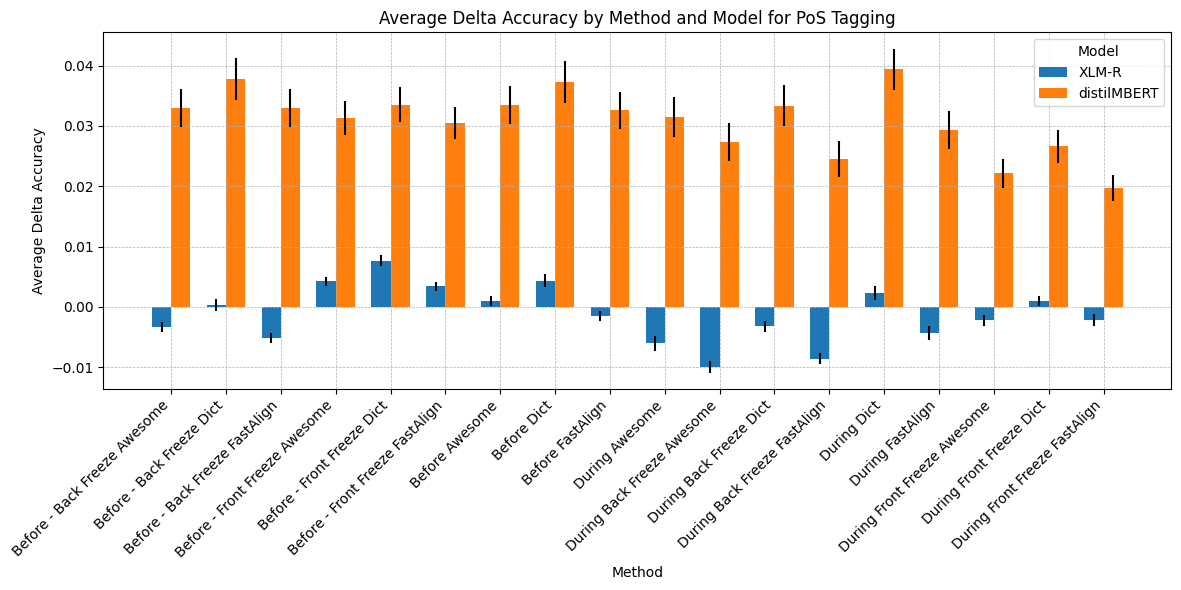

In [21]:
# Calculate average and standard error of delta accuracy grouped by method and model
average_delta_accuracy = combined_df.groupby(['model', 'method'])['delta_accuracy'].agg(['mean', 'sem']).reset_index()

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors for each model
model_colors = {'XLM-R': '#1f77b4', 'distilMBERT': '#ff7f0e'}

# Create a multi-level index for the x-axis
x = list(average_delta_accuracy['method'].unique())
num_methods = len(x)
num_models = len(average_delta_accuracy['model'].unique())
x_pos = np.arange(num_methods)
width = 0.35

# Plot bars for each model
for i, model in enumerate(average_delta_accuracy['model'].unique()):
    model_data = average_delta_accuracy[average_delta_accuracy['model'] == model]
    ax.bar(x_pos + i * width, model_data['mean'], width, yerr=model_data['sem'], label=model, color=model_colors[model])

# Set the x-axis tick positions and labels
ax.set_xticks(x_pos + width / 2)
ax.set_xticklabels([method.replace('_', ' ') for method in x], rotation=45, ha='right')

# Set the plot title and labels
ax.set_title('Average Delta Accuracy by Method and Model for PoS Tagging')
ax.set_xlabel('Method')
ax.set_ylabel('Average Delta Accuracy')

# Add a legend
ax.legend(title='Model')

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

def split_train_val_test(combined_data, use_standard_split=False, exclude_languages=False, test_size=0.2, val_size=0.1, random_state=42):
    combined_data = combined_data.drop(columns=['accuracy'])

    if use_standard_split:
        if exclude_languages:
            # Get a list of unique languages
            languages = combined_data['language'].unique()
            # Randomly choose languages to exclude from the training set
            val_test_languages = np.random.choice(languages, size=int(len(languages) * (val_size + test_size)), replace=False)
            val_languages = val_test_languages[:int(len(val_test_languages) * (val_size / (val_size + test_size)))]
            test_languages = val_test_languages[int(len(val_test_languages) * (val_size / (val_size + test_size))):]
            
            # Split data accordingly
            train_data = combined_data[~combined_data['language'].isin(val_test_languages)]
            val_data = combined_data[combined_data['language'].isin(val_languages)]
            test_data = combined_data[combined_data['language'].isin(test_languages)]
        else:
            # Perform a standard train-validation-test split
            train_data, temp_data = train_test_split(combined_data, test_size=(test_size + val_size), random_state=random_state)
            val_data, test_data = train_test_split(temp_data, test_size=(test_size / (test_size + val_size)), random_state=random_state)
    else:
        # Perform the split based on seeds
        seeds = combined_data['seed'].unique()
        if len(seeds) < 5:
            raise ValueError("There should be at least 5 unique seeds in the data.")
        
        train_seeds = seeds[:3]
        val_seed = seeds[3]
        test_seed = seeds[4]
        
        train_data = combined_data[combined_data['seed'].isin(train_seeds)]
        val_data = combined_data[combined_data['seed'] == val_seed]
        test_data = combined_data[combined_data['seed'] == test_seed]
    
    train_data = train_data.drop(columns=['seed'])
    val_data = val_data.drop(columns=['seed'])
    test_data = test_data.drop(columns=['seed'])
    
    return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

train_data, val_data, test_data = split_train_val_test(combined_df, use_standard_split=True, exclude_languages=True)

train_data


model                        method    language  delta_accuracy
0           XLM-R              Before FastAlign     English        0.001180
1           XLM-R              Before FastAlign     Average        0.000549
2           XLM-R              Before FastAlign   Afrikaans        0.002683
3           XLM-R              Before FastAlign   Bulgarian        0.004515
4           XLM-R              Before FastAlign     Catalan        0.000534
...           ...                           ...         ...             ...
4675  distilMBERT   During Front Freeze Awesome  Vietnamese        0.004935
4676  distilMBERT      During Front Freeze Dict  Vietnamese        0.011041
4677  distilMBERT  During Back Freeze FastAlign  Vietnamese       -0.013969
4678  distilMBERT    During Back Freeze Awesome  Vietnamese       -0.010874
4679  distilMBERT       During Back Freeze Dict  Vietnamese        0.006859

[4680 rows x 4 columns]

In [23]:
val_data

model                        method language  delta_accuracy
0          XLM-R              Before FastAlign   Arabic        0.044768
1          XLM-R              Before FastAlign  Spanish        0.002527
2          XLM-R              Before FastAlign  Turkish       -0.012538
3          XLM-R              Before FastAlign   Arabic        0.011969
4          XLM-R              Before FastAlign  Spanish       -0.001549
..           ...                           ...      ...             ...
535  distilMBERT   During Front Freeze Awesome  Turkish        0.013466
536  distilMBERT      During Front Freeze Dict  Turkish        0.020606
537  distilMBERT  During Back Freeze FastAlign  Turkish        0.008649
538  distilMBERT    During Back Freeze Awesome  Turkish        0.007720
539  distilMBERT       During Back Freeze Dict  Turkish        0.006385

[540 rows x 4 columns]

In [24]:
test_data

model                        method   language  delta_accuracy
0           XLM-R              Before FastAlign      Czech        0.016238
1           XLM-R              Before FastAlign     Danish       -0.001197
2           XLM-R              Before FastAlign    Persian       -0.021532
3           XLM-R              Before FastAlign      Hindi        0.013999
4           XLM-R              Before FastAlign    Latvian       -0.001168
...           ...                           ...        ...             ...
1255  distilMBERT   During Front Freeze Awesome  Slovenian        0.027064
1256  distilMBERT      During Front Freeze Dict  Slovenian        0.034948
1257  distilMBERT  During Back Freeze FastAlign  Slovenian        0.029905
1258  distilMBERT    During Back Freeze Awesome  Slovenian        0.029550
1259  distilMBERT       During Back Freeze Dict  Slovenian        0.038571

[1260 rows x 4 columns]

In [25]:
def plot_loss_curve(errors, save_path=None, start=1, end=None, title=""):
    if end is None:
        end = len(errors)
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, end + 1), errors[start - 1:end], marker='o')
    plt.title(f'Model Loss Over Time - {title}')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    if save_path:
        plt.savefig(os.path.join(save_path, f'loss_curve_{title.replace(" ", "_")}.png'))
    else:
        plt.show()
    plt.close()

In [26]:
def calculate_shap_values(explainer, X, approximate=False):
    return explainer.shap_values(X, approximate=approximate)

In [27]:
def plot_shap_summary(model, X, save_path=None, title="", use_linear_regressor=False):
    if use_linear_regressor:
        explainer = shap.LinearExplainer(model, X, feature_perturbation="correlation_dependent")
        shap_values = explainer.shap_values(X)
    else:
        explainer = shap.TreeExplainer(model)
        # Use Parallel processing to speed up SHAP value calculation
        n_jobs = -1  # Use all available CPU cores
        shap_values = Parallel(n_jobs=n_jobs, backend='loky')(
            delayed(calculate_shap_values)(explainer, X.iloc[i:i+1], approximate=False)
            for i in tqdm(range(X.shape[0]), desc="Calculating SHAP values")
        )
        shap_values = np.vstack(shap_values)
    
    # Rename columns for better readability
    X_renamed = X.copy()
    X_renamed.columns = [
        col.replace('_', ' ').title()
        if col.startswith("language") else
        f"Distance {col.replace('_', ' ').title()}"
        if col in ["inventory", "featural", "syntactic", "geographic", "phonological", "genetic"] else
        f"Method {method_names.get(col.removeprefix('method_'), col.removeprefix('method_')).replace('_', ' ').title()}"
        if col.startswith("method_") else
        col.replace('_', ' ').title()
        for col in X.columns
    ]
    
    plt.figure()
    shap.summary_plot(shap_values, X_renamed, show=False)
    if save_path:
        plt.savefig(os.path.join(save_path, 'shap_summary.png'))
    else:
        plt.show()
    plt.close()

In [28]:
def plot_feature_importances(coefficients, encoded_columns, group_by_distance=False, title=""):
    # Helper function to remove prefix from text
    def remove_prefix(text, prefix):
        if text.startswith(prefix):
            return text[len(prefix):]
        return text

    def titleize_distances(text):
        if text in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']:
            return text.title()
        return text

    importances_df = pd.DataFrame({'Feature': encoded_columns, 'Importance': coefficients})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)
    
    if group_by_distance:
        importances_df['Group'] = importances_df['Feature'].apply(
            lambda x: 'Distance' if any(prefix in x for prefix in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']) 
            else ('Method' if 'method' in x 
            else ('Language' if 'language' in x 
            else 'Model'))
        )
    else:
        importances_df['Group'] = importances_df['Feature'].apply(
            lambda x: 'Method' if 'method' in x 
            else ('Language' if 'language' in x 
            else 'Model')
        )
    
    plt.figure(figsize=(12, 10))
    sns.set(style="whitegrid")
    ax = sns.barplot(x='Importance', y='Feature', hue='Group', data=importances_df, dodge=False)
    
    # Update y-axis labels to remove prefixes and titleize distances
    new_labels = [titleize_distances(remove_prefix(remove_prefix(remove_prefix(remove_prefix(label.get_text(), 'language_'), 'model_'), 'method_'), 'distance_')) for label in ax.get_yticklabels()]
    ax.set_yticklabels(new_labels)
    
    plt.title(f'Feature Importances - {title}', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.legend(title='Group', loc='upper right', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [29]:
def plot_actual_vs_predicted(y_true, y_pred, title=""):
    # Calculate R2 score and MSE
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted vs Actual')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values {title}')
    
    # Move the legend to the lower right
    plt.legend(loc='lower right')
    
    # Place the R2 and MSE scores in the top left corner of the plot
    plt.text(0.05, 0.95, f'R²: {r2:.4f}\nMSE: {mse:.4f}', 
             transform=plt.gca().transAxes, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='white'))
    
    plt.grid(True)
    plt.show()

In [30]:
def perform_regression(train_data, val_data, test_data, use_linear_regressor=False, n_estimators=30, save_path=None, title=""):
    # Encode categorical variables
    encoded_train_df = pd.get_dummies(train_data, drop_first=False)
    encoded_val_df = pd.get_dummies(val_data, drop_first=False)
    encoded_test_df = pd.get_dummies(test_data, drop_first=False)
    
    # Ensure the encoded validation and test sets have the same columns as the training set
    encoded_val_df = encoded_val_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    encoded_test_df = encoded_test_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    
    X_train = encoded_train_df.drop('delta_accuracy', axis=1)
    y_train = encoded_train_df['delta_accuracy']
    X_val = encoded_val_df.drop('delta_accuracy', axis=1)
    y_val = encoded_val_df['delta_accuracy']
    X_test = encoded_test_df.drop('delta_accuracy', axis=1)
    y_test = encoded_test_df['delta_accuracy']
    
    if use_linear_regressor:
        regression_model = LinearRegression()
        regression_model.fit(X_train, y_train)
        y_pred = regression_model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_pred)
        print(f"\nValidation MSE for {title} (Linear Regression): {val_mse}")
        
        importances = regression_model.coef_
        coefficients = pd.Series(importances, index=X_train.columns)
        
        # Perform final evaluation on the test set
        y_test_pred = regression_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        print(f"\nFinal Test MSE for {title} (Linear Regression): {test_mse}")
        
        # Calculate and plot SHAP values
        plot_shap_summary(regression_model, X_train, save_path=save_path, title=title, use_linear_regressor=True)
    else:
        regression_model = RandomForestRegressor(n_estimators=1, warm_start=True, random_state=42)
        errors = []
        
        for i in tqdm(range(1, n_estimators + 30)):
            regression_model.n_estimators = i
            regression_model.fit(X_train, y_train)
            y_pred = regression_model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            errors.append(mse)
        
        importances = regression_model.feature_importances_
        coefficients = pd.Series(importances, index=X_train.columns)
        
        # Perform final evaluation on the test set
        y_test_pred = regression_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        print(f"\nFinal Test MSE for {title} (Random Forest): {test_mse}")
        
        # Plot the loss curve
        plot_loss_curve(errors, save_path, title=title)
        
        # Calculate and plot SHAP values
        plot_shap_summary(regression_model, X_train, save_path=save_path, title=title, use_linear_regressor=False)
    
    plot_feature_importances(coefficients, X_train.columns, title=title)
    
    # Plot actual vs. predicted values
    plot_actual_vs_predicted(y_test, y_test_pred, title=title)
    
    return coefficients, X_train.columns

100%|██████████| 59/59 [00:00<00:00, 94.49it/s] 



Final Test MSE for  (Random Forest): 0.000838631466421499


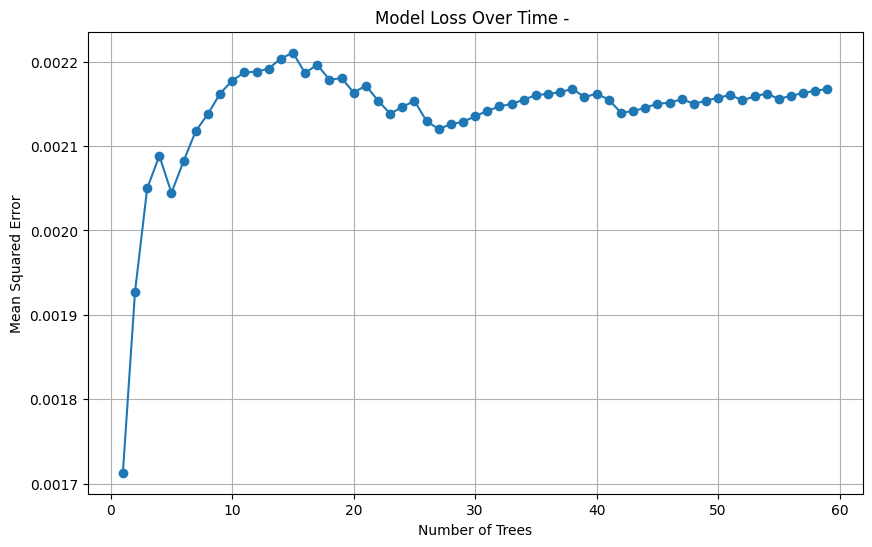

Calculating SHAP values: 100%|██████████| 4680/4680 [01:24<00:00, 55.52it/s]


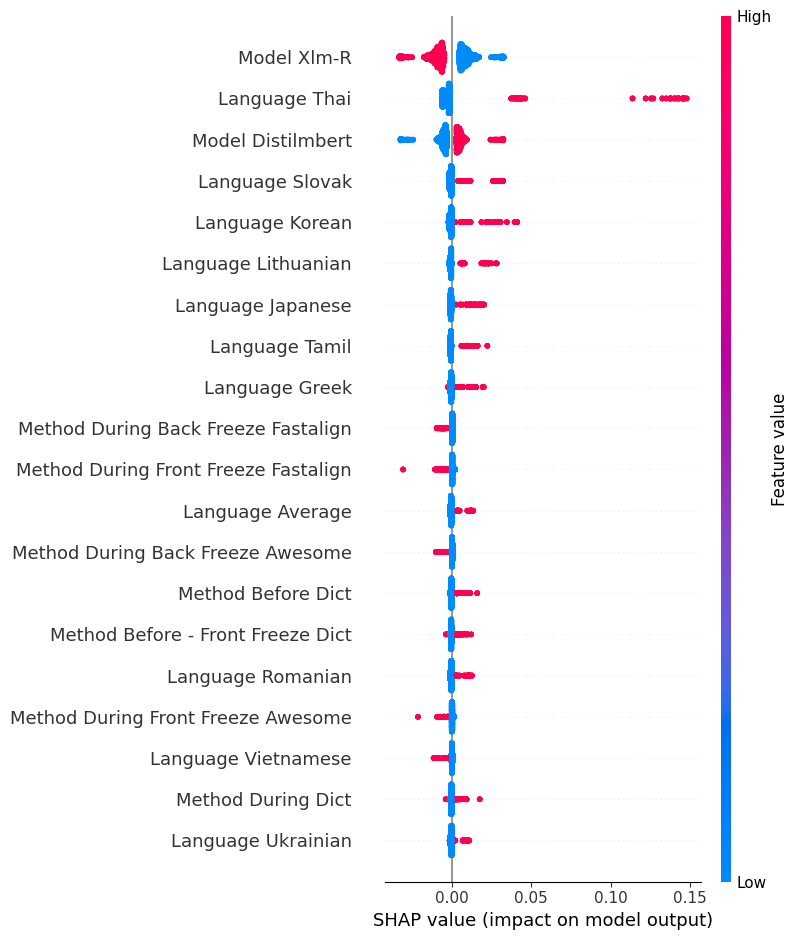

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


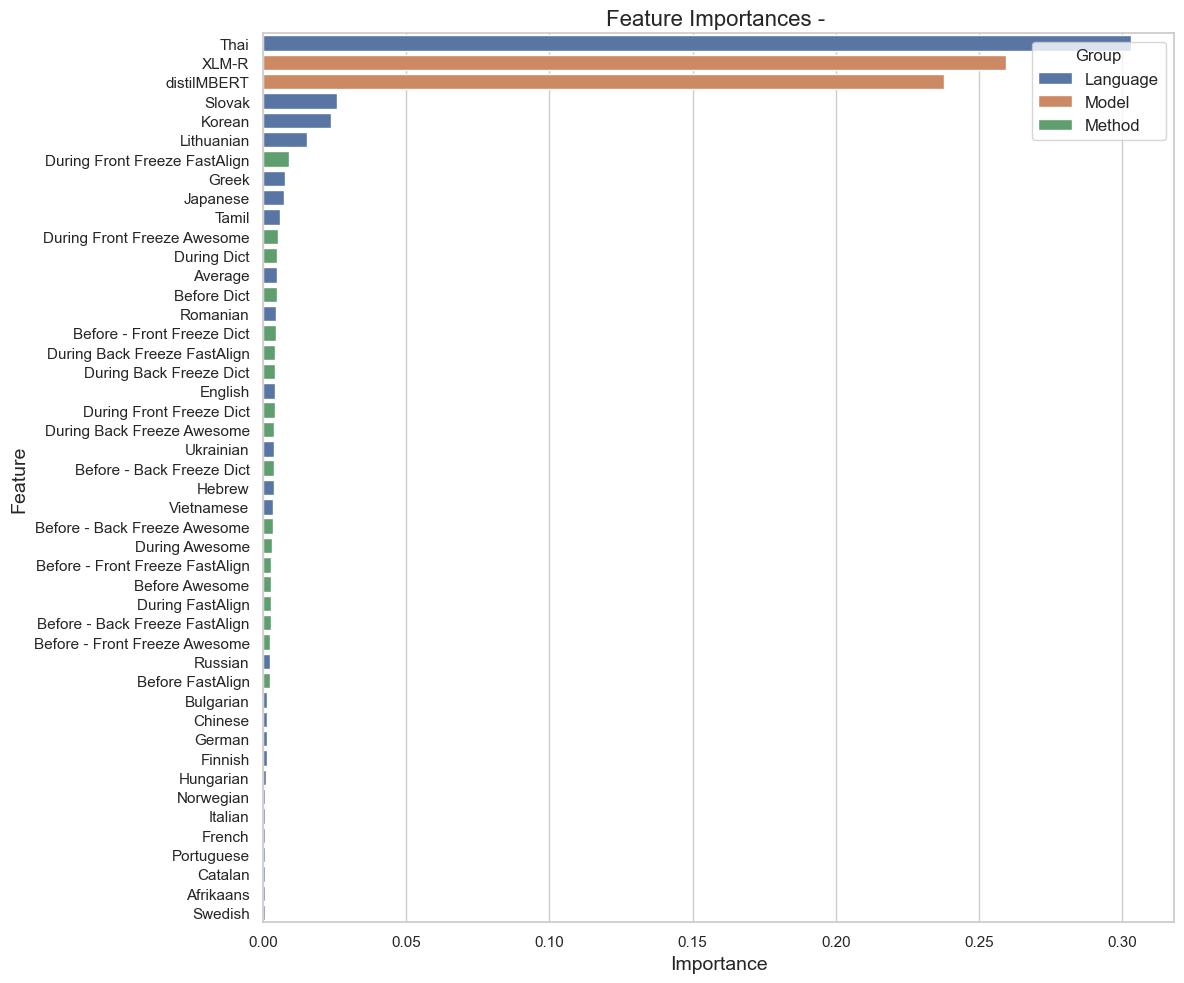

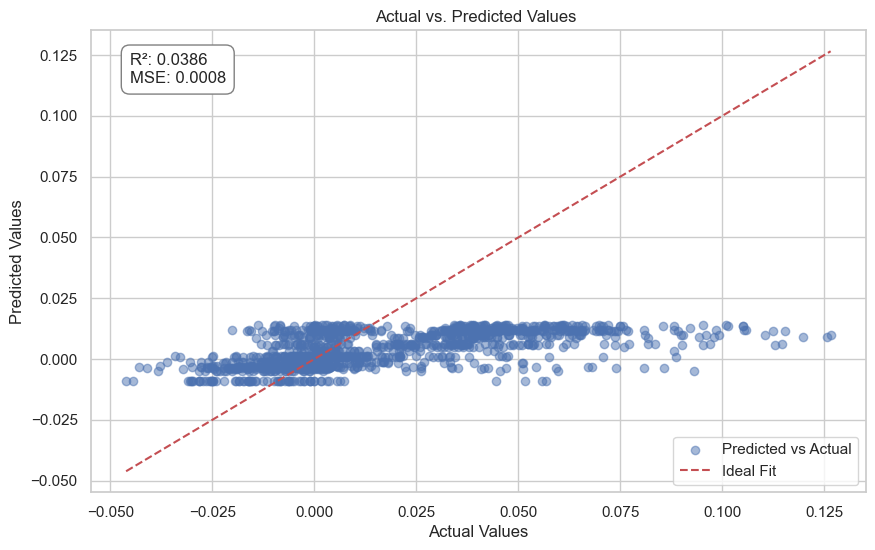

Feature Importances:
model_XLM-R                               0.259362
model_distilMBERT                         0.237768
method_Before - Back Freeze Awesome       0.003396
method_Before - Back Freeze Dict          0.004019
method_Before - Back Freeze FastAlign     0.002799
method_Before - Front Freeze Awesome      0.002617
method_Before - Front Freeze Dict         0.004544
method_Before - Front Freeze FastAlign    0.003001
method_Before Awesome                     0.002933
method_Before Dict                        0.004803
method_Before FastAlign                   0.002482
method_During Awesome                     0.003297
method_During Back Freeze Awesome         0.004041
method_During Back Freeze Dict            0.004149
method_During Back Freeze FastAlign       0.004253
method_During Dict                        0.005095
method_During FastAlign                   0.002923
method_During Front Freeze Awesome        0.005361
method_During Front Freeze Dict           0.004078
method_Dur

In [31]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, use_linear_regressor=False)

print("Feature Importances:")
print(coefficients)

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


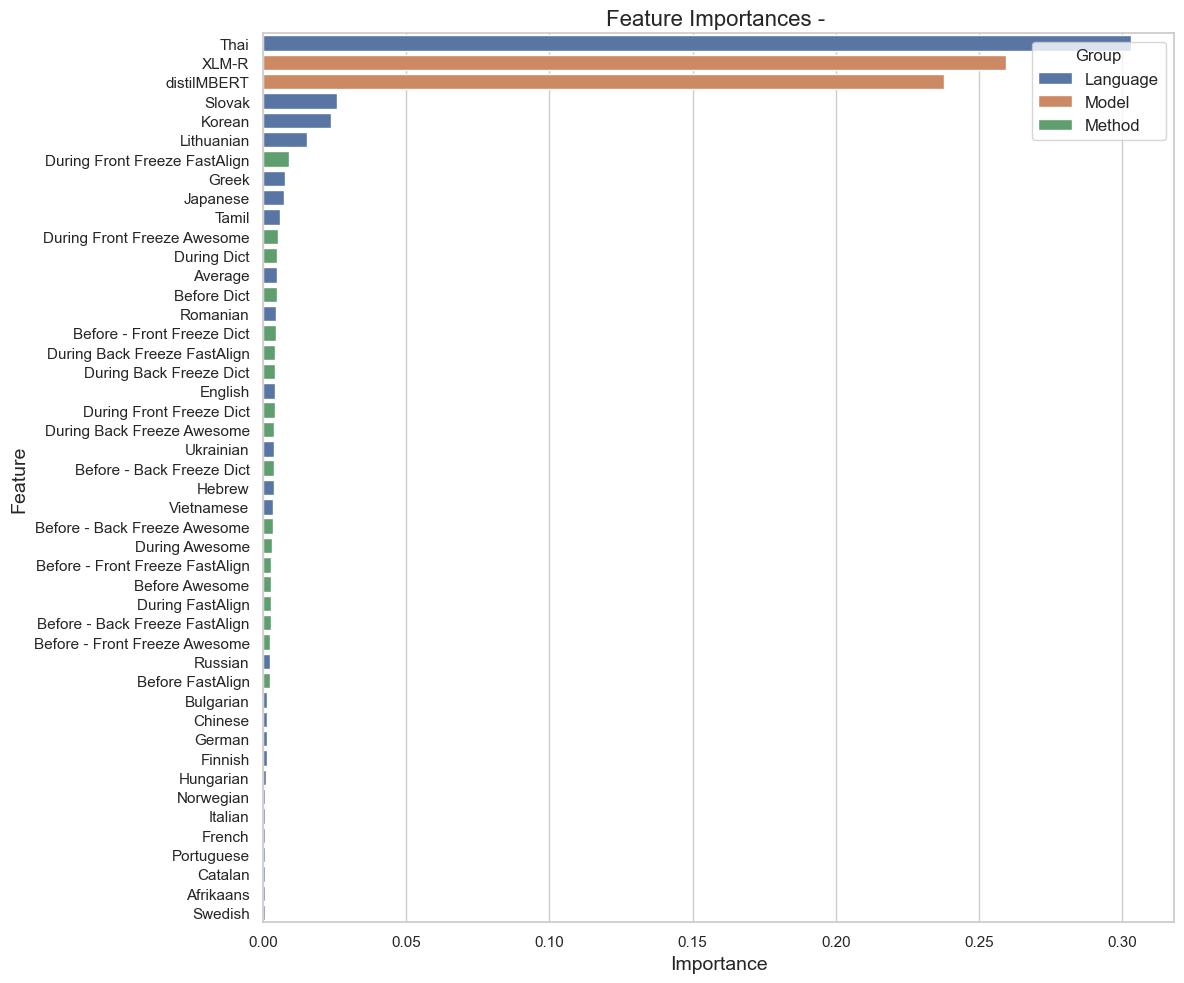

In [32]:
plot_feature_importances(coefficients, encoded_columns)

In [33]:
combined_df_with_distances = add_language_distances_to_df(combined_df)

Error: Average is not in the language mapping.


In [34]:
combined_df_with_distances = combined_df_with_distances[~combined_df_with_distances.isna().any(axis=1)]

In [35]:
train_dist_data, val_dist_data, test_dist_data = split_train_val_test(combined_df_with_distances, use_standard_split=True)

In [36]:
train_dist_data

model                           method    language  \
0     distilMBERT     During Back Freeze FastAlign   Hungarian   
1           XLM-R      During Front Freeze Awesome   Bulgarian   
2           XLM-R         During Front Freeze Dict  Portuguese   
3           XLM-R     During Back Freeze FastAlign     Italian   
4           XLM-R  Before - Front Freeze FastAlign     Finnish   
...           ...                              ...         ...   
4404  distilMBERT     Before - Back Freeze Awesome  Vietnamese   
4405  distilMBERT    Before - Front Freeze Awesome     Finnish   
4406  distilMBERT  Before - Front Freeze FastAlign      German   
4407  distilMBERT       Before - Front Freeze Dict  Lithuanian   
4408        XLM-R                   During Awesome     Latvian   

      delta_accuracy  syntactic  geographic  phonological  genetic  inventory  \
0           0.014451       0.60         0.1        0.3433   1.0000     0.4581   
1           0.001972       0.48         0.1        0.2804   0.8571     0.5210   
2          -0.000920       0.47         0.1        0.5687   0.9000     0.4235   
3          -0.002689       0.51         0.1        0.5687   0.9000     0.5064   
4           0.001138       0.53         0.1        0.2736   1.0000     0.4694   
...              ...        ...         ...           ...      ...        ...   
4404        0.000251       0.57         0.5        0.4270   1.0000     0.4550   
4405        0.029261       0.53         0.1        0.2736   1.0000     0.4694   
4406        0.007214       0.42         0.1        0.3277   0.4286     0.4364   
4407        0.067754       0.68         0.1        0.3498   0.9000     0.4694   
4408       -0.005465       0.59         0.1        0.3433   0.9000     0.5983   

      featural  
0          0.5  
1          0.5  
2          0.5  
3          0.5  
4          0.5  
...        ...  
4404       0.5  
4405       0.5  
4406       0.4  
4407       0.5  
4408       0.7  

[4409 rows x 10 columns]

In [37]:
val_dist_data

model                         method    language  delta_accuracy  \
0    distilMBERT   During Back Freeze FastAlign       Hindi        0.050804   
1    distilMBERT    During Front Freeze Awesome      Slovak        0.049387   
2          XLM-R        During Back Freeze Dict     Turkish       -0.002438   
3          XLM-R     Before - Front Freeze Dict    Romanian        0.002757   
4    distilMBERT  Before - Front Freeze Awesome       Czech        0.059295   
..           ...                            ...         ...             ...   
625  distilMBERT                    Before Dict     Turkish        0.018691   
626        XLM-R               During FastAlign     Catalan        0.001948   
627  distilMBERT                 During Awesome       Czech        0.056740   
628  distilMBERT                 During Awesome   Bulgarian        0.020542   
629        XLM-R   Before - Back Freeze Awesome  Lithuanian        0.000645   

     syntactic  geographic  phonological  genetic  inventory  featural  
0         0.59         0.4        0.3433   0.9000     0.4684       0.5  
1         0.57         0.1        0.5687   0.9000     0.5983       0.6  
2         0.70         0.1        0.3433   1.0000     0.5183       0.6  
3         0.53         0.1        0.3498   0.9000     0.4997       0.5  
4         0.66         0.1        0.5687   0.9000     0.5368       0.6  
..         ...         ...           ...      ...        ...       ...  
625       0.70         0.1        0.3433   1.0000     0.5183       0.6  
626       0.53         0.1        0.2804   0.9000     0.4581       0.5  
627       0.66         0.1        0.5687   0.9000     0.5368       0.6  
628       0.48         0.1        0.2804   0.8571     0.5210       0.5  
629       0.68         0.1        0.3498   0.9000     0.4694       0.5  

[630 rows x 10 columns]

In [38]:
test_dist_data

model                          method   language  delta_accuracy  \
0     distilMBERT    Before - Back Freeze Awesome    English        0.001455   
1           XLM-R                     During Dict    Catalan       -0.003775   
2     distilMBERT                     During Dict    Persian        0.017848   
3           XLM-R        During Front Freeze Dict    Chinese        0.002248   
4     distilMBERT   Before - Front Freeze Awesome  Afrikaans        0.011227   
...           ...                             ...        ...             ...   
1256  distilMBERT  Before - Back Freeze FastAlign  Norwegian        0.008410   
1257        XLM-R                Before FastAlign     Danish       -0.003791   
1258  distilMBERT      During Back Freeze Awesome   Japanese        0.017108   
1259        XLM-R    Before - Back Freeze Awesome     Korean       -0.017813   
1260        XLM-R    Before - Back Freeze Awesome     German        0.001192   

      syntactic  geographic  phonological  genetic  inventory  featural  
0          0.00         0.0        0.0002   0.0000     0.0000       0.0  
1          0.53         0.1        0.2804   0.9000     0.4581       0.5  
2          0.57         1.0        0.5687   1.0000     0.5983       0.6  
3          0.55         0.4        0.3900   1.0000     0.5926       0.6  
4          0.63         0.4        0.5687   0.6000     0.5144       0.6  
...         ...         ...           ...      ...        ...       ...  
1256       0.52         0.1        0.4477   1.0000     0.4769       0.5  
1257       0.50         0.0        0.5687   0.7000     0.5983       0.7  
1258       0.66         0.5        0.5032   1.0000     0.5472       0.6  
1259       0.62         0.4        0.4638   1.0000     0.4866       0.5  
1260       0.42         0.1        0.3277   0.4286     0.4364       0.4  

[1261 rows x 10 columns]

100%|██████████| 59/59 [00:00<00:00, 75.89it/s]



Final Test MSE for  (Random Forest): 0.00022045082291291982


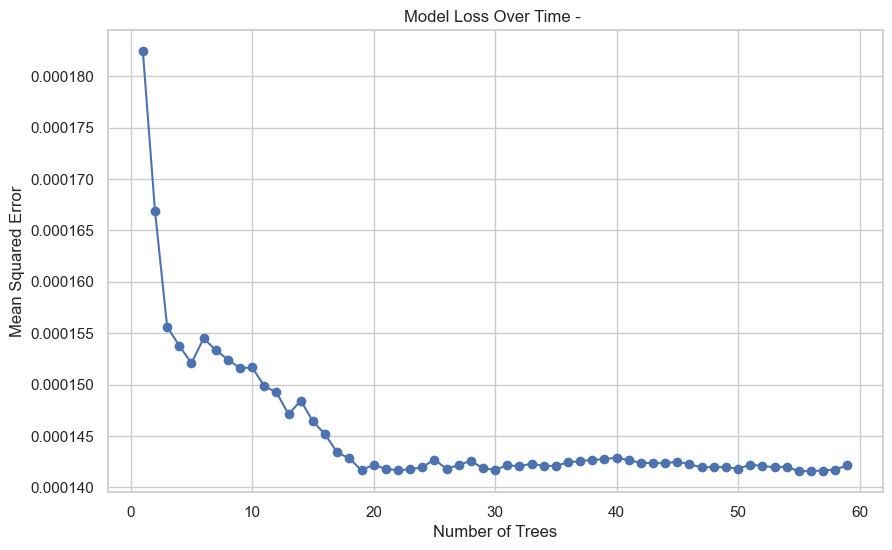

Calculating SHAP values: 100%|██████████| 4409/4409 [00:33<00:00, 131.45it/s]


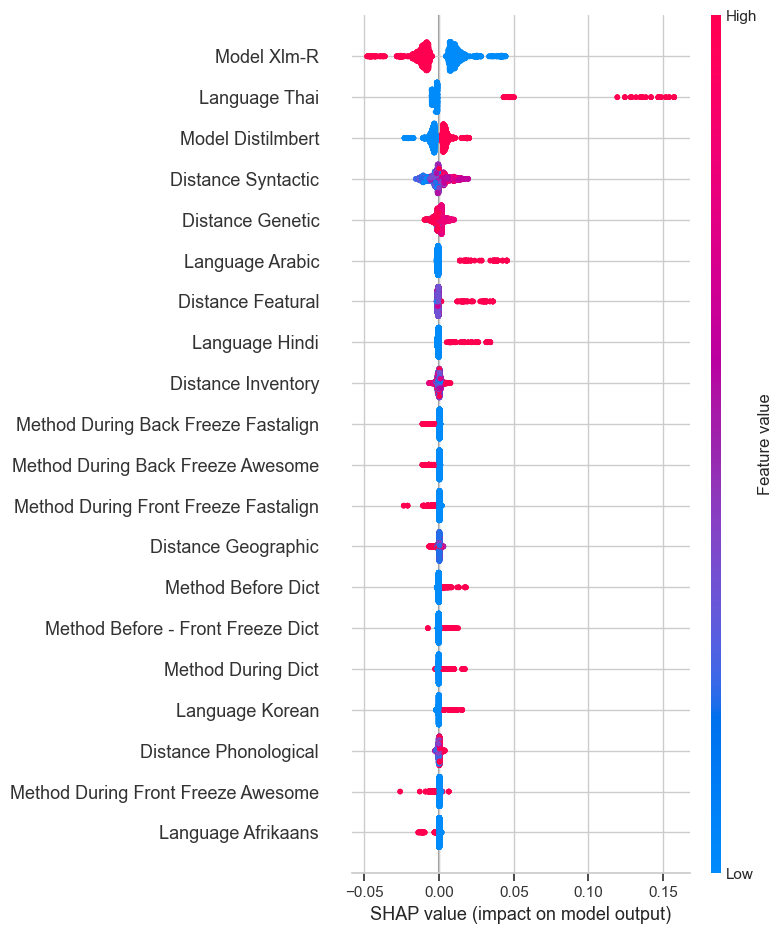

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


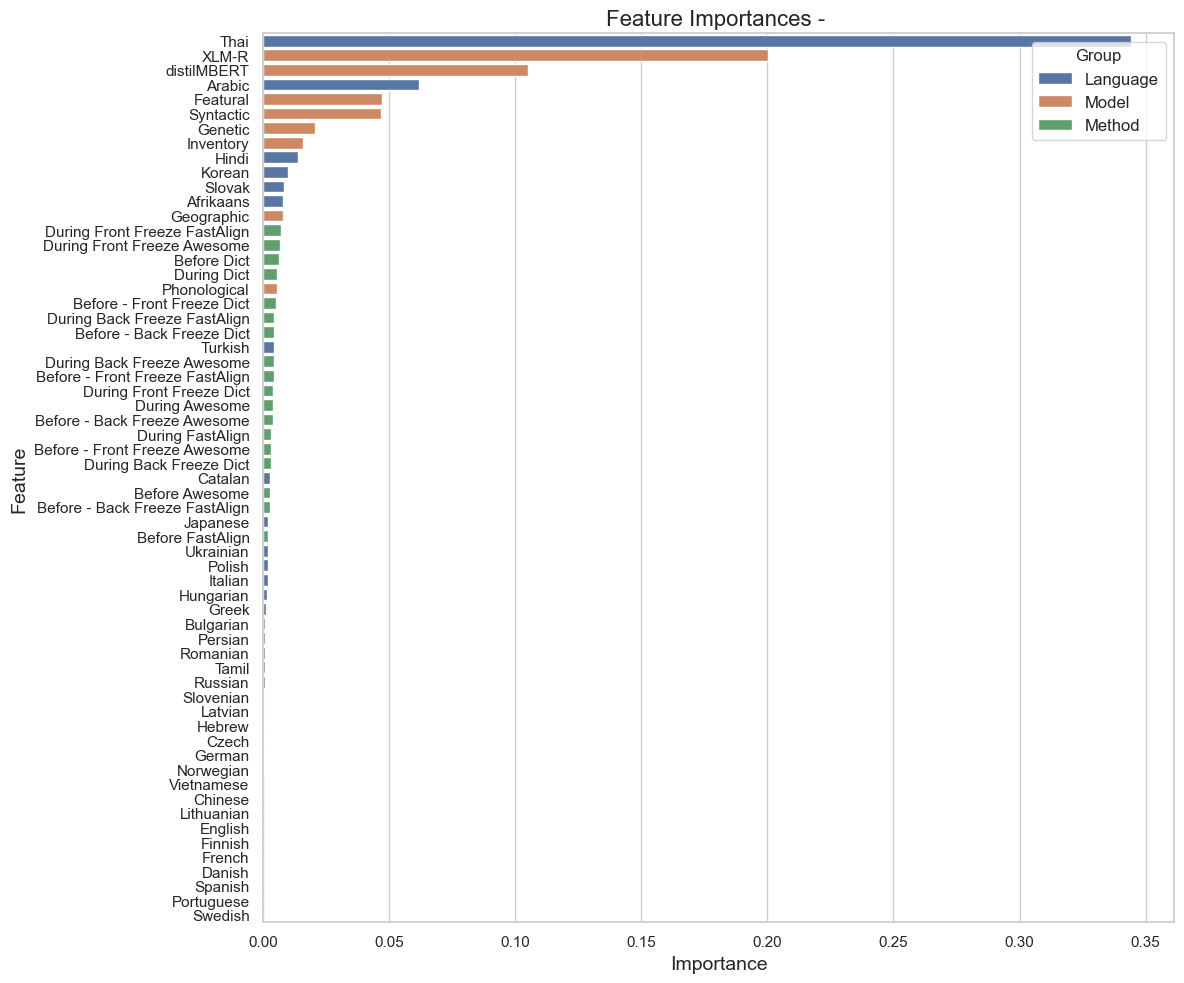

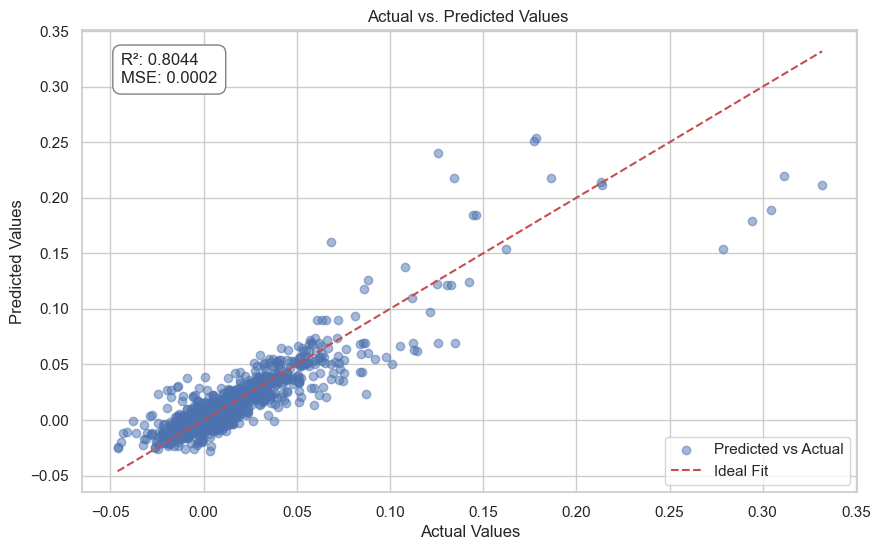

Feature Importances:
syntactic              0.046840
geographic             0.007807
phonological           0.005548
genetic                0.020677
inventory              0.015908
                         ...   
language_Tamil         0.000756
language_Thai          0.344022
language_Turkish       0.004385
language_Ukrainian     0.002069
language_Vietnamese    0.000233
Length: 61, dtype: float64


In [39]:
dist_coefficients, dist_encoded_columns = perform_regression(train_dist_data, val_dist_data, test_dist_data)

print("Feature Importances:")
print(dist_coefficients)

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


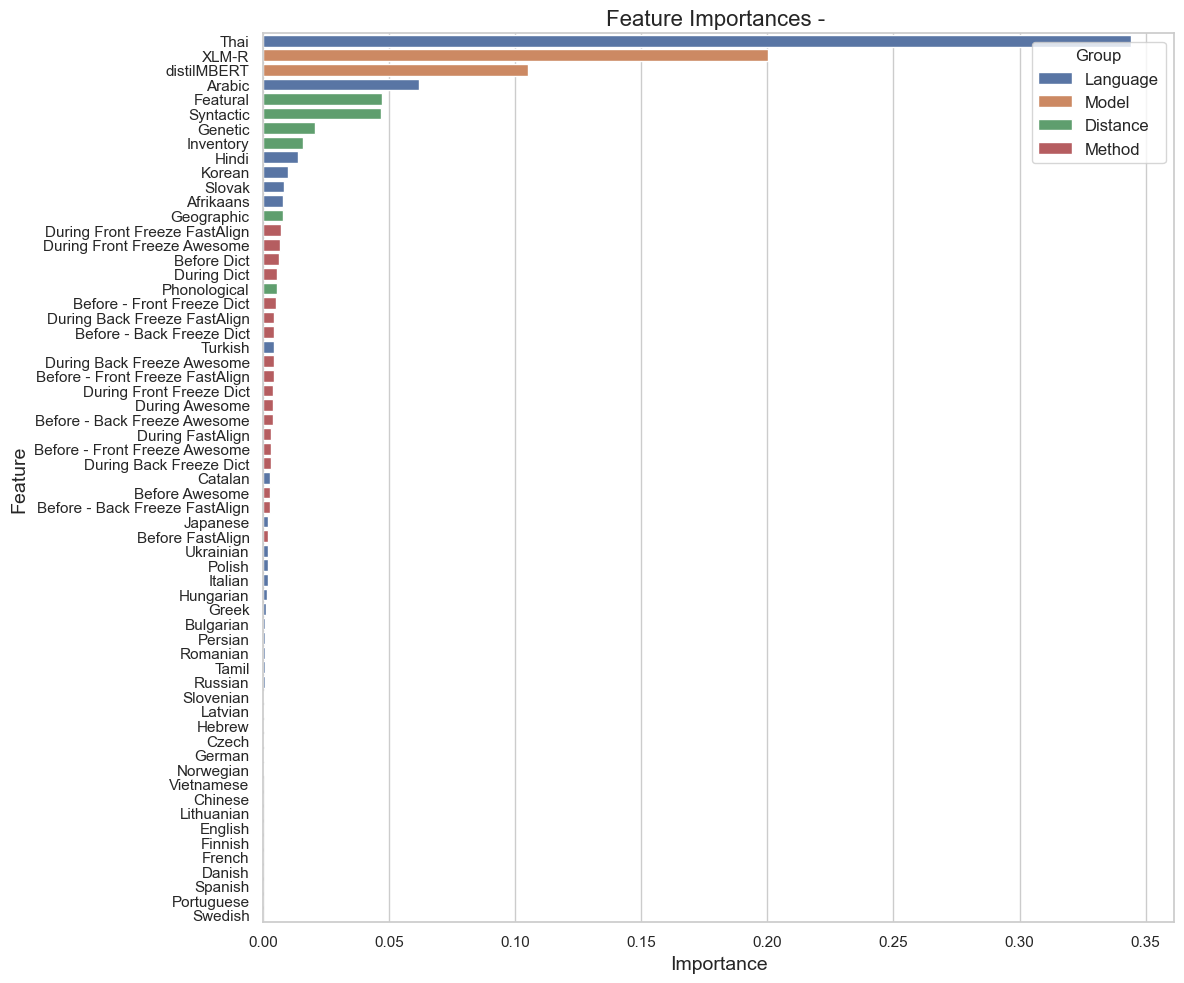

In [40]:
plot_feature_importances(dist_coefficients, dist_encoded_columns, group_by_distance=True)

In [41]:
def flag_freeze_methods(df, method_col='method'):
    df['method_type'] = df[method_col].apply(lambda x: 'freeze' if 'freeze' in x.lower() else 'vanilla')
    return df

In [42]:
combined_df_with_flags = flag_freeze_methods(combined_df)
combined_df_with_flags = combined_df_with_flags[~combined_df_with_flags.isna().any(axis=1)]

Using all data



100%|██████████| 59/59 [00:00<00:00, 73.73it/s]


Final Test MSE for Using all data (Random Forest): 0.00022045082291291982


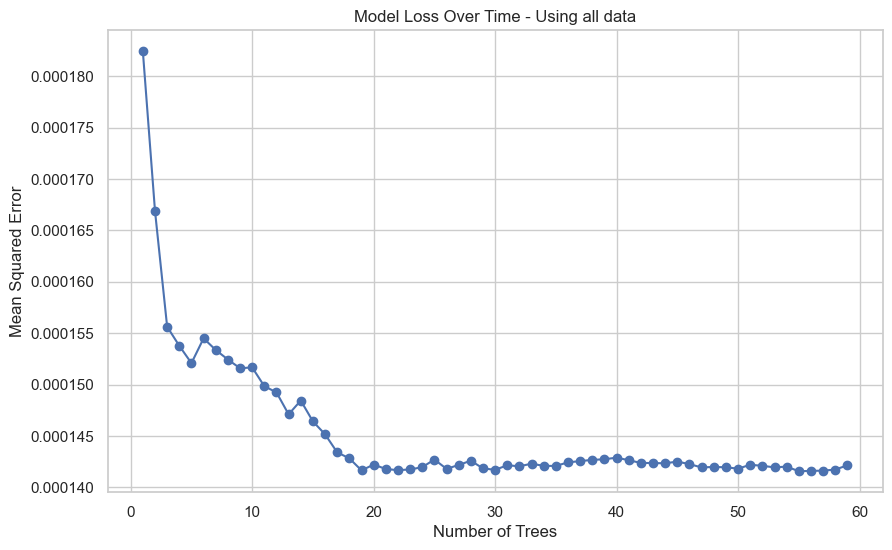

Calculating SHAP values: 100%|██████████| 4409/4409 [00:34<00:00, 128.38it/s]


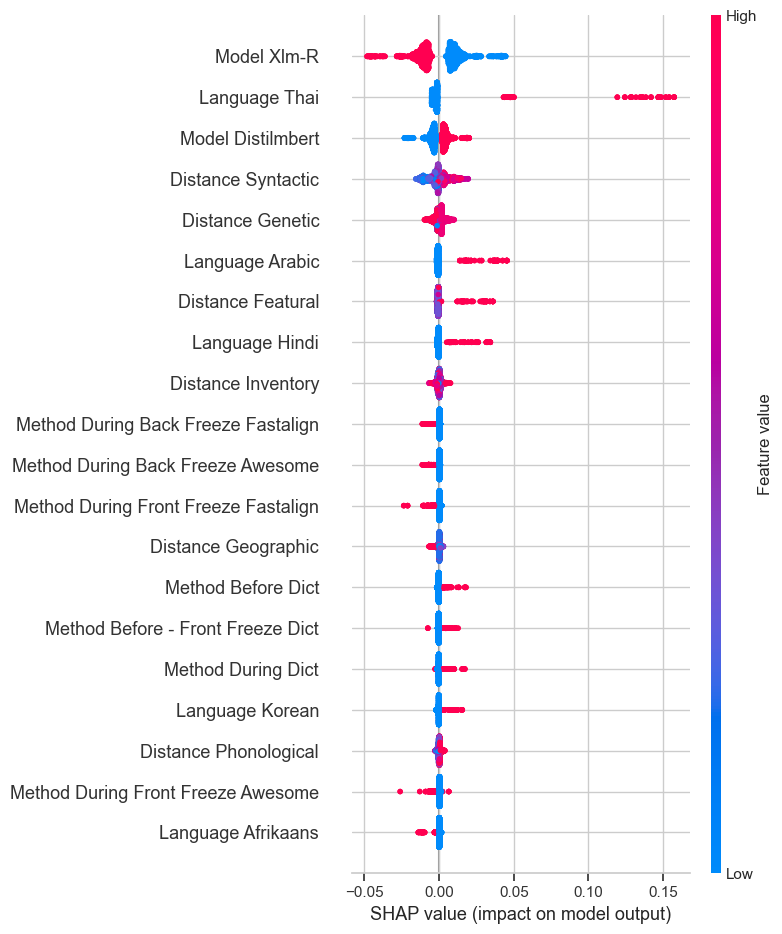

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


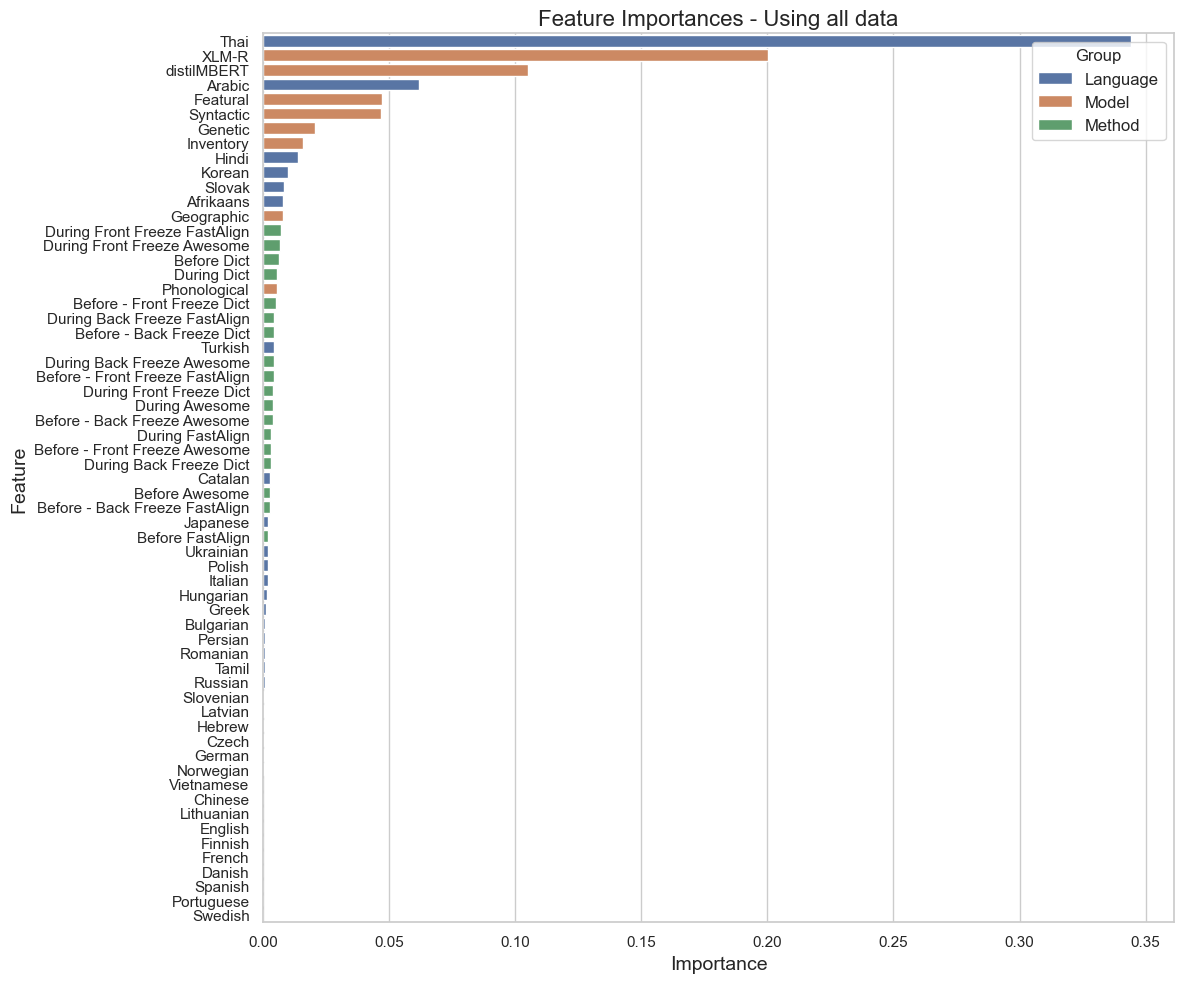

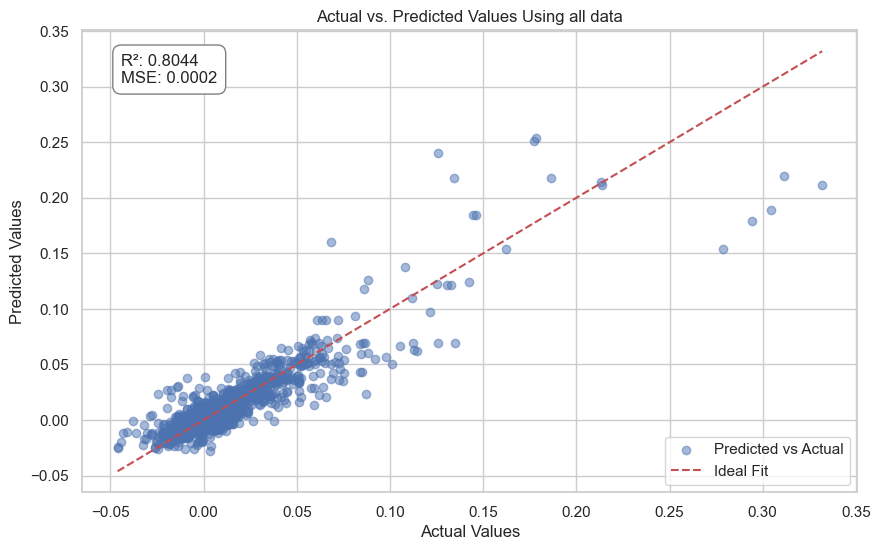

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


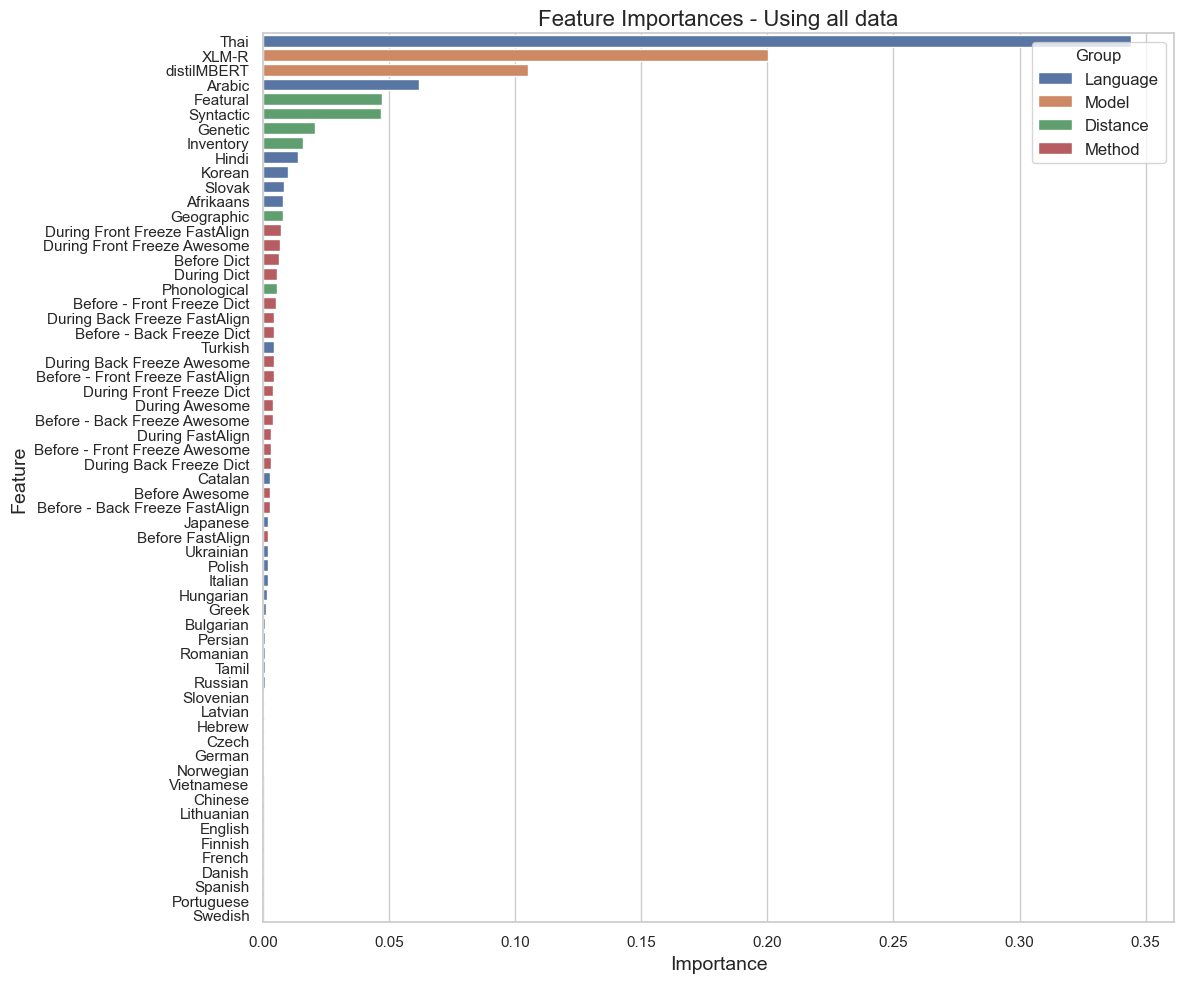

Using freeze methods only



100%|██████████| 59/59 [00:00<00:00, 99.70it/s] 



Final Test MSE for Using freeze methods only (Random Forest): 0.00024158399151330665


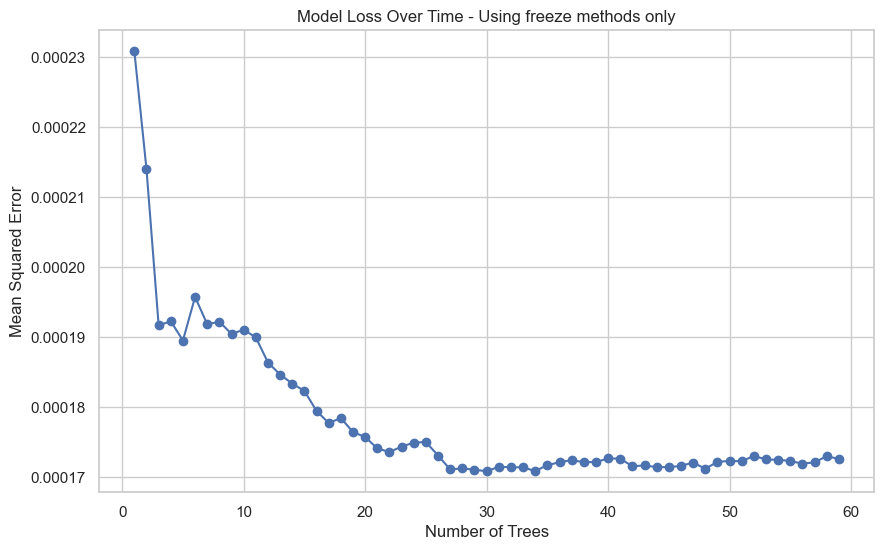

Calculating SHAP values: 100%|██████████| 2939/2939 [00:19<00:00, 153.95it/s]


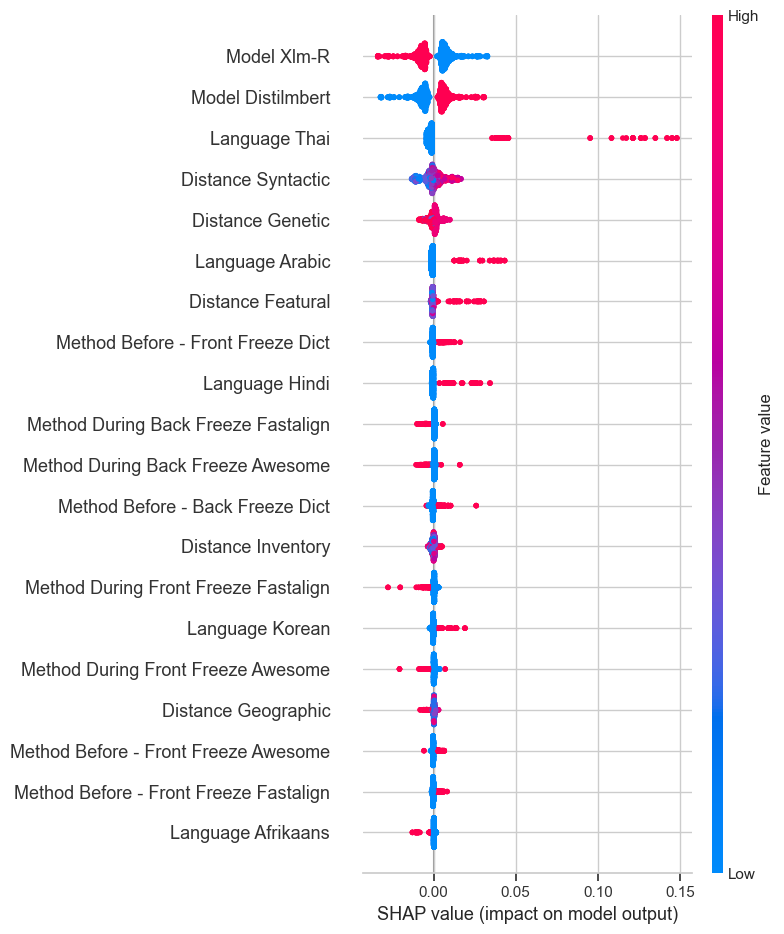

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


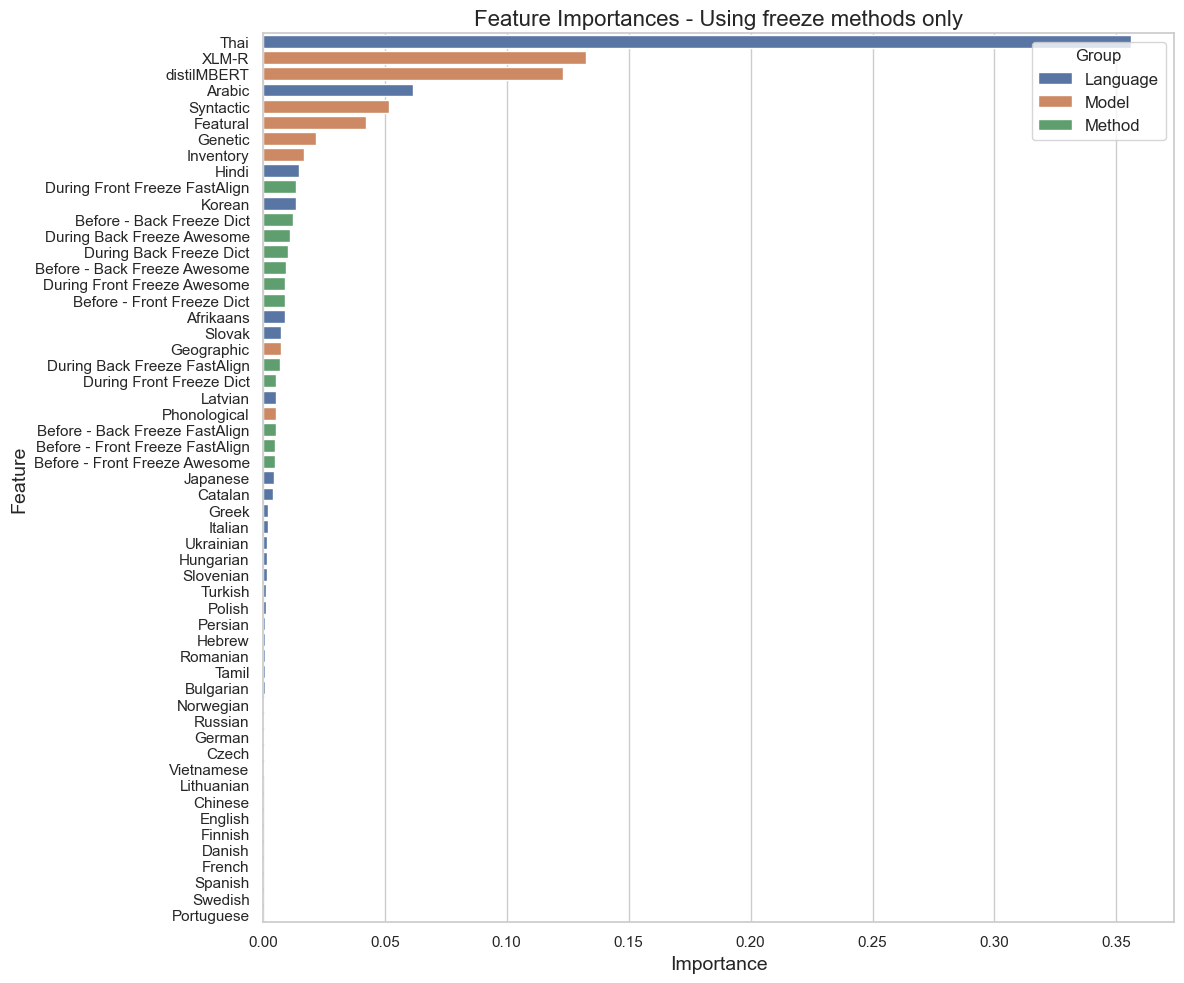

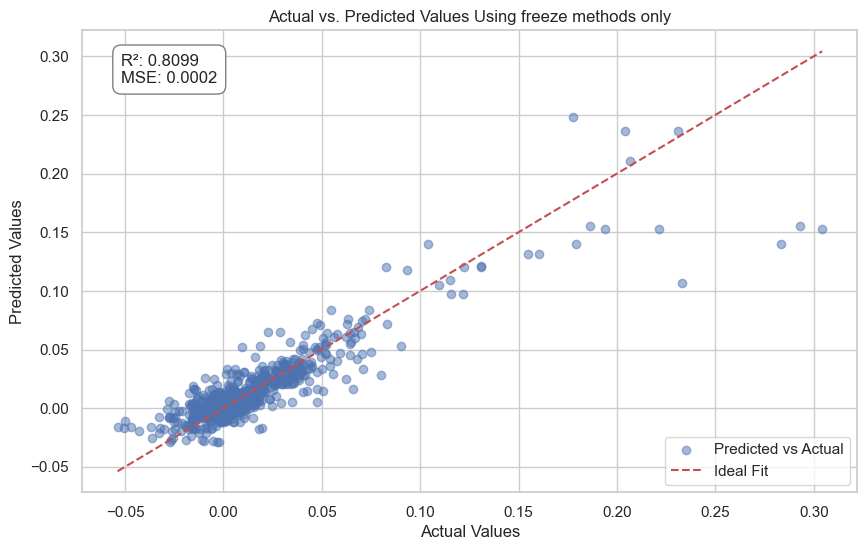

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


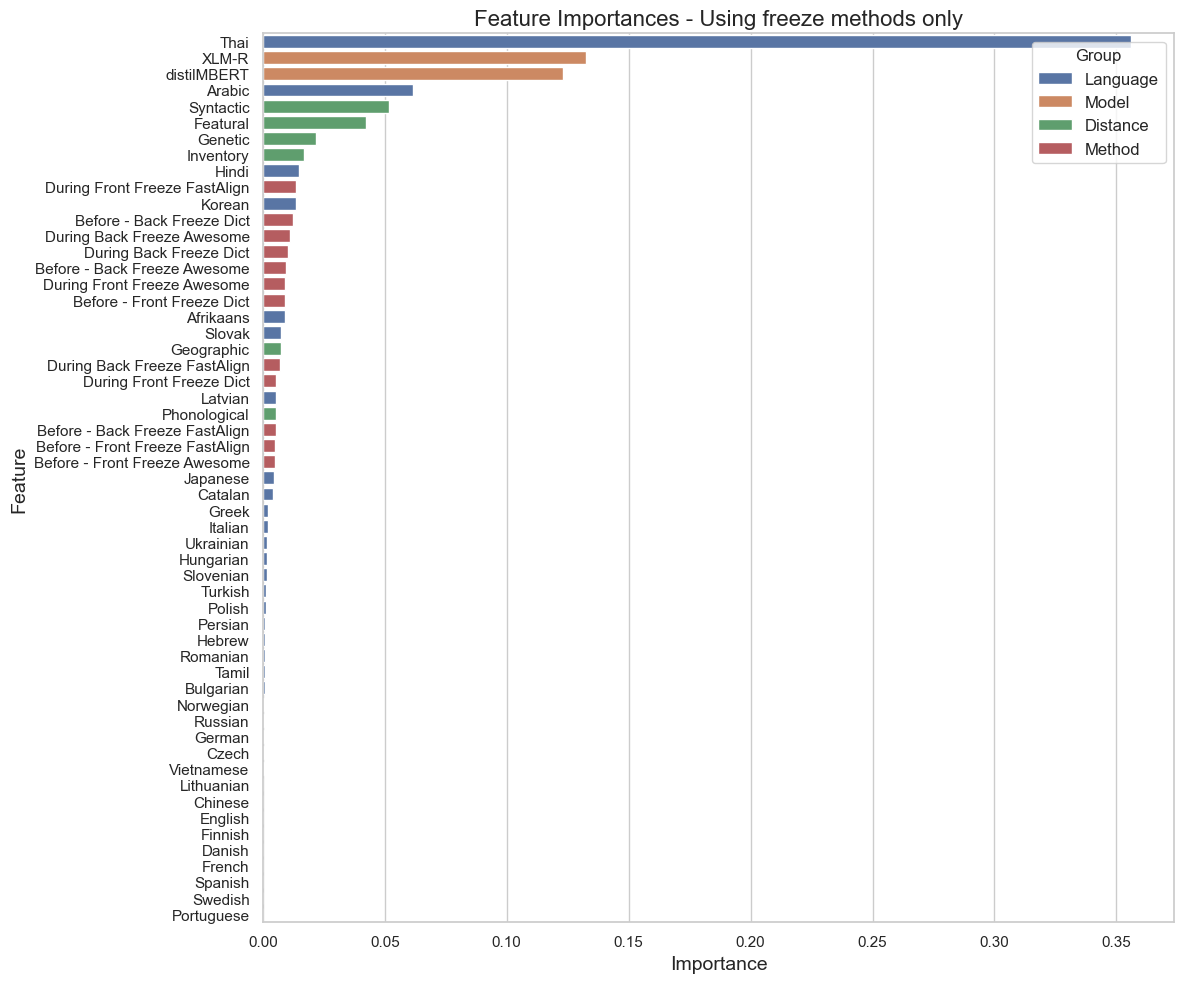

Using vanilla methods only



100%|██████████| 59/59 [00:00<00:00, 178.87it/s]


Final Test MSE for Using vanilla methods only (Random Forest): 0.00019754895452234848


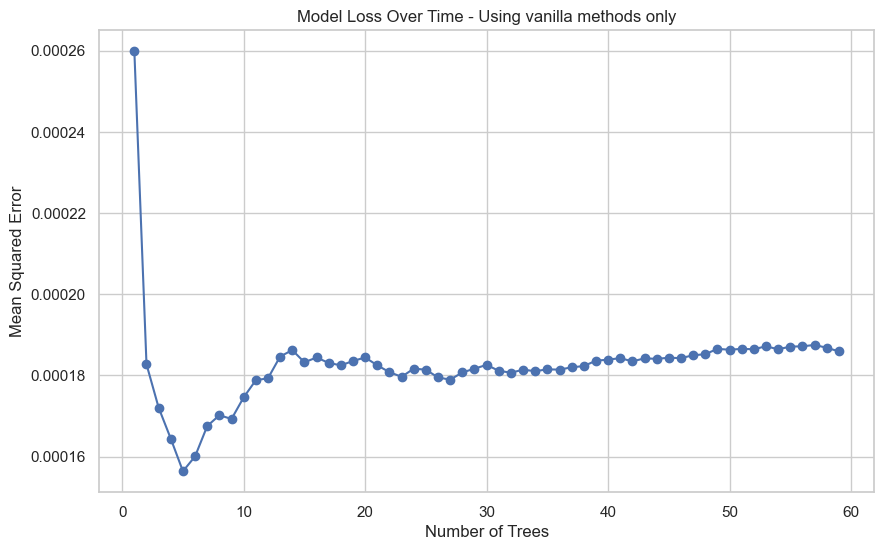

Calculating SHAP values: 100%|██████████| 1469/1469 [00:05<00:00, 252.37it/s]


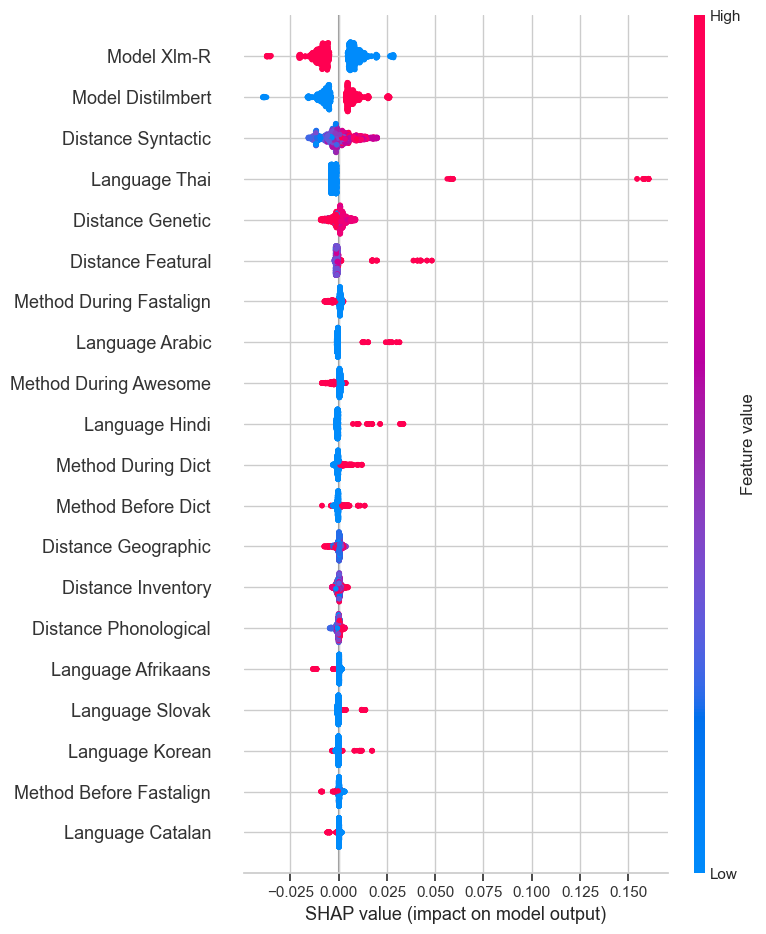

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


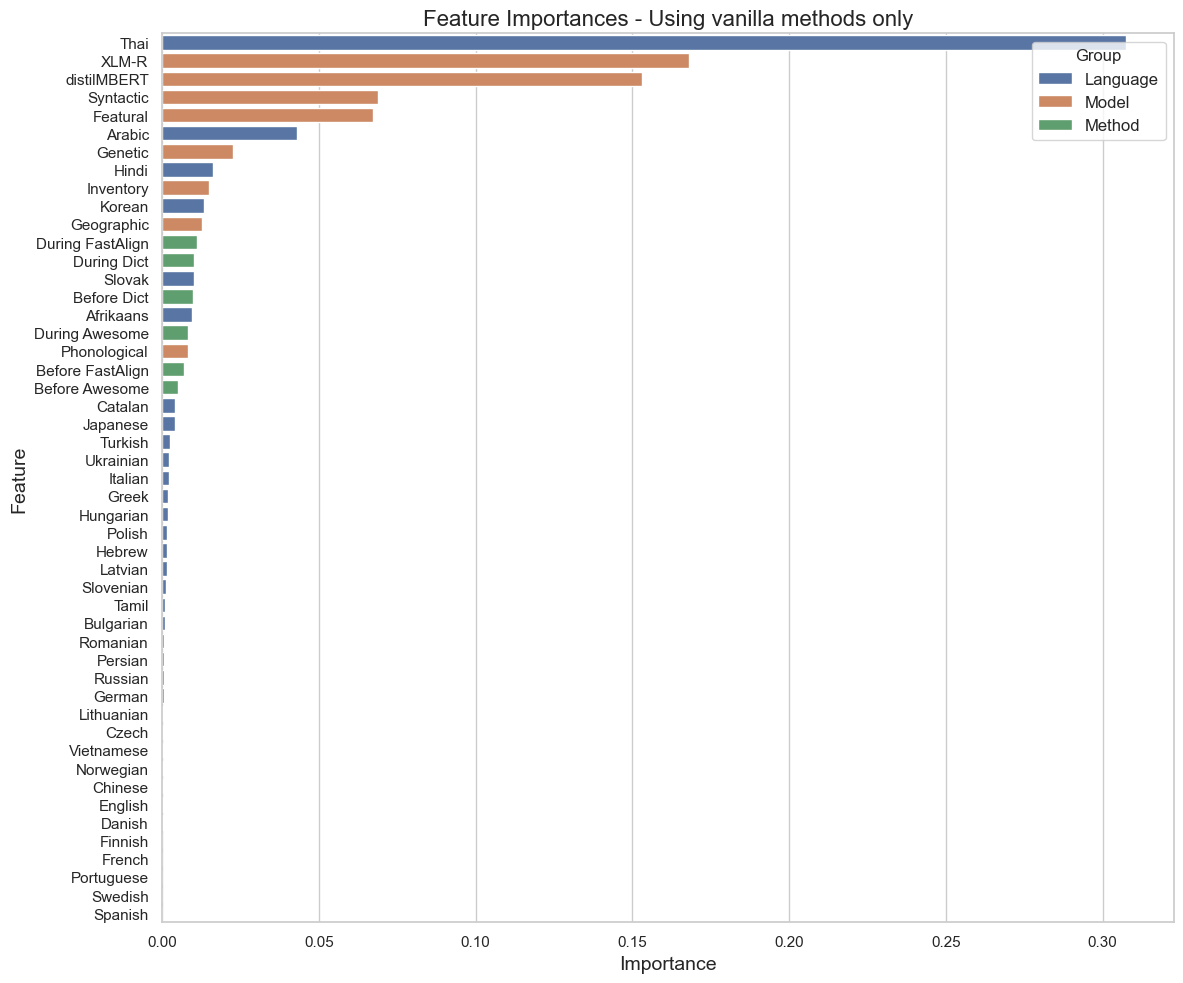

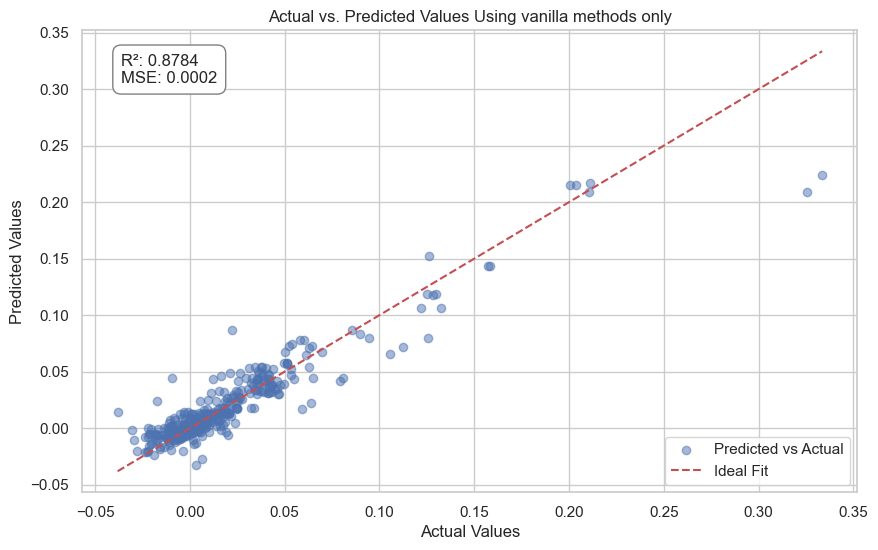

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


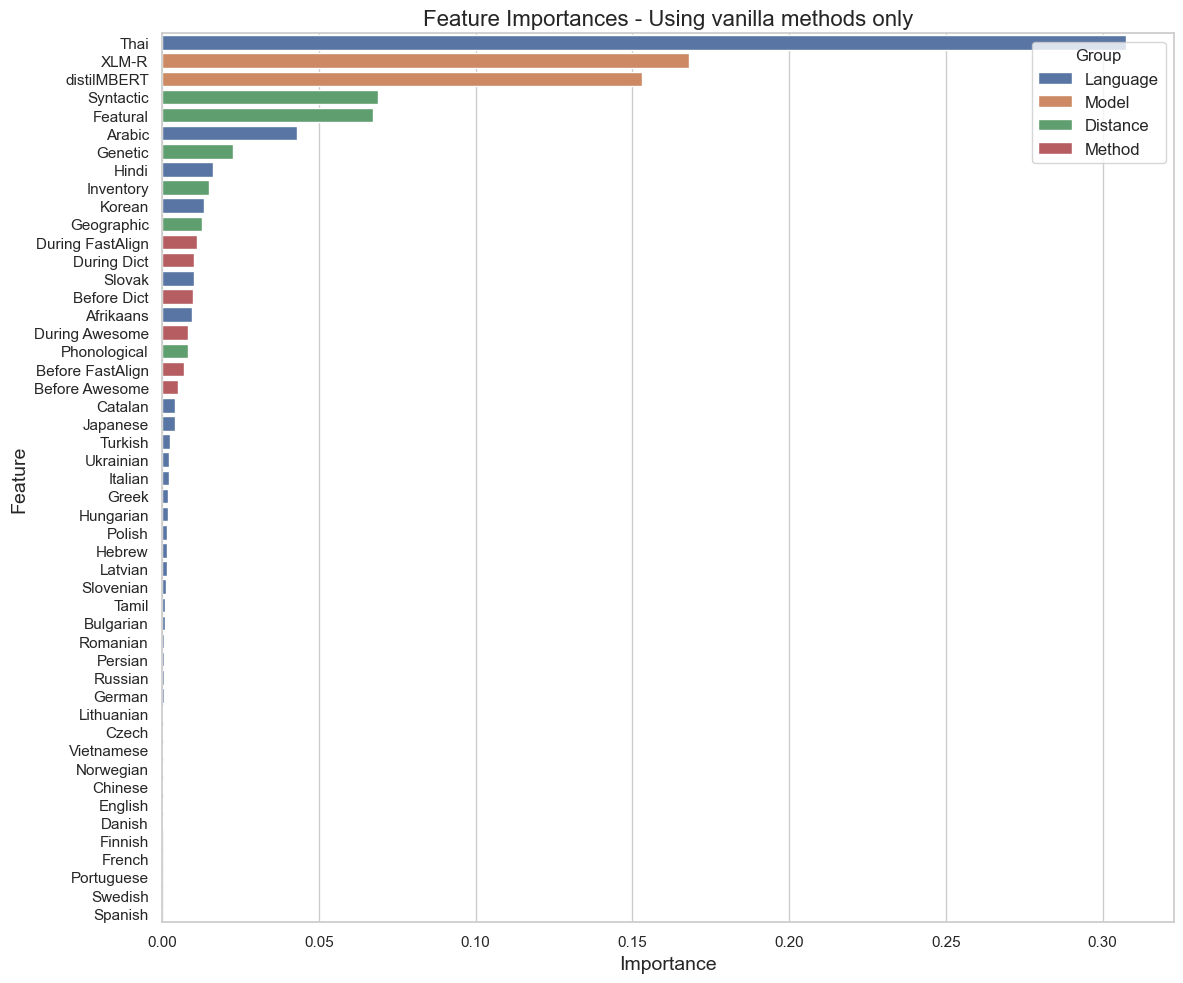

Using XLM-R only



100%|██████████| 59/59 [00:00<00:00, 120.36it/s]



Final Test MSE for Using XLM-R only (Random Forest): 0.0001297403667946792


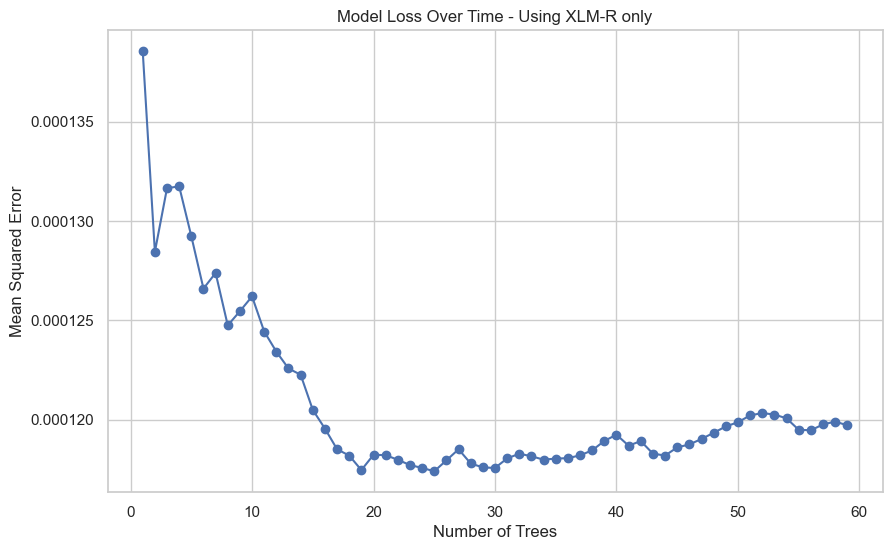

Calculating SHAP values: 100%|██████████| 2204/2204 [00:11<00:00, 187.53it/s]


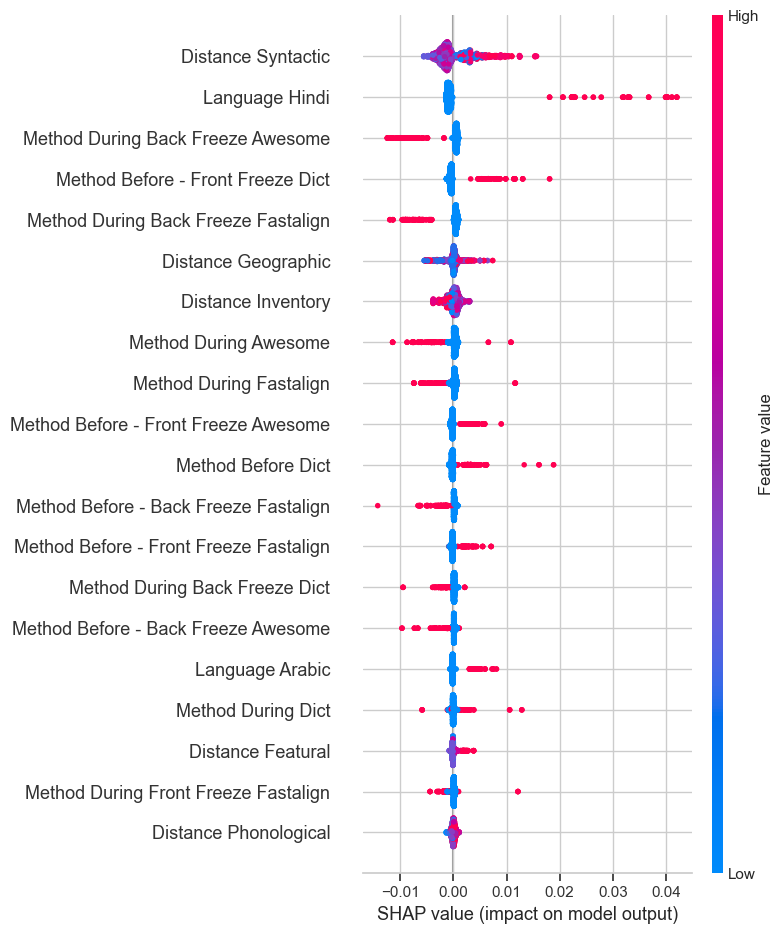

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


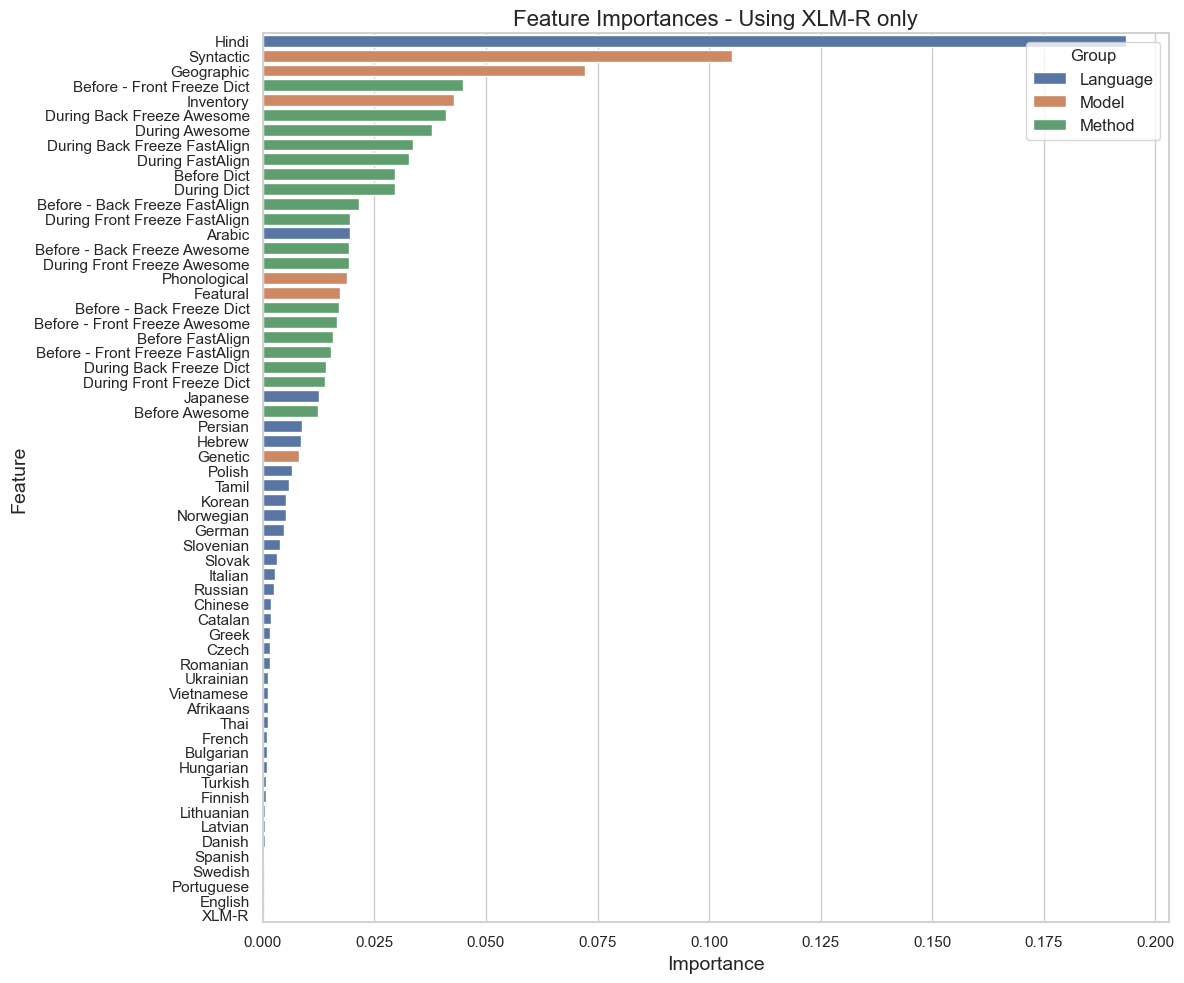

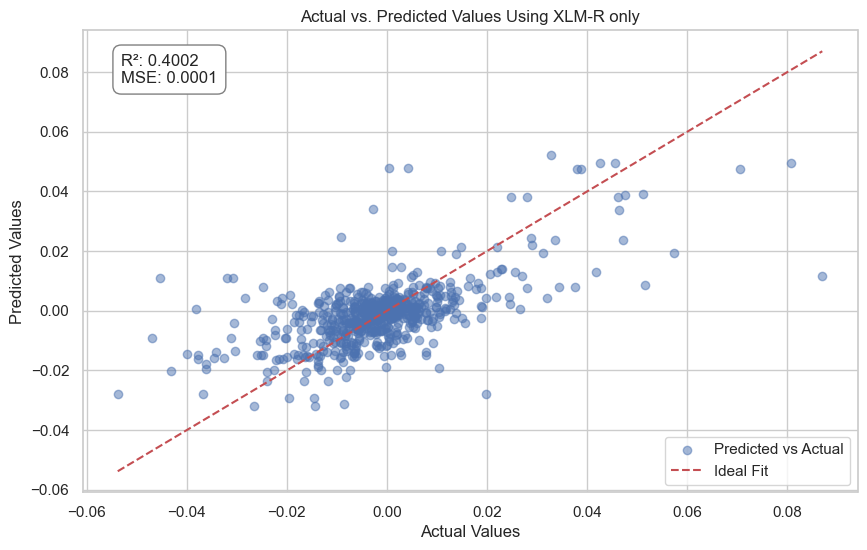

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


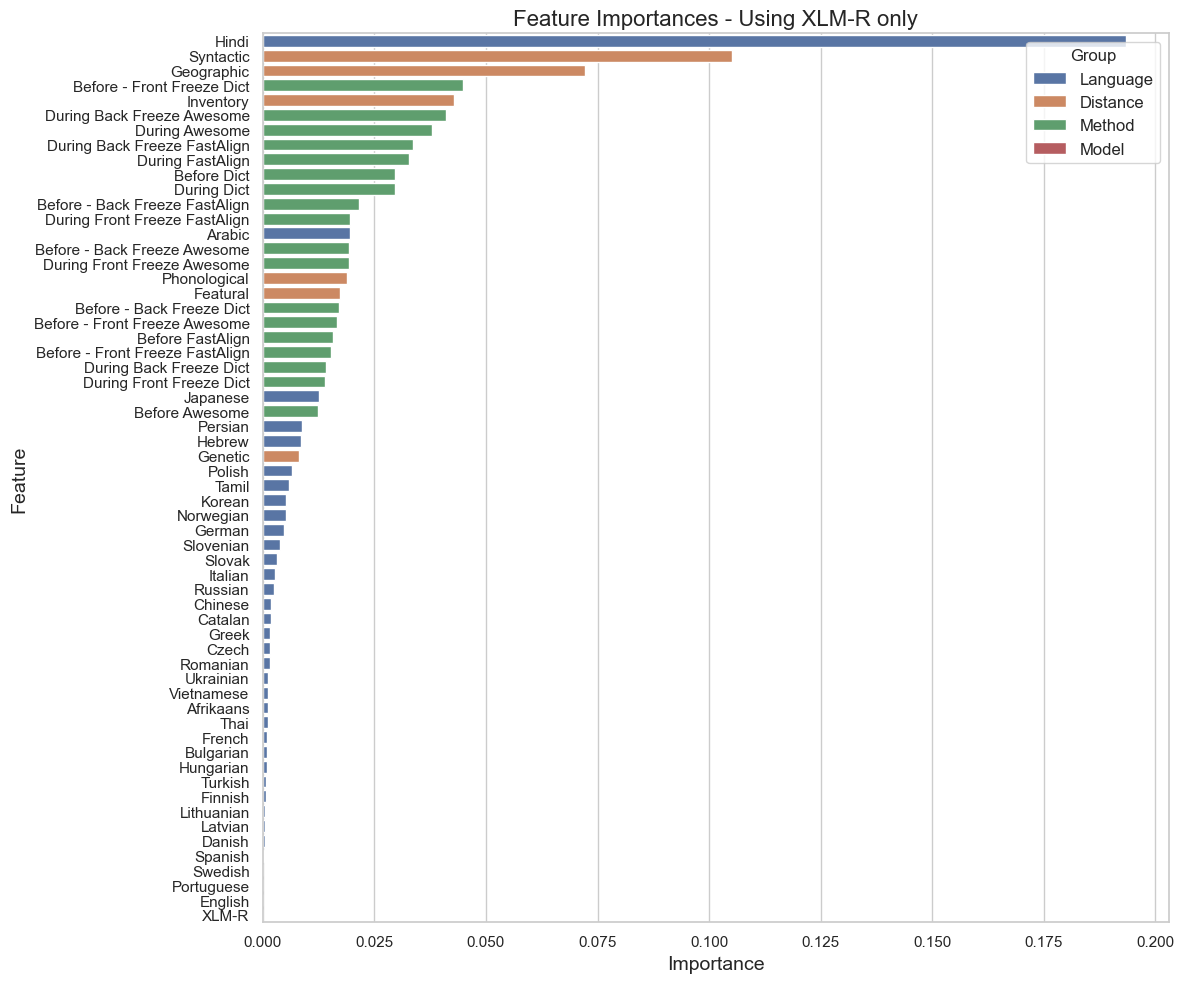

Using XLM-R freeze methods only



100%|██████████| 59/59 [00:00<00:00, 151.71it/s]


Final Test MSE for Using XLM-R freeze methods only (Random Forest): 9.739242552632483e-05


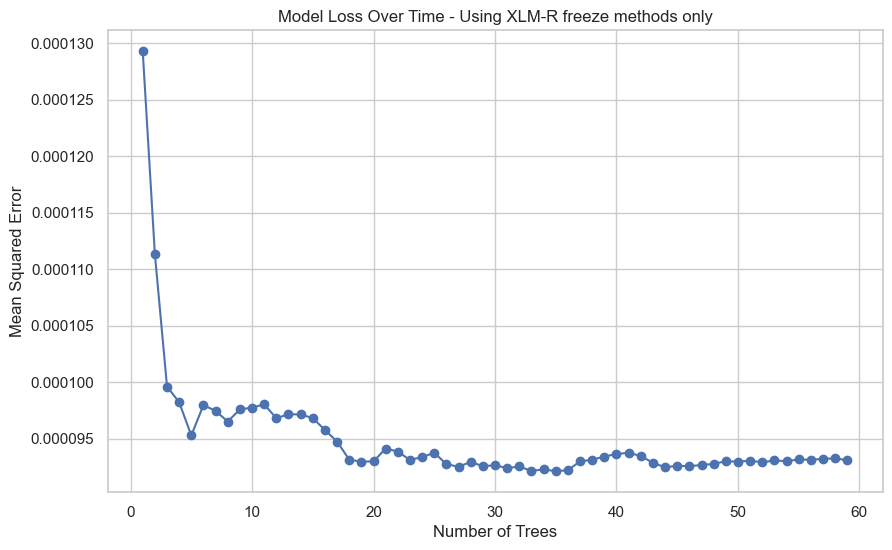

Calculating SHAP values: 100%|██████████| 1469/1469 [00:05<00:00, 263.37it/s]


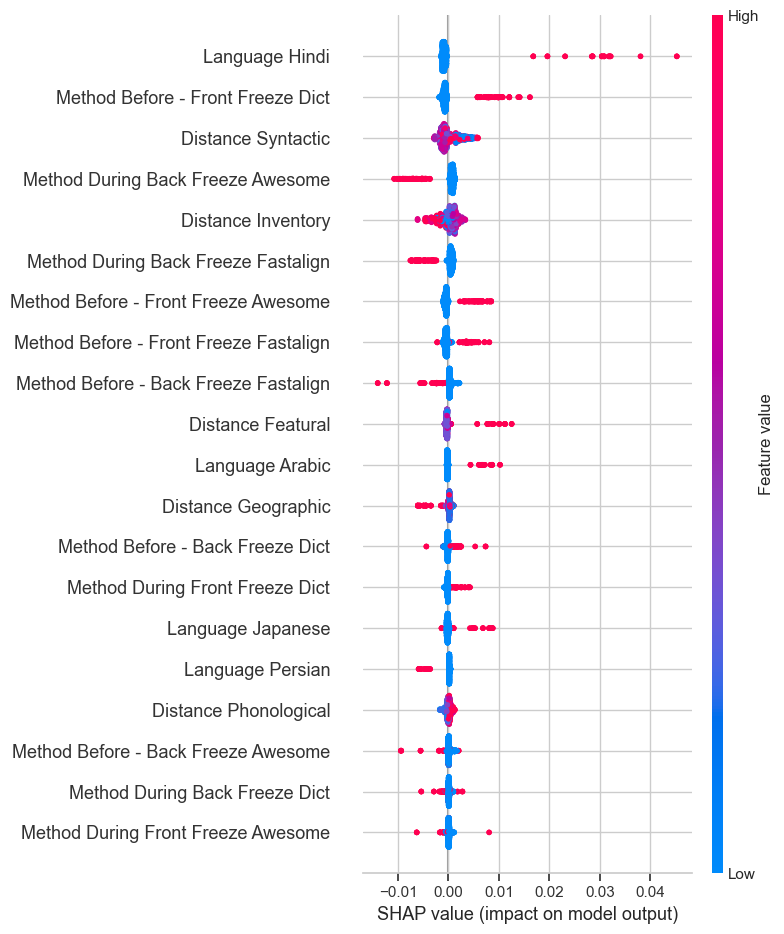

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


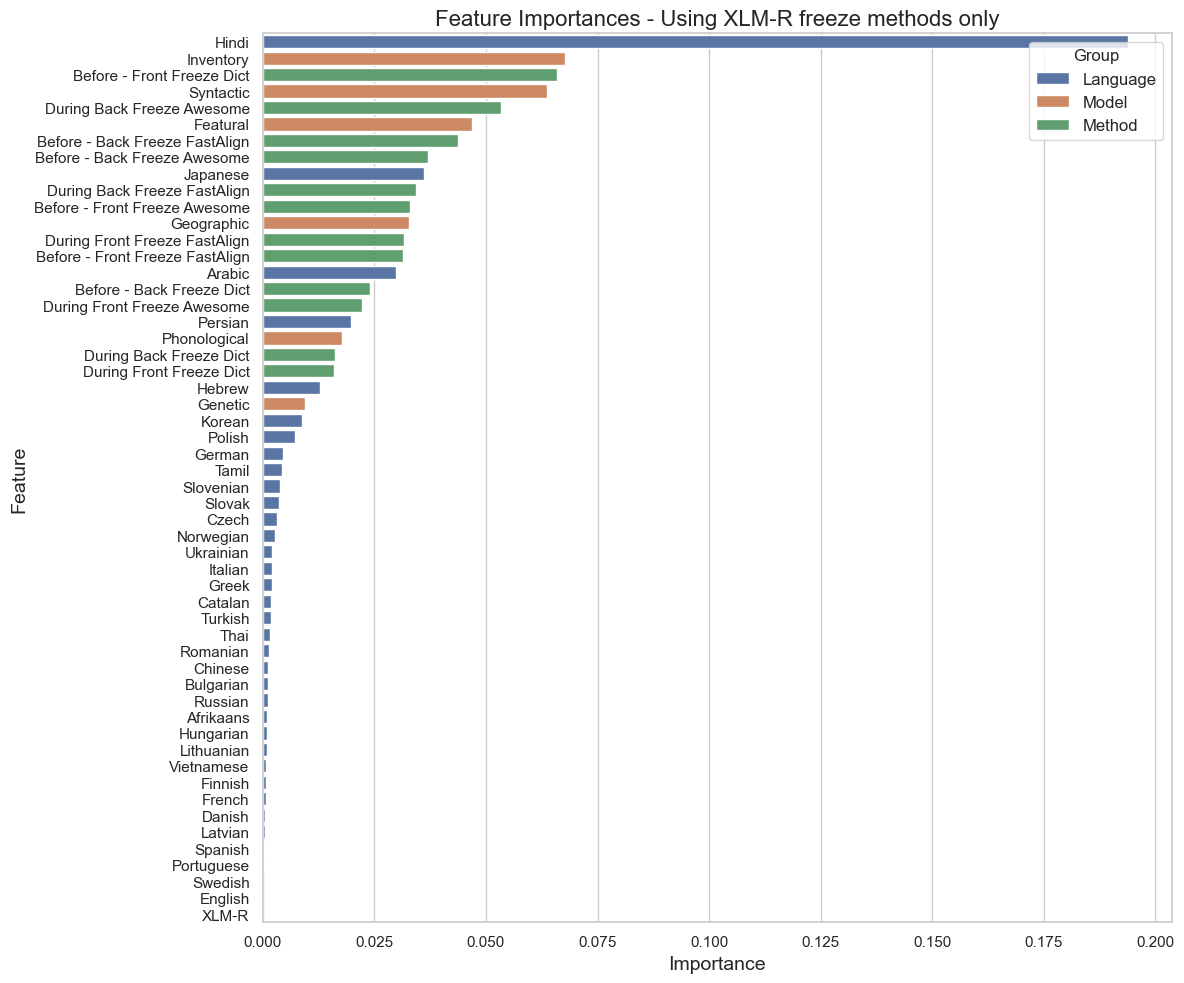

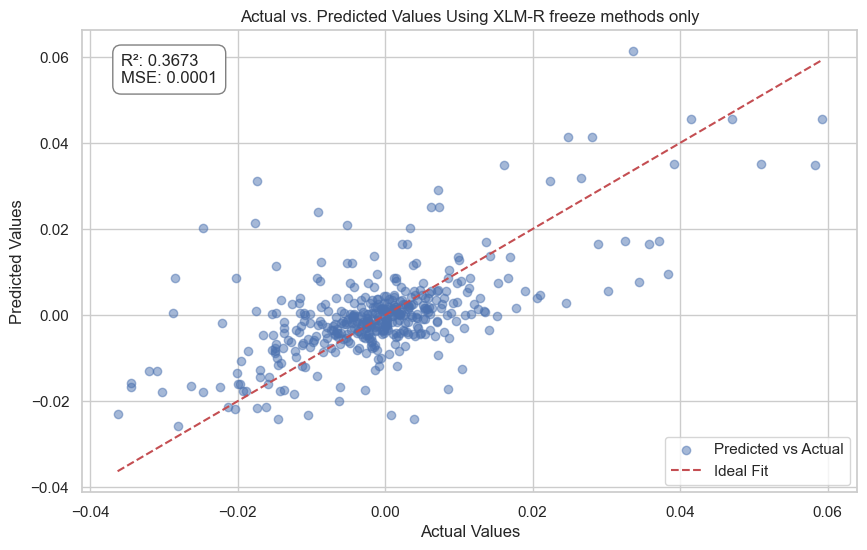

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


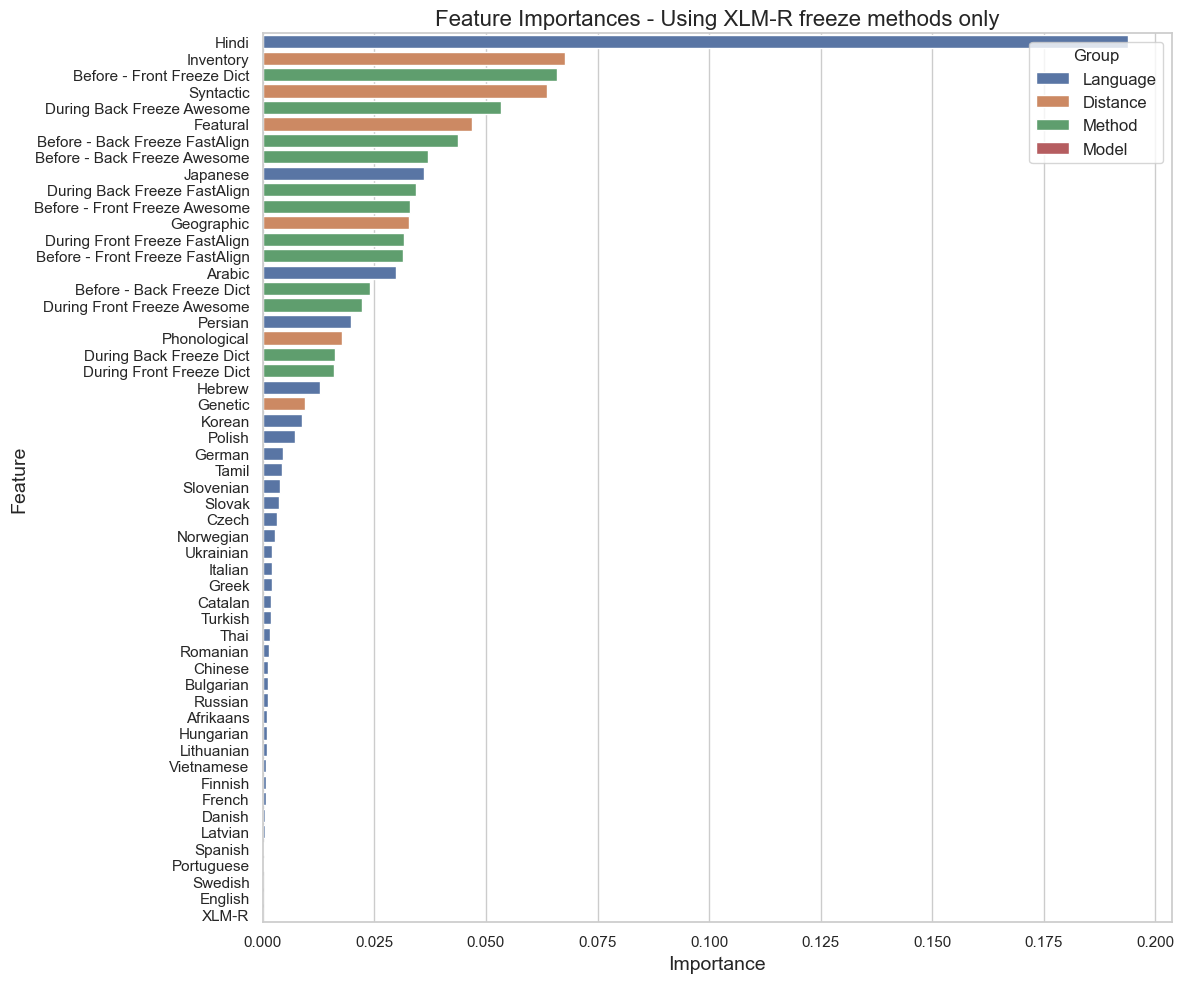

Using XLM-R vanilla methods only



100%|██████████| 59/59 [00:00<00:00, 267.50it/s]



Final Test MSE for Using XLM-R vanilla methods only (Random Forest): 0.00012341077258555267


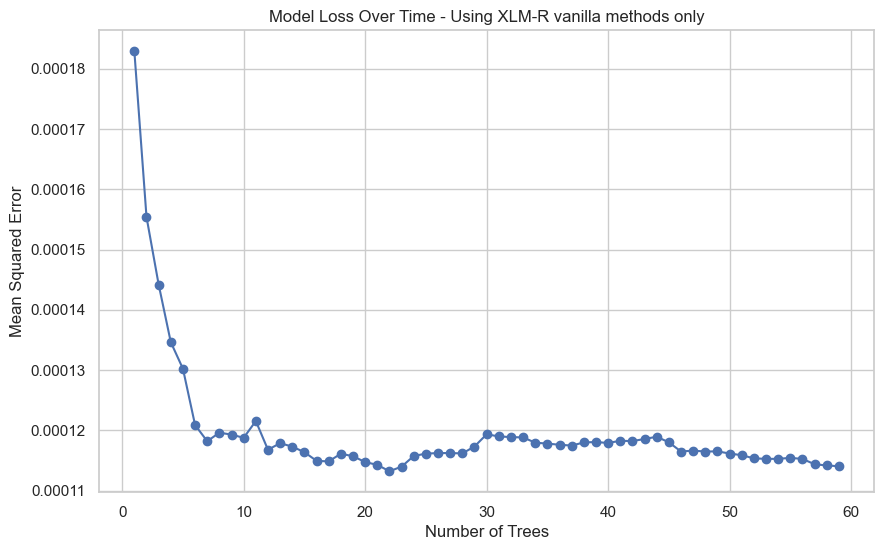

Calculating SHAP values: 100%|██████████| 734/734 [00:01<00:00, 396.24it/s]


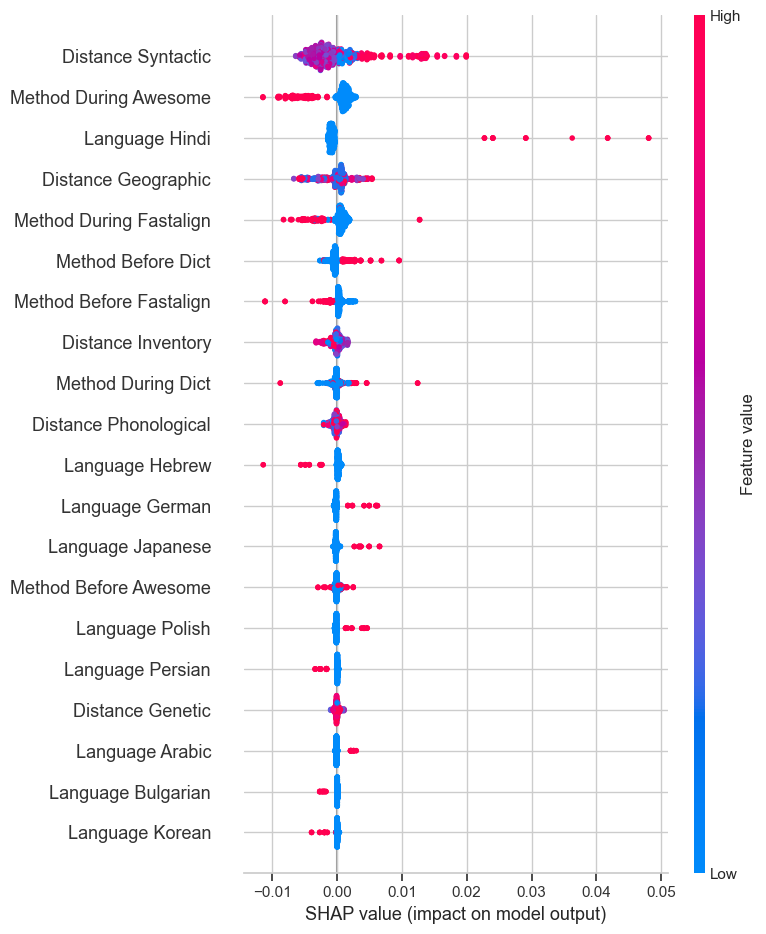

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


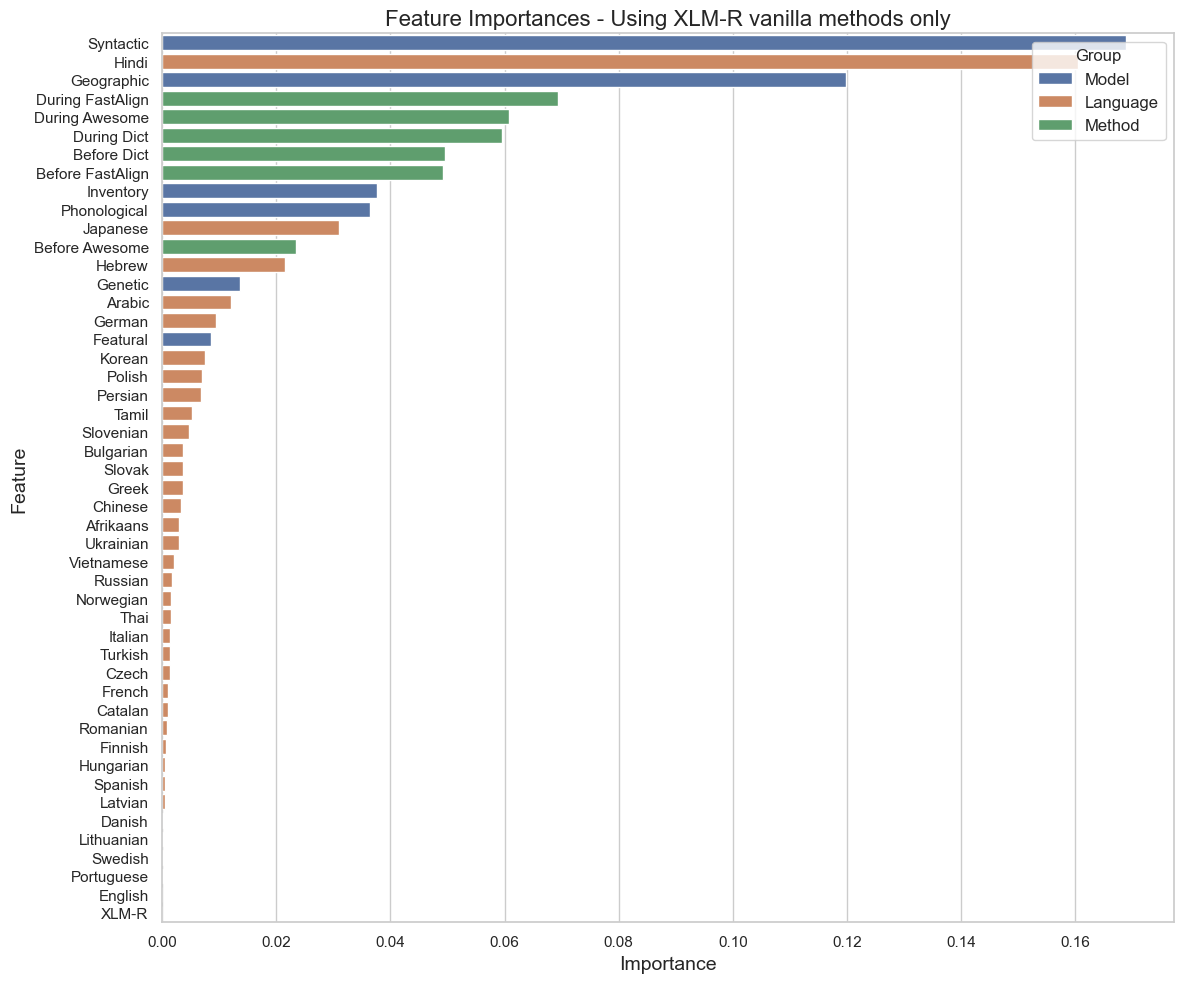

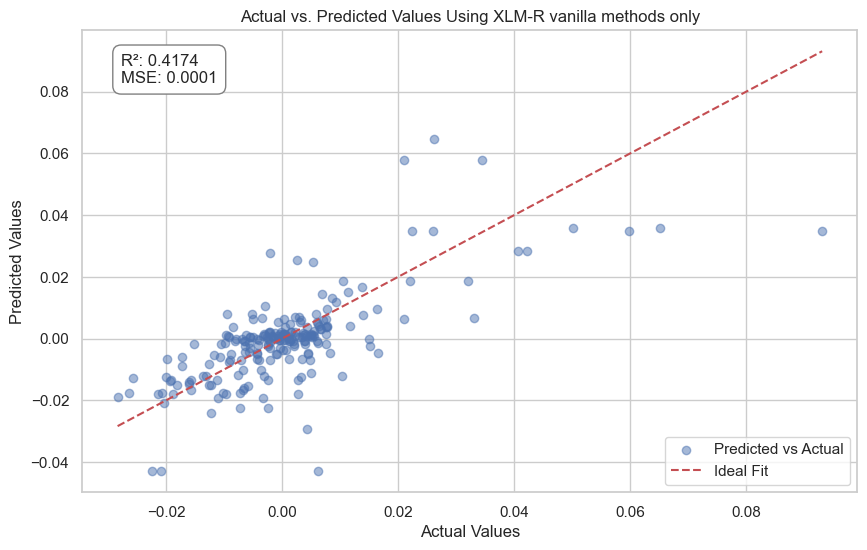

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


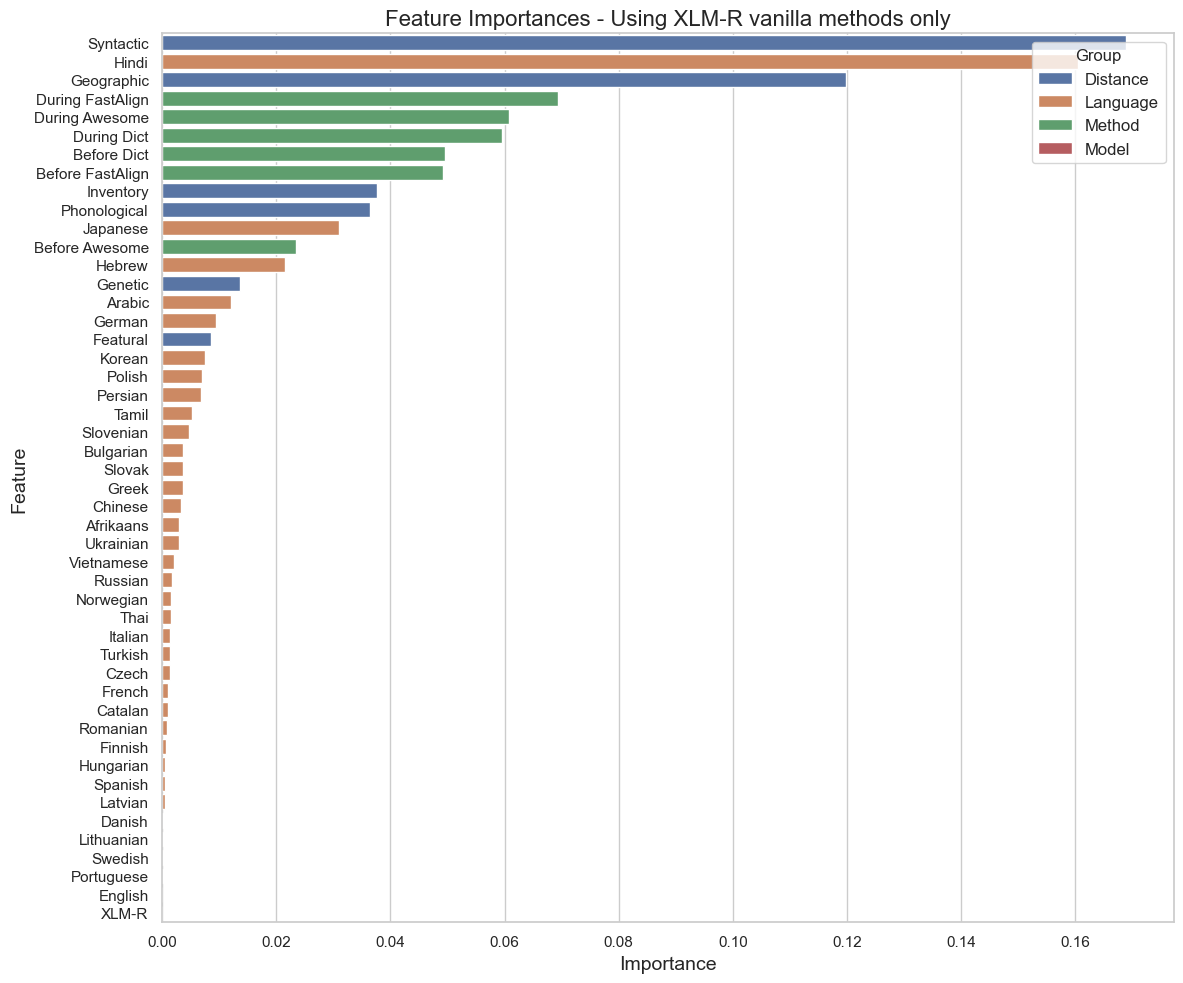

Using distilMBERT only



100%|██████████| 59/59 [00:00<00:00, 132.50it/s]



Final Test MSE for Using distilMBERT only (Random Forest): 0.00033192656747250716


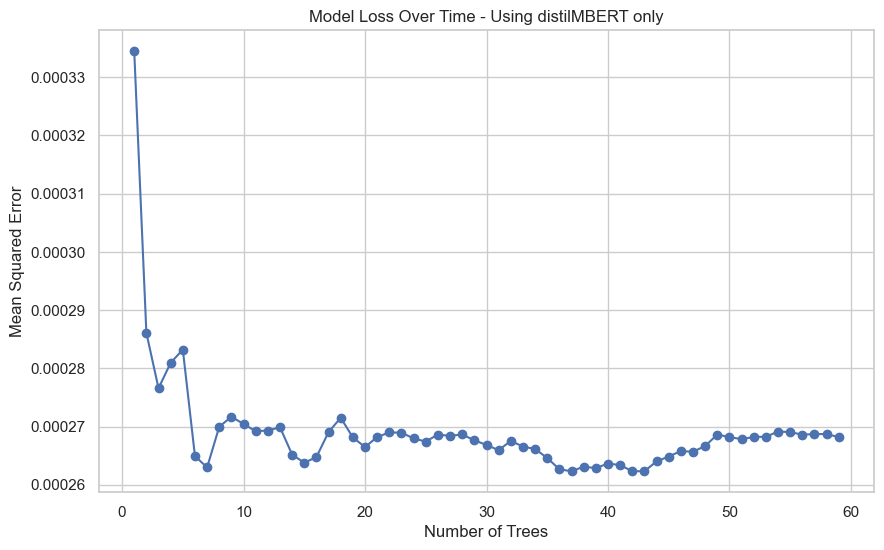

Calculating SHAP values: 100%|██████████| 2204/2204 [00:11<00:00, 193.43it/s]


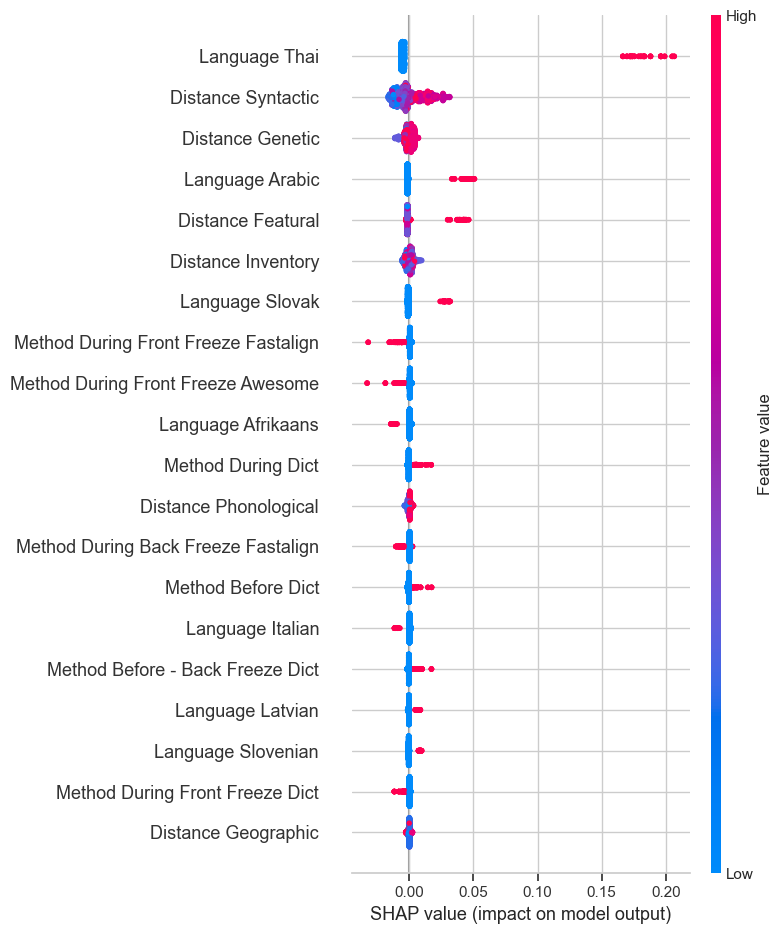

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


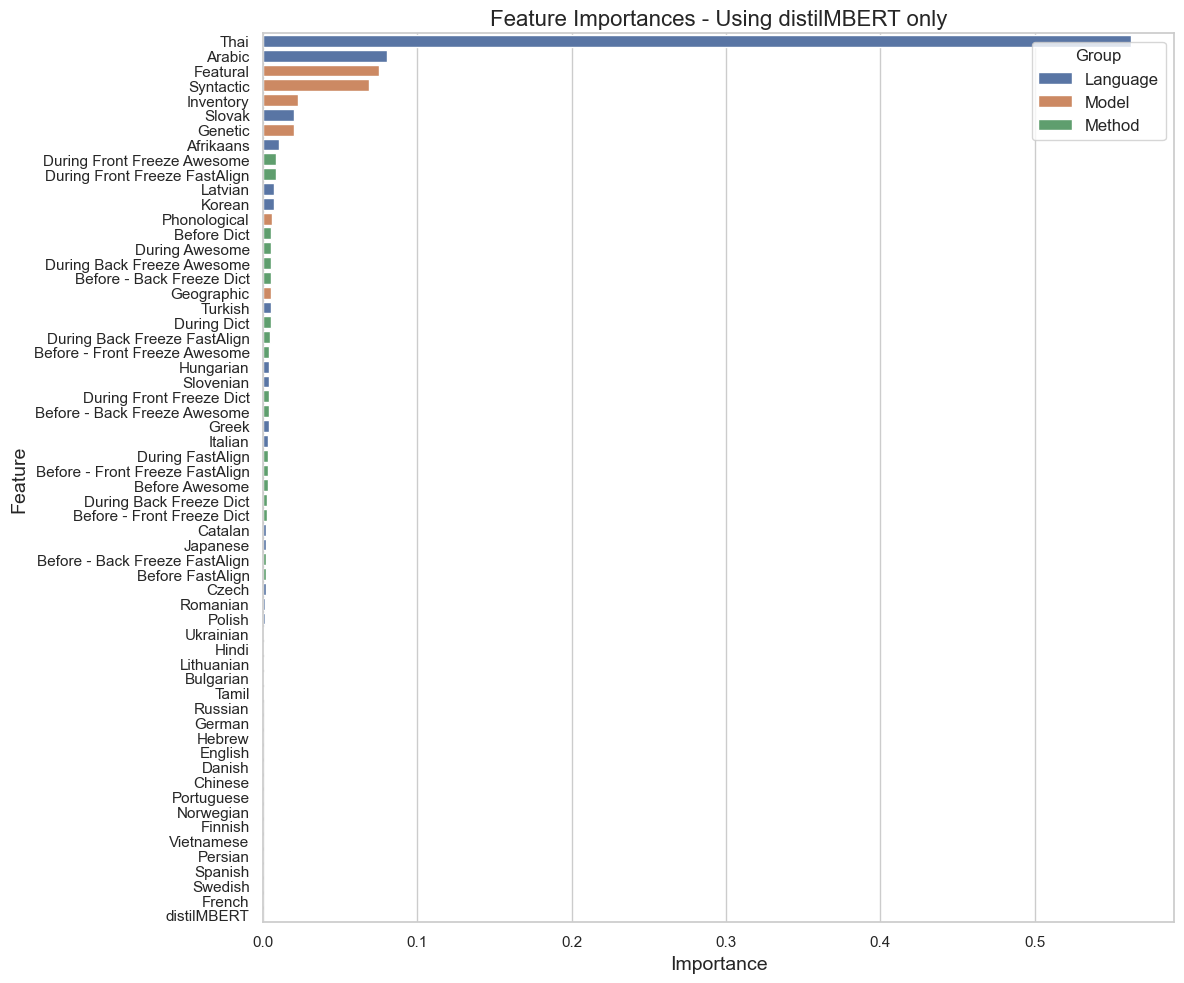

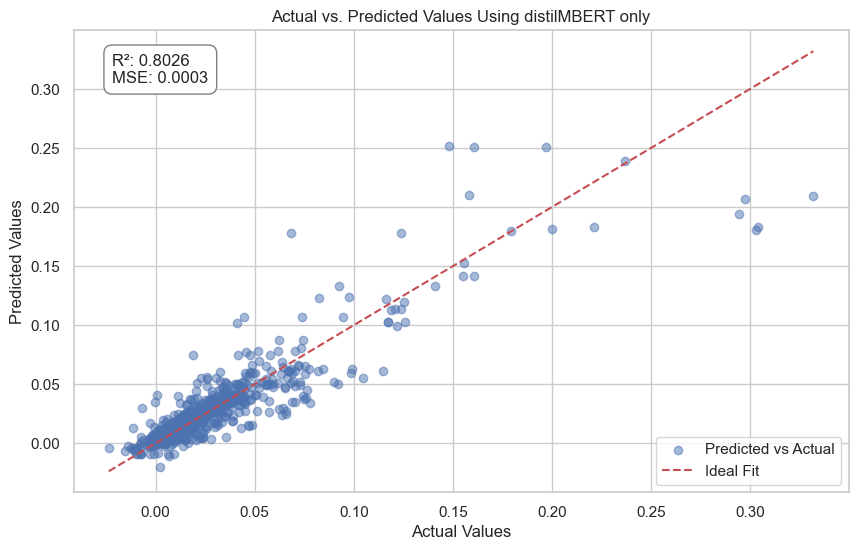

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


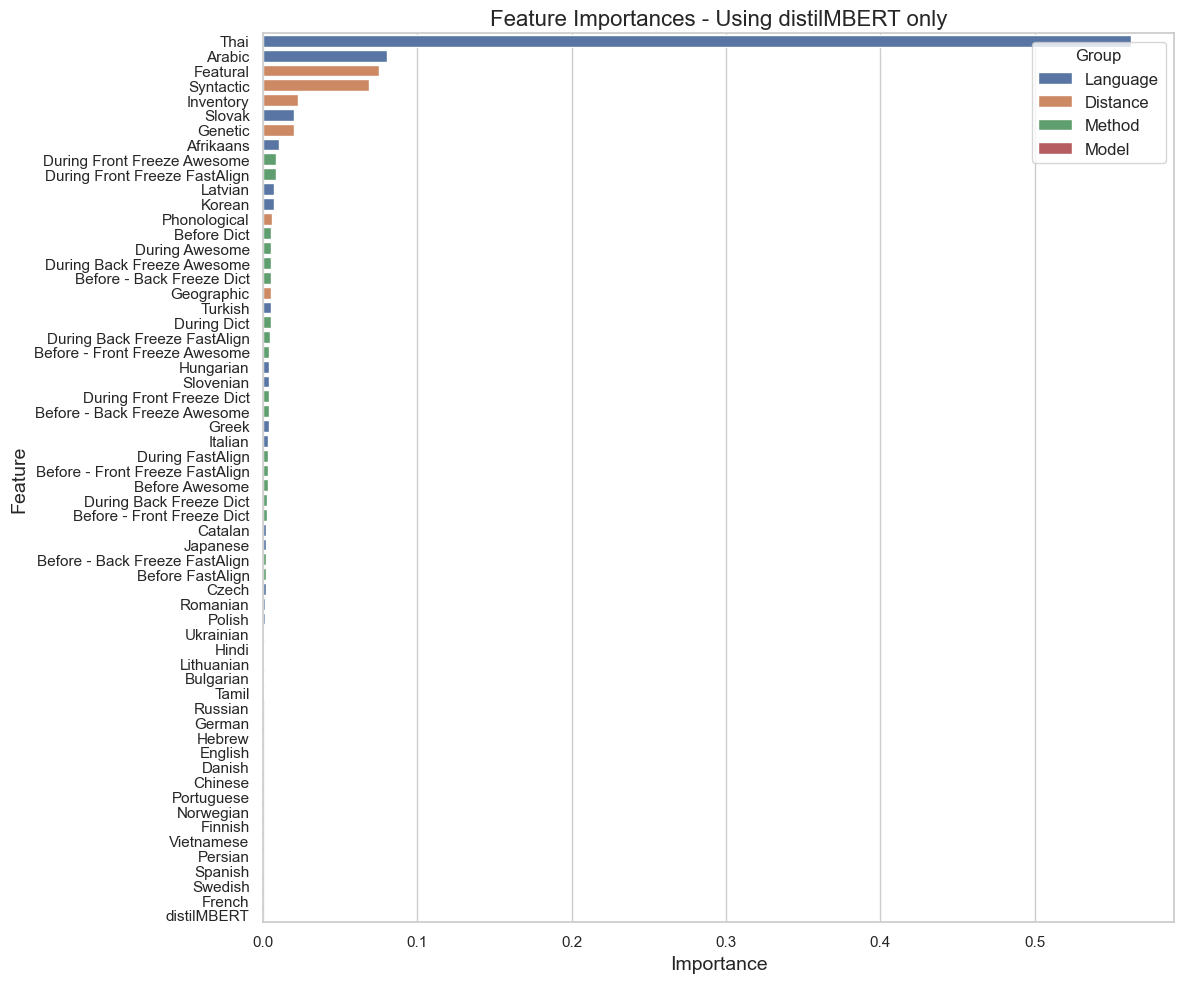

Using distilMBERT freeze methods only



100%|██████████| 59/59 [00:00<00:00, 185.87it/s]



Final Test MSE for Using distilMBERT freeze methods only (Random Forest): 0.000289137646757423


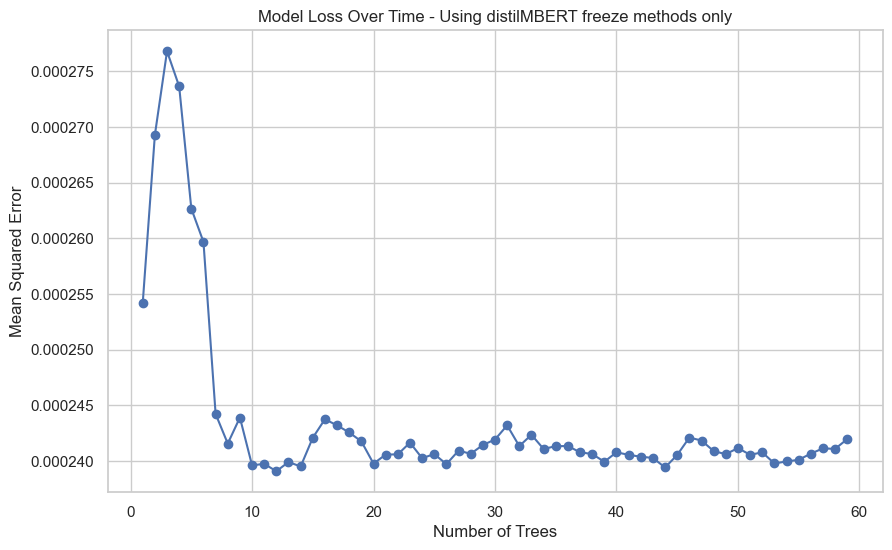

Calculating SHAP values: 100%|██████████| 1469/1469 [00:05<00:00, 249.01it/s]


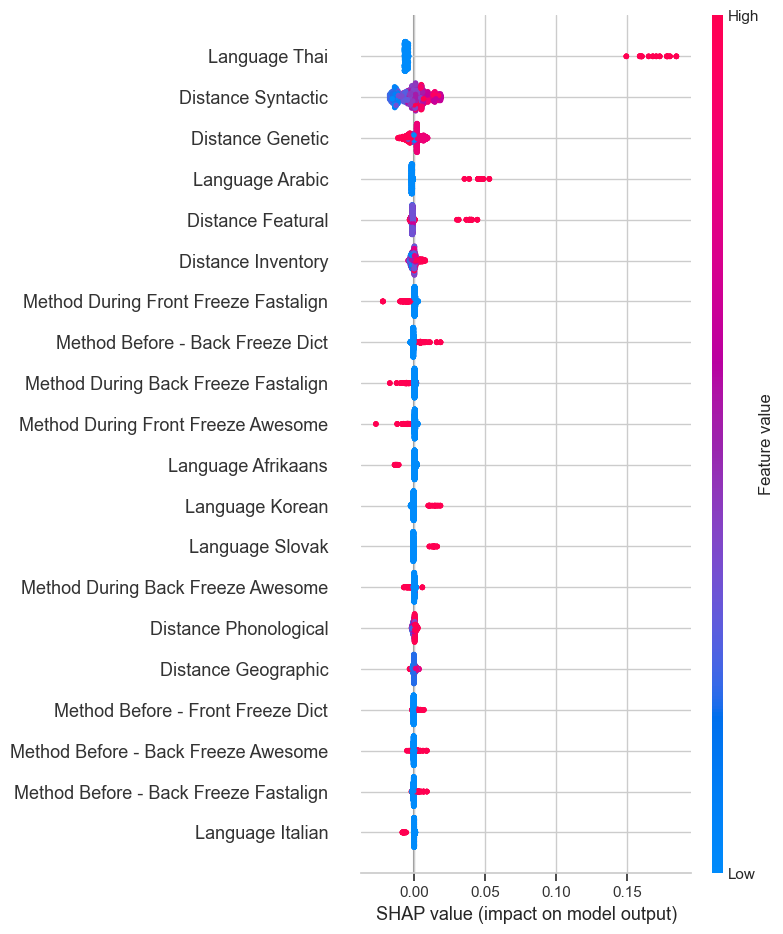

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


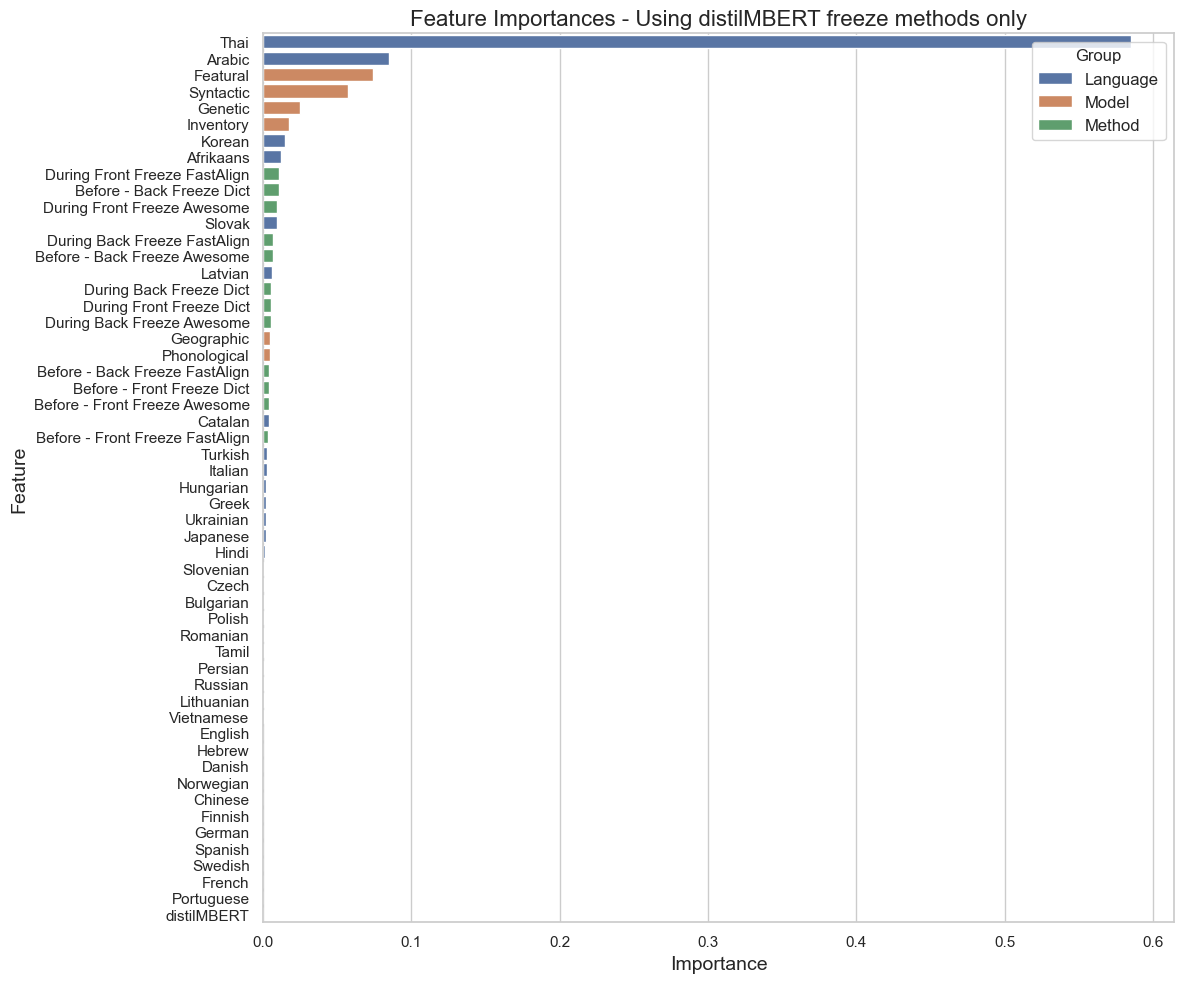

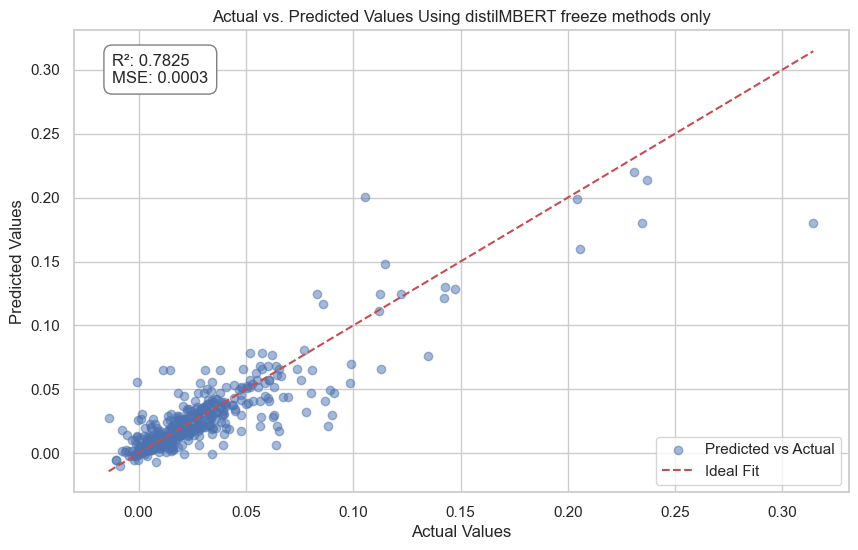

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


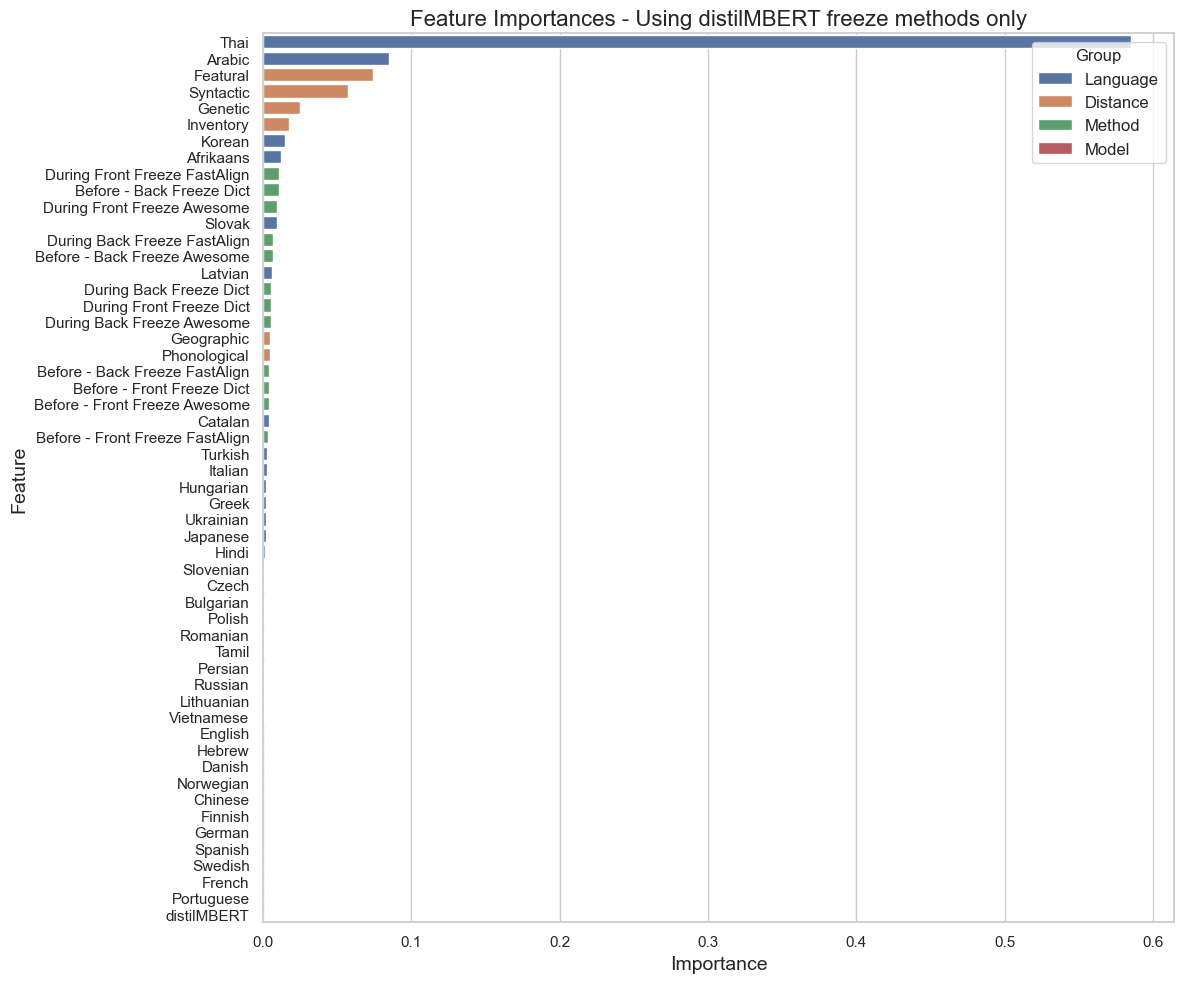

Using distilMBERT vanilla methods only



100%|██████████| 59/59 [00:00<00:00, 140.02it/s]



Final Test MSE for Using distilMBERT vanilla methods only (Random Forest): 0.0001792197251199523


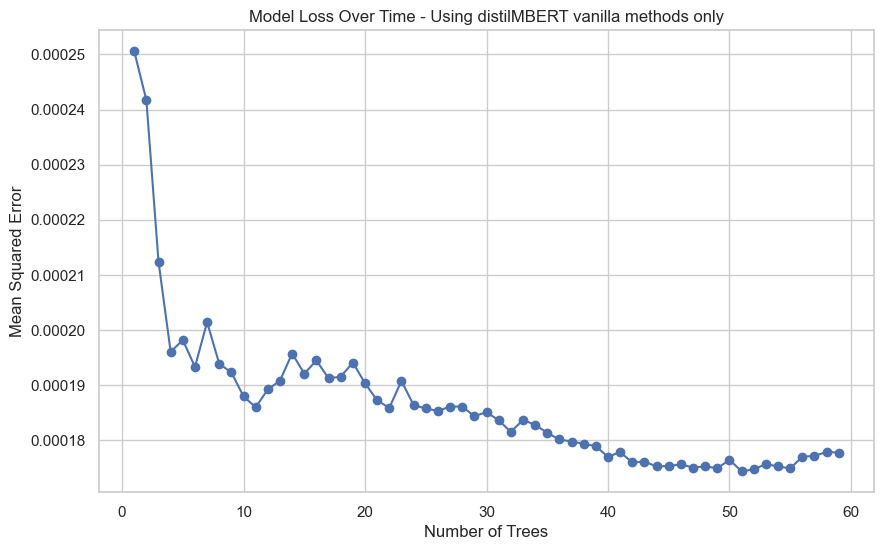

Calculating SHAP values: 100%|██████████| 734/734 [00:01<00:00, 378.39it/s]


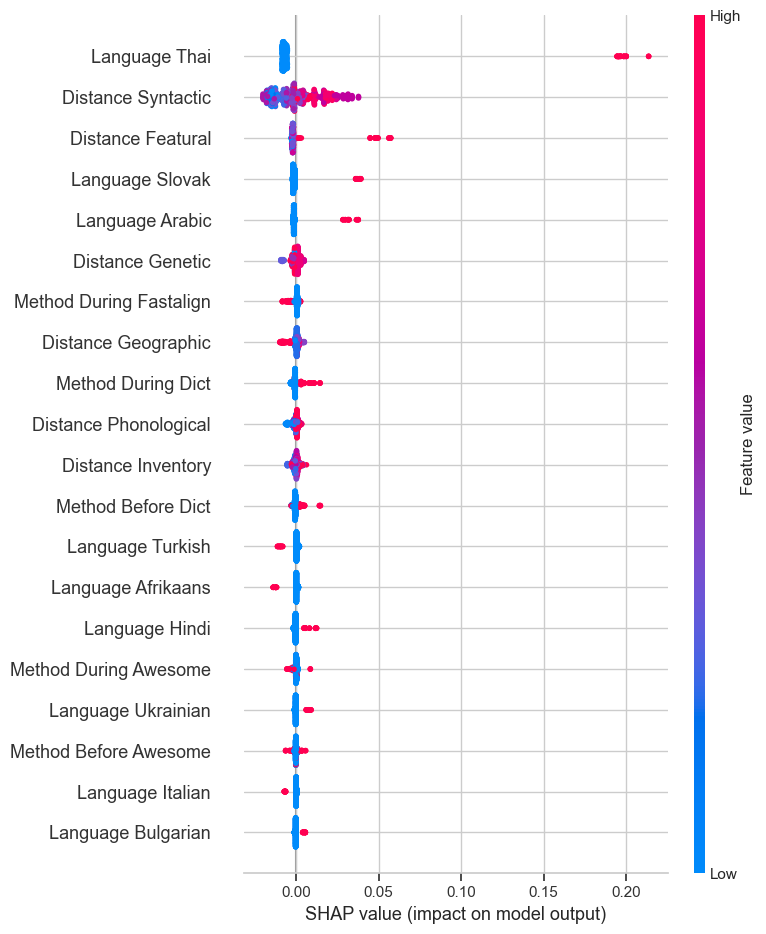

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


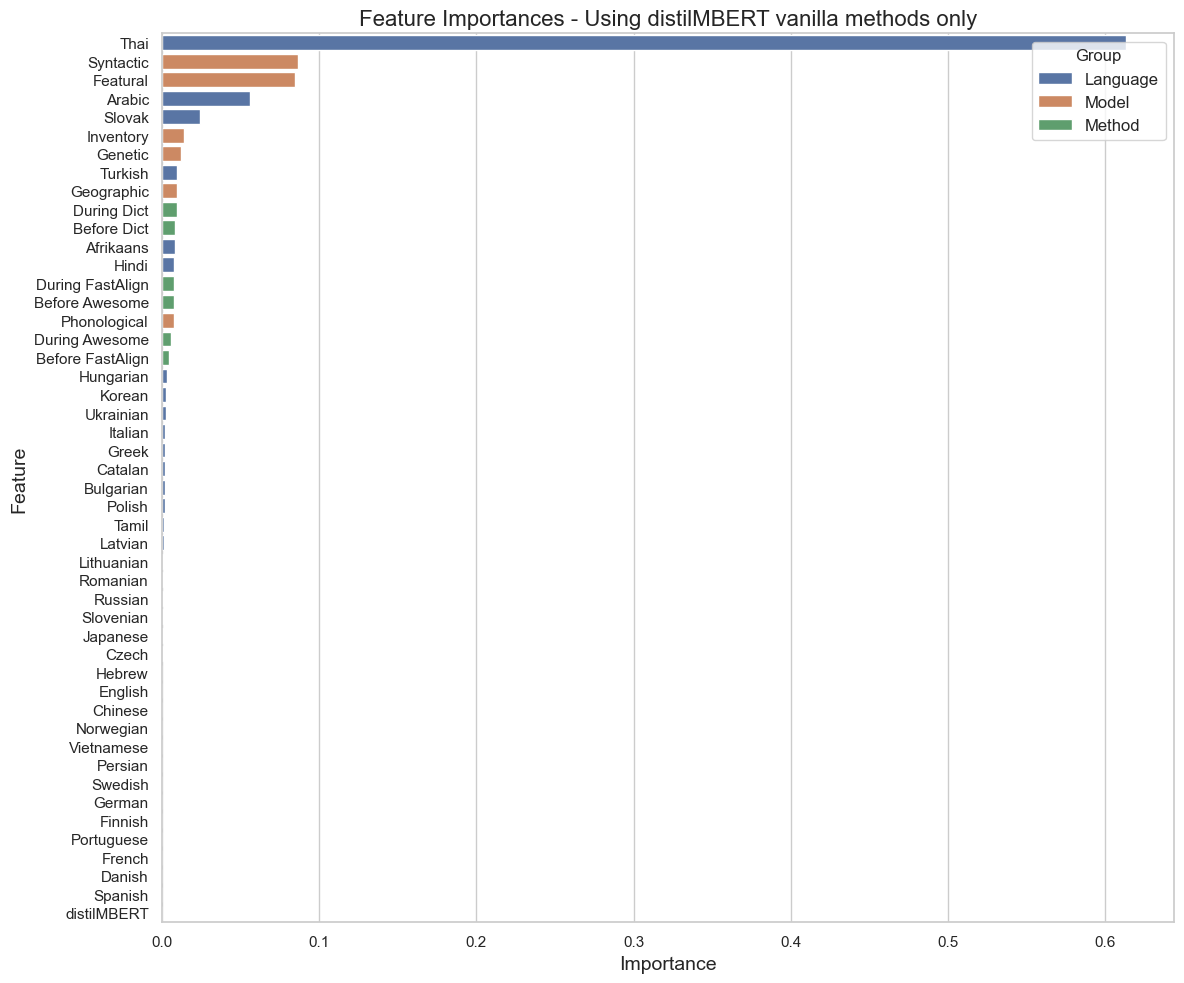

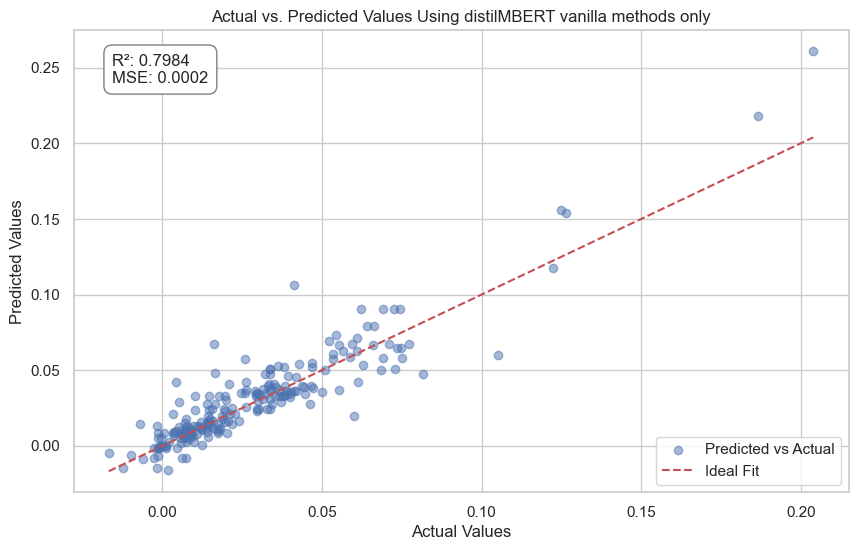

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


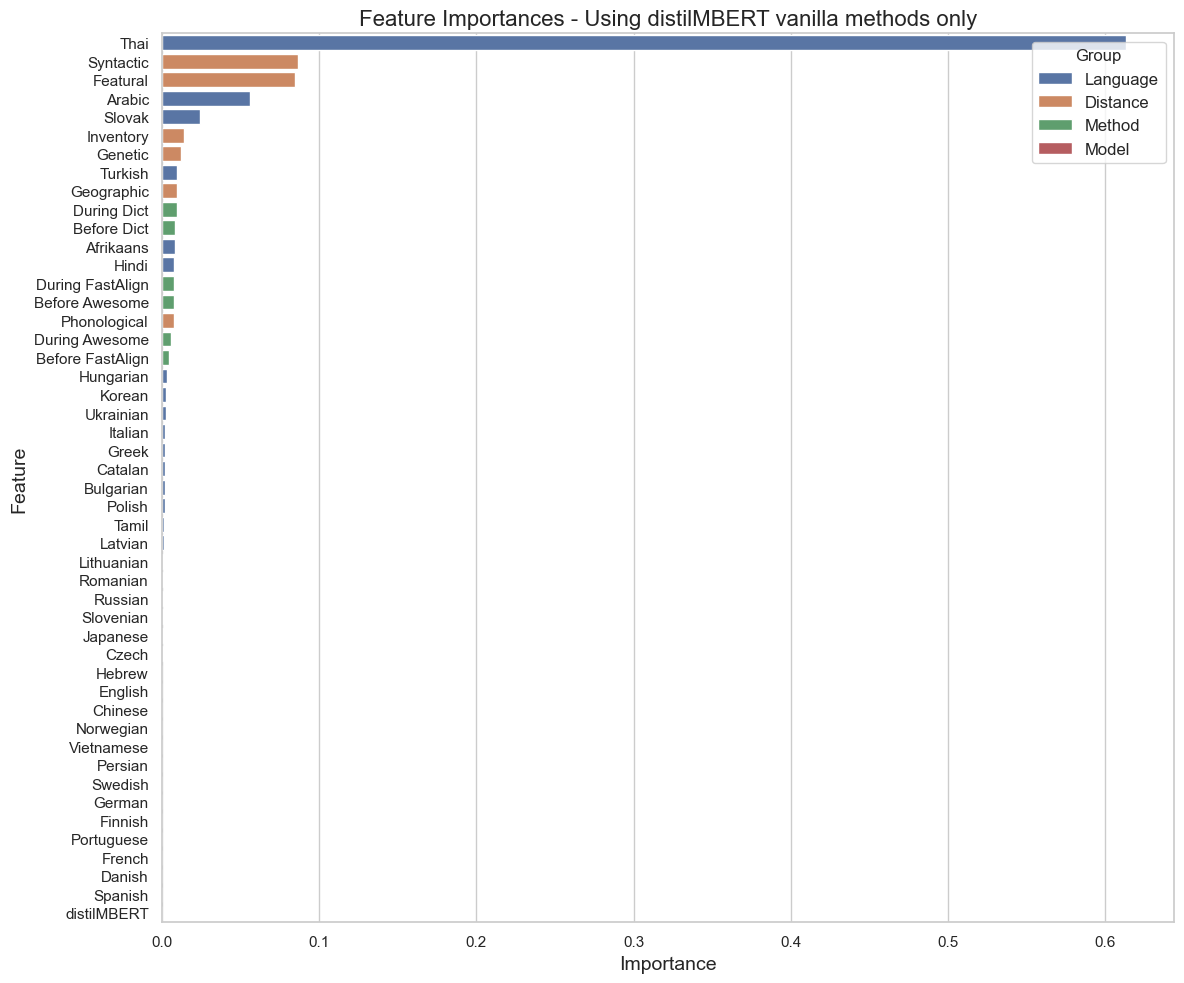

In [43]:
def run_regression_and_plot(df, description):
    train_data, val_data, test_data = split_train_val_test(df, use_standard_split=True)
    train_data = train_data.drop(columns=['method_type'])
    val_data = val_data.drop(columns=['method_type'])
    test_data = test_data.drop(columns=['method_type'])
    
    print(description)
    print()
    
    coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title=description)
    plot_feature_importances(coefficients, encoded_columns, group_by_distance=True, title=description)

# Aggregate
run_regression_and_plot(combined_df_with_flags, "Using all data")

# Freeze methods only
freeze_df = combined_df_with_flags[combined_df_with_flags['method_type'] == 'freeze']
run_regression_and_plot(freeze_df, "Using freeze methods only")

# Vanilla methods only
vanilla_df = combined_df_with_flags[combined_df_with_flags['method_type'] == 'vanilla']
run_regression_and_plot(vanilla_df, "Using vanilla methods only")

# XLM-R only
xlmr_df = combined_df_with_flags[combined_df_with_flags['model'] == 'XLM-R']
run_regression_and_plot(xlmr_df, "Using XLM-R only")

# XLM-R freeze methods only
xlmr_freeze_df = xlmr_df[xlmr_df['method_type'] == 'freeze']
run_regression_and_plot(xlmr_freeze_df, "Using XLM-R freeze methods only")

# XLM-R vanilla methods only
xlmr_vanilla_df = xlmr_df[xlmr_df['method_type'] == 'vanilla']
run_regression_and_plot(xlmr_vanilla_df, "Using XLM-R vanilla methods only")

# distilMBERT only
distilbert_df = combined_df_with_flags[combined_df_with_flags['model'] == 'distilMBERT']
run_regression_and_plot(distilbert_df, "Using distilMBERT only")

# distilMBERT freeze methods only
distilbert_freeze_df = distilbert_df[distilbert_df['method_type'] == 'freeze']
run_regression_and_plot(distilbert_freeze_df, "Using distilMBERT freeze methods only")

# distilMBERT vanilla methods only
distilbert_vanilla_df = distilbert_df[distilbert_df['method_type'] == 'vanilla']
run_regression_and_plot(distilbert_vanilla_df, "Using distilMBERT vanilla methods only")

In [44]:
combined_df_with_flags[combined_df_with_flags['language'] == 'Slovak'].head(25).sort_values(by='delta_accuracy', ascending=False)

model            method language  seed  accuracy  delta_accuracy  \
567   XLM-R       Before Dict   Slovak    17  0.870552        0.019018   
387   XLM-R    Before Awesome   Slovak    17  0.864340        0.012807   
207   XLM-R  Before FastAlign   Slovak    17  0.859433        0.007899   
315   XLM-R  Before FastAlign   Slovak    42  0.867408        0.005368   
603   XLM-R       Before Dict   Slovak    23  0.862883        0.004985   
675   XLM-R       Before Dict   Slovak    42  0.865874        0.003834   
495   XLM-R    Before Awesome   Slovak    42  0.865798        0.003758   
423   XLM-R    Before Awesome   Slovak    23  0.860276        0.002377   
243   XLM-R  Before FastAlign   Slovak    23  0.858282        0.000383   
747   XLM-R  During FastAlign   Slovak    17  0.848236       -0.003298   
639   XLM-R       Before Dict   Slovak    66  0.861426       -0.006442   
927   XLM-R    During Awesome   Slovak    17  0.844632       -0.006902   
531   XLM-R    Before Awesome   Slovak    31  0.864724       -0.008512   
711   XLM-R       Before Dict   Slovak    31  0.863650       -0.009586   
279   XLM-R  Before FastAlign   Slovak    66  0.857975       -0.009893   
855   XLM-R  During FastAlign   Slovak    42  0.850920       -0.011120   
459   XLM-R    Before Awesome   Slovak    66  0.855291       -0.012577   
963   XLM-R    During Awesome   Slovak    23  0.844172       -0.013727   
1035  XLM-R    During Awesome   Slovak    42  0.846242       -0.015798   
783   XLM-R  During FastAlign   Slovak    23  0.841948       -0.015951   
351   XLM-R  Before FastAlign   Slovak    31  0.853144       -0.020092   
819   XLM-R  During FastAlign   Slovak    66  0.842485       -0.025383   
999   XLM-R    During Awesome   Slovak    66  0.842178       -0.025690   
1071  XLM-R    During Awesome   Slovak    31  0.846779       -0.026457   
891   XLM-R  During FastAlign   Slovak    31  0.845552       -0.027684   

      syntactic  geographic  phonological  genetic  inventory  featural  \
567        0.57         0.1        0.5687      0.9     0.5983       0.6   
387        0.57         0.1        0.5687      0.9     0.5983       0.6   
207        0.57         0.1        0.5687      0.9     0.5983       0.6   
315        0.57         0.1        0.5687      0.9     0.5983       0.6   
603        0.57         0.1        0.5687      0.9     0.5983       0.6   
675        0.57         0.1        0.5687      0.9     0.5983       0.6   
495        0.57         0.1        0.5687      0.9     0.5983       0.6   
423        0.57         0.1        0.5687      0.9     0.5983       0.6   
243        0.57         0.1        0.5687      0.9     0.5983       0.6   
747        0.57         0.1        0.5687      0.9     0.5983       0.6   
639        0.57         0.1        0.5687      0.9     0.5983       0.6   
927        0.57         0.1        0.5687      0.9     0.5983       0.6   
531        0.57         0.1        0.5687      0.9     0.5983       0.6   
711        0.57         0.1        0.5687      0.9     0.5983       0.6   
279        0.57         0.1        0.5687      0.9     0.5983       0.6   
855        0.57         0.1        0.5687      0.9     0.5983       0.6   
459        0.57         0.1        0.5687      0.9     0.5983       0.6   
963        0.57         0.1        0.5687      0.9     0.5983       0.6   
1035       0.57         0.1        0.5687      0.9     0.5983       0.6   
783        0.57         0.1        0.5687      0.9     0.5983       0.6   
351        0.57         0.1        0.5687      0.9     0.5983       0.6   
819        0.57         0.1        0.5687      0.9     0.5983       0.6   
999        0.57         0.1        0.5687      0.9     0.5983       0.6   
1071       0.57         0.1        0.5687      0.9     0.5983       0.6   
891        0.57         0.1        0.5687      0.9     0.5983       0.6   

     method_type  
567      vanilla  
387      vanilla  
207      vanilla  
315      vanilla  
603      vanilla  
675      vanilla

In [45]:
combined_df_with_flags[(combined_df_with_flags['model'] == 'distilMBERT') & (combined_df_with_flags['language'] == 'Thai')].head(25).sort_values(by='delta_accuracy', ascending=False)

model                           method language  seed  accuracy  \
4040  distilMBERT        Before - Back Freeze Dict     Thai    17  0.544470   
4033  distilMBERT                   During Awesome     Thai    17  0.542456   
4031  distilMBERT                      Before Dict     Thai    17  0.542277   
4039  distilMBERT     Before - Back Freeze Awesome     Thai    17  0.539904   
4045  distilMBERT       During Back Freeze Awesome     Thai    17  0.537487   
4046  distilMBERT          During Back Freeze Dict     Thai    17  0.533906   
4034  distilMBERT                      During Dict     Thai    17  0.533280   
4030  distilMBERT                   Before Awesome     Thai    17  0.530012   
4029  distilMBERT                 Before FastAlign     Thai    17  0.524327   
4038  distilMBERT   Before - Back Freeze FastAlign     Thai    17  0.524104   
4036  distilMBERT    Before - Front Freeze Awesome     Thai    17  0.520926   
4044  distilMBERT     During Back Freeze FastAlign     Thai    17  0.508616   
4037  distilMBERT       Before - Front Freeze Dict     Thai    17  0.507229   
4032  distilMBERT                 During FastAlign     Thai    17  0.506602   
4035  distilMBERT  Before - Front Freeze FastAlign     Thai    17  0.502842   
4042  distilMBERT      During Front Freeze Awesome     Thai    17  0.486863   
4043  distilMBERT         During Front Freeze Dict     Thai    17  0.482163   
4715  distilMBERT                      Before Dict     Thai    23  0.559420   
4718  distilMBERT                      During Dict     Thai    23  0.555168   
4041  distilMBERT    During Front Freeze FastAlign     Thai    17  0.473255   
4717  distilMBERT                   During Awesome     Thai    23  0.541516   
4713  distilMBERT                 Before FastAlign     Thai    23  0.523119   
4716  distilMBERT                 During FastAlign     Thai    23  0.519449   
4714  distilMBERT                   Before Awesome     Thai    23  0.506557   
4719  distilMBERT  Before - Front Freeze FastAlign     Thai    23  0.486281   

      delta_accuracy  syntactic  geographic  phonological  genetic  inventory  \
4040        0.241574       0.56         0.5          0.39      1.0     0.4147   
4033        0.239560       0.56         0.5          0.39      1.0     0.4147   
4031        0.239381       0.56         0.5          0.39      1.0     0.4147   
4039        0.237008       0.56         0.5          0.39      1.0     0.4147   
4045        0.234591       0.56         0.5          0.39      1.0     0.4147   
4046        0.231010       0.56         0.5          0.39      1.0     0.4147   
4034        0.230384       0.56         0.5          0.39      1.0     0.4147   
4030        0.227116       0.56         0.5          0.39      1.0     0.4147   
4029        0.221431       0.56         0.5          0.39      1.0     0.4147   
4038        0.221208       0.56         0.5          0.39      1.0     0.4147   
4036        0.218030       0.56         0.5          0.39      1.0     0.4147   
4044        0.205720       0.56         0.5          0.39      1.0     0.4147   
4037        0.204333       0.56         0.5          0.39      1.0     0.4147   
4032        0.203706       0.56         0.5          0.39      1.0     0.4147   
4035        0.199946       0.56         0.5          0.39      1.0     0.4147   
4042        0.183967       0.56         0.5          0.39      1.0     0.4147   
4043        0.179267       0.56         0.5          0.39      1.0     0.4147   
4715        0.178461       0.56         0.5          0.39      1.0     0.4147   
4718        0.174209       0.56         0.5          0.39      1.0     0.4147   
4041        0.170359       0.56         0.5          0.39      1.0     0.4147   
4717        0.160557       0.56         0.5          0.39      1.0     0.4147   
4713        0.142160       0.56         0.5          0.39      1.0     0.4147   
4716        0.138490       0.56         0.5          0.39      1.0     0.4147   
4714        0

In [46]:
combined_df_with_flags[combined_df_with_flags['language'] == 'Arabic'].head(25).sort_values(by='delta_accuracy', ascending=False)

model            method language  seed  accuracy  delta_accuracy  \
543   XLM-R       Before Dict   Arabic    17  0.687372        0.065038   
651   XLM-R       Before Dict   Arabic    42  0.682646        0.050208   
183   XLM-R  Before FastAlign   Arabic    17  0.667102        0.044768   
687   XLM-R       Before Dict   Arabic    31  0.672138        0.043244   
363   XLM-R    Before Awesome   Arabic    17  0.664024        0.041690   
579   XLM-R       Before Dict   Arabic    23  0.677237        0.032736   
615   XLM-R       Before Dict   Arabic    66  0.659205        0.026892   
471   XLM-R    Before Awesome   Arabic    42  0.657993        0.025555   
507   XLM-R    Before Awesome   Arabic    31  0.653081        0.024187   
291   XLM-R  Before FastAlign   Arabic    42  0.656532        0.024094   
723   XLM-R  During FastAlign   Arabic    17  0.644252        0.021918   
1047  XLM-R    During Awesome   Arabic    31  0.649257        0.020363   
903   XLM-R    During Awesome   Arabic    17  0.642511        0.020177   
327   XLM-R  Before FastAlign   Arabic    31  0.649008        0.020114   
831   XLM-R  During FastAlign   Arabic    42  0.650998        0.018560   
867   XLM-R  During FastAlign   Arabic    31  0.647081        0.018187   
1011  XLM-R    During Awesome   Arabic    42  0.648728        0.016290   
219   XLM-R  Before FastAlign   Arabic    23  0.656470        0.011969   
255   XLM-R  Before FastAlign   Arabic    66  0.643754        0.011441   
399   XLM-R    Before Awesome   Arabic    23  0.655755        0.011254   
795   XLM-R  During FastAlign   Arabic    66  0.638283        0.005969   
435   XLM-R    Before Awesome   Arabic    66  0.634956        0.002643   
975   XLM-R    During Awesome   Arabic    66  0.634707        0.002394   
759   XLM-R  During FastAlign   Arabic    23  0.640863       -0.003637   
939   XLM-R    During Awesome   Arabic    23  0.639153       -0.005347   

      syntactic  geographic  phonological  genetic  inventory  featural  \
543        0.67         0.2        0.5687      1.0     0.5983       0.8   
651        0.67         0.2        0.5687      1.0     0.5983       0.8   
183        0.67         0.2        0.5687      1.0     0.5983       0.8   
687        0.67         0.2        0.5687      1.0     0.5983       0.8   
363        0.67         0.2        0.5687      1.0     0.5983       0.8   
579        0.67         0.2        0.5687      1.0     0.5983       0.8   
615        0.67         0.2        0.5687      1.0     0.5983       0.8   
471        0.67         0.2        0.5687      1.0     0.5983       0.8   
507        0.67         0.2        0.5687      1.0     0.5983       0.8   
291        0.67         0.2        0.5687      1.0     0.5983       0.8   
723        0.67         0.2        0.5687      1.0     0.5983       0.8   
1047       0.67         0.2        0.5687      1.0     0.5983       0.8   
903        0.67         0.2        0.5687      1.0     0.5983       0.8   
327        0.67         0.2        0.5687      1.0     0.5983       0.8   
831        0.67         0.2        0.5687      1.0     0.5983       0.8   
867        0.67         0.2        0.5687      1.0     0.5983       0.8   
1011       0.67         0.2        0.5687      1.0     0.5983       0.8   
219        0.67         0.2        0.5687      1.0     0.5983       0.8   
255        0.67         0.2        0.5687      1.0     0.5983       0.8   
399        0.67         0.2        0.5687      1.0     0.5983       0.8   
795        0.67         0.2        0.5687      1.0     0.5983       0.8   
435        0.67         0.2        0.5687      1.0     0.5983       0.8   
975        0.67         0.2        0.5687      1.0     0.5983       0.8   
759        0.67         0.2        0.5687      1.0     0.5983       0.8   
939        0.67         0.2        0.5687      1.0     0.5983       0.8   

     method_type  
543      vanilla  
651      vanilla  
183      vanilla  
687      vanilla  
363      vanilla  
579      vanilla

In [47]:
combined_df_with_flags[(combined_df_with_flags['model'] == 'distilMBERT') & (combined_df_with_flags['language'] == 'Arabic')].head(25).sort_values(by='delta_accuracy', ascending=False)

model                           method language  seed  accuracy  \
3451  distilMBERT        Before - Back Freeze Dict   Arabic    17  0.668654   
3445  distilMBERT                      During Dict   Arabic    17  0.665394   
3442  distilMBERT                      Before Dict   Arabic    17  0.663562   
3457  distilMBERT          During Back Freeze Dict   Arabic    17  0.651079   
3448  distilMBERT       Before - Front Freeze Dict   Arabic    17  0.650675   
3449  distilMBERT   Before - Back Freeze FastAlign   Arabic    17  0.650551   
3440  distilMBERT                 Before FastAlign   Arabic    17  0.646639   
3441  distilMBERT                   Before Awesome   Arabic    17  0.640460   
3446  distilMBERT  Before - Front Freeze FastAlign   Arabic    17  0.638845   
4126  distilMBERT                      Before Dict   Arabic    23  0.673405   
3450  distilMBERT     Before - Back Freeze Awesome   Arabic    17  0.634187   
3447  distilMBERT    Before - Front Freeze Awesome   Arabic    17  0.634125   
4129  distilMBERT                      During Dict   Arabic    23  0.671883   
3444  distilMBERT                   During Awesome   Arabic    17  0.631921   
3443  distilMBERT                 During FastAlign   Arabic    17  0.630275   
3456  distilMBERT       During Back Freeze Awesome   Arabic    17  0.623599   
3454  distilMBERT         During Front Freeze Dict   Arabic    17  0.621767   
3455  distilMBERT     During Back Freeze FastAlign   Arabic    17  0.617513   
4127  distilMBERT                 During FastAlign   Arabic    23  0.644372   
4124  distilMBERT                 Before FastAlign   Arabic    23  0.637665   
4128  distilMBERT                   During Awesome   Arabic    23  0.635678   
4125  distilMBERT                   Before Awesome   Arabic    23  0.635026   
3452  distilMBERT    During Front Freeze FastAlign   Arabic    17  0.591337   
4130  distilMBERT  Before - Front Freeze FastAlign   Arabic    23  0.629623   
3453  distilMBERT      During Front Freeze Awesome   Arabic    17  0.585530   

      delta_accuracy  syntactic  geographic  phonological  genetic  inventory  \
3451        0.160565       0.67         0.2        0.5687      1.0     0.5983   
3445        0.157305       0.67         0.2        0.5687      1.0     0.5983   
3442        0.155473       0.67         0.2        0.5687      1.0     0.5983   
3457        0.142990       0.67         0.2        0.5687      1.0     0.5983   
3448        0.142587       0.67         0.2        0.5687      1.0     0.5983   
3449        0.142462       0.67         0.2        0.5687      1.0     0.5983   
3440        0.138550       0.67         0.2        0.5687      1.0     0.5983   
3441        0.132371       0.67         0.2        0.5687      1.0     0.5983   
3446        0.130756       0.67         0.2        0.5687      1.0     0.5983   
4126        0.126378       0.67         0.2        0.5687      1.0     0.5983   
3450        0.126098       0.67         0.2        0.5687      1.0     0.5983   
3447        0.126036       0.67         0.2        0.5687      1.0     0.5983   
4129        0.124856       0.67         0.2        0.5687      1.0     0.5983   
3444        0.123832       0.67         0.2        0.5687      1.0     0.5983   
3443        0.122186       0.67         0.2        0.5687      1.0     0.5983   
3456        0.115510       0.67         0.2        0.5687      1.0     0.5983   
3454        0.113678       0.67         0.2        0.5687      1.0     0.5983   
3455        0.109424       0.67         0.2        0.5687      1.0     0.5983   
4127        0.097345       0.67         0.2        0.5687      1.0     0.5983   
4124        0.090638       0.67         0.2        0.5687      1.0     0.5983   
4128        0.088651       0.67         0.2        0.5687      1.0     0.5983   
4125        0.087999       0.67         0.2        0.5687      1.0     0.5983   
3452        0.083248       0.67         0.2        0.5687      1.0     0.5983   
4130        0

In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for distilMBERT model
distilbert_df = combined_df_with_flags[combined_df_with_flags['model'] == 'distilMBERT']

# Filter for unique combinations of language and distance features
distance_features = ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']
distance_df = distilbert_df[['language'] + distance_features].drop_duplicates()

# Drop the existing distance features
distance_df.drop(distance_features, axis=1, inplace=True)

# Add the distances back in, calculating the distance of all languages to Thai
distance_df = add_language_distances_to_df(target_lang='tha', lang_col='language', df=distance_df)

# Extract Thai's distance features
thai_distances = distance_df[distance_df['language'] == 'Thai'][distance_features].values

# Calculate Euclidean distances from Thai to all other languages
distances = euclidean_distances(thai_distances, distance_df[distance_features].values).flatten()

# Add the distances to the dataframe
distance_df['distance_to_thai'] = distances

# Sort the dataframe by the calculated distances
sorted_distance_df = distance_df.sort_values(by='distance_to_thai')

# Find the most similar languages to Thai (including Thai itself for reference)
similar_languages = sorted_distance_df.head(11)
similar_language_names = similar_languages['language'].tolist()

# Filter the original dataframe for these languages to get their Delta accuracy
delta_accuracy_df = distilbert_df[distilbert_df['language'].isin(similar_language_names)]
average_delta_accuracy = delta_accuracy_df.groupby('language')['delta_accuracy'].mean().reset_index()

# Ensure the average_delta_accuracy dataframe maintains the same order
average_delta_accuracy['distance_to_thai'] = average_delta_accuracy['language'].map(
    similar_languages.set_index('language')['distance_to_thai']
)
average_delta_accuracy = average_delta_accuracy.sort_values(by='distance_to_thai')

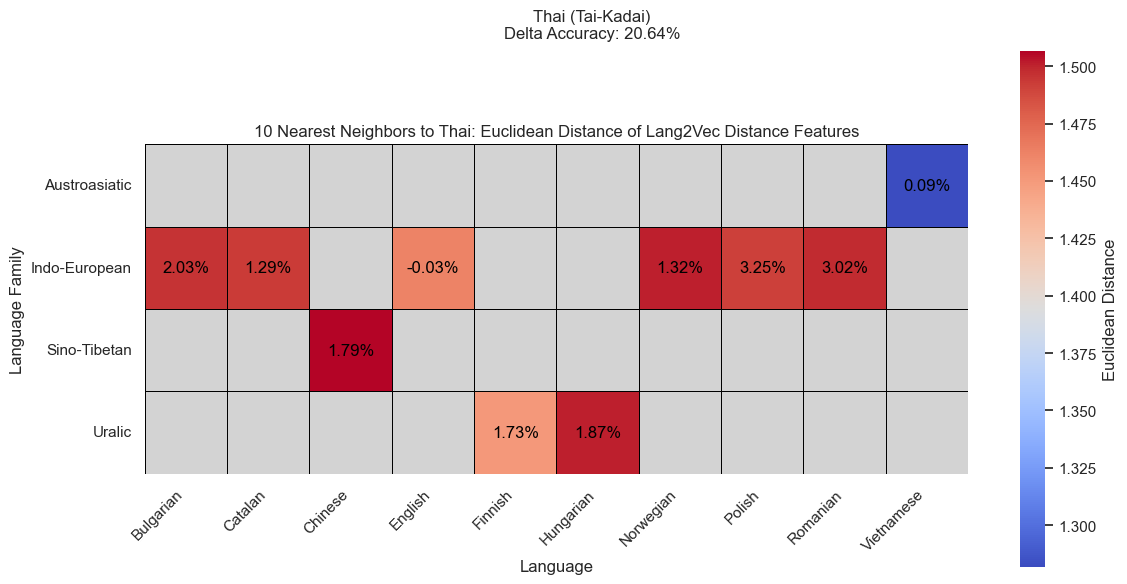

In [49]:
# Combine the distance and delta accuracy data into a single dataframe
heatmap_data = pd.merge(similar_languages[['language', 'distance_to_thai']], average_delta_accuracy[['language', 'delta_accuracy']], on='language')

# Add language family information to the heatmap_data dataframe
language_families = {
    'Thai': 'Tai-Kadai',
    'Vietnamese': 'Austroasiatic',
    'Finnish': 'Uralic',
    'English': 'Indo-European',
    'Polish': 'Indo-European',
    'Catalan': 'Indo-European',
    'Bulgarian': 'Indo-European',
    'Romanian': 'Indo-European',
    'Hungarian': 'Uralic',
    'Norwegian': 'Indo-European',
    'Chinese': 'Sino-Tibetan'
}
heatmap_data['language_family'] = heatmap_data['language'].map(language_families)

# Get Thai's delta accuracy
thai_delta_accuracy = heatmap_data[heatmap_data['language'] == 'Thai']['delta_accuracy'].values[0]

# Remove Thai from the heatmap data
heatmap_data = heatmap_data[heatmap_data['language'] != 'Thai']

# Sort the dataframe by language family and distance to Thai
heatmap_data = heatmap_data.sort_values(['language_family', 'distance_to_thai'])

# Create a pivot table with language families as rows and languages as columns
heatmap_pivot = heatmap_data.pivot(index='language_family', columns='language', values='distance_to_thai')

# Create a custom colormap with a simple blue to red color scheme
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad('lightgray')

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, annot=False, cmap=cmap, cbar_kws={'label': 'Euclidean Distance'}, square=True,
            linewidths=0.5, linecolor='black', mask=heatmap_pivot.isnull())

# Add delta accuracy values as percentages inside each square
for i in range(heatmap_pivot.shape[0]):
    for j in range(heatmap_pivot.shape[1]):
        language = heatmap_pivot.columns[j]
        if not pd.isnull(heatmap_pivot.iloc[i, j]):
            delta_accuracy = heatmap_data[heatmap_data['language'] == language]['delta_accuracy'].values[0]
            plt.text(j + 0.5, i + 0.5, f'{delta_accuracy*100:.2f}%', ha='center', va='center', color='black', fontsize=12)

# Adjust the plot layout
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.title('10 Nearest Neighbors to Thai: Euclidean Distance of Lang2Vec Distance Features')
plt.xlabel('Language')
plt.ylabel('Language Family')

# Add Thai's delta accuracy below the title with reduced vertical gap
plt.suptitle(f"Thai (Tai-Kadai)\nDelta Accuracy: {thai_delta_accuracy*100:.2f}%", fontsize=12, y=0.99)

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust the top spacing to minimize the gap
plt.show()

In [50]:
delta_accuracy_df

model                        method    language  seed  accuracy  \
3478  distilMBERT              Before FastAlign   Bulgarian    17  0.872043   
3479  distilMBERT                Before Awesome   Bulgarian    17  0.875413   
3480  distilMBERT                   Before Dict   Bulgarian    17  0.873633   
3481  distilMBERT              During FastAlign   Bulgarian    17  0.864793   
3482  distilMBERT                During Awesome   Bulgarian    17  0.867973   
...           ...                           ...         ...   ...       ...   
6835  distilMBERT   During Front Freeze Awesome  Vietnamese    66  0.585027   
6836  distilMBERT      During Front Freeze Dict  Vietnamese    66  0.591133   
6837  distilMBERT  During Back Freeze FastAlign  Vietnamese    66  0.566123   
6838  distilMBERT    During Back Freeze Awesome  Vietnamese    66  0.569218   
6839  distilMBERT       During Back Freeze Dict  Vietnamese    66  0.586951   

      delta_accuracy  syntactic  geographic  phonological  genetic  inventory  \
3478        0.015390       0.48         0.1        0.2804   0.8571      0.521   
3479        0.018761       0.48         0.1        0.2804   0.8571      0.521   
3480        0.016980       0.48         0.1        0.2804   0.8571      0.521   
3481        0.008140       0.48         0.1        0.2804   0.8571      0.521   
3482        0.011320       0.48         0.1        0.2804   0.8571      0.521   
...              ...        ...         ...           ...      ...        ...   
6835        0.004935       0.57         0.5        0.4270   1.0000      0.455   
6836        0.011041       0.57         0.5        0.4270   1.0000      0.455   
6837       -0.013969       0.57         0.5        0.4270   1.0000      0.455   
6838       -0.010874       0.57         0.5        0.4270   1.0000      0.455   
6839        0.006859       0.57         0.5        0.4270   1.0000      0.455   

      featural method_type  
3478       0.5     vanilla  
3479       0.5     vanilla  
3480       0.5     vanilla  
3481       0.5     vanilla  
3482       0.5     vanilla  
...        ...         ...  
6835       0.5      freeze  
6836       0.5      freeze  
6837       0.5      freeze  
6838       0.5      freeze  
6839       0.5      freeze  

[990 rows x 13 columns]

In [51]:
nli_csv_path = './distilMBERT_nli_data/distilbert-base-multilingual-cased__xnli__opus100.csv'

nli_df = read_and_process_csv(nli_csv_path, model_name='distilMBERT')
nli_df = nli_df[~nli_df.isna().any(axis=1)]

In [52]:
nli_df

model                     method    language  seed  accuracy
0    distilMBERT           Before FastAlign     English    31  0.773852
1    distilMBERT           Before FastAlign     Average    31  0.636810
2    distilMBERT           Before FastAlign      Arabic    31  0.618363
3    distilMBERT           Before FastAlign   Bulgarian    31  0.656287
4    distilMBERT           Before FastAlign      German    31  0.672455
..           ...                        ...         ...   ...       ...
842  distilMBERT  Before - Back Freeze Dict     Russian    17  0.635729
843  distilMBERT  Before - Back Freeze Dict        Thai    17  0.505389
844  distilMBERT  Before - Back Freeze Dict     Turkish    17  0.615569
845  distilMBERT  Before - Back Freeze Dict  Vietnamese    17  0.657086
846  distilMBERT  Before - Back Freeze Dict     Chinese    17  0.643114

[700 rows x 5 columns]

In [53]:
nli_df['method'].value_counts()

method
Before FastAlign                   70
Before Awesome                     70
Before Dict                        70
Before - Front Freeze FastAlign    70
Before - Front Freeze Awesome      70
Before - Front Freeze Dict         70
Fine-tuning Only                   70
Before - Back Freeze FastAlign     70
Before - Back Freeze Awesome       70
Before - Back Freeze Dict          70
Name: count, dtype: int64

In [54]:
processed_nli_df = process_dataframe(nli_df, group_by_columns=['model', 'seed', 'language'])

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


In [55]:
processed_nli_df

model                           method    language  seed  accuracy  \
0    distilMBERT                 Fine-tuning Only      Arabic    17  0.597206   
1    distilMBERT                 Before FastAlign      Arabic    17  0.611377   
2    distilMBERT                   Before Awesome      Arabic    17  0.619361   
3    distilMBERT                      Before Dict      Arabic    17  0.598603   
4    distilMBERT  Before - Front Freeze FastAlign      Arabic    17  0.592415   
..           ...                              ...         ...   ...       ...   
695  distilMBERT    Before - Front Freeze Awesome  Vietnamese    66  0.656886   
696  distilMBERT       Before - Front Freeze Dict  Vietnamese    66  0.661078   
697  distilMBERT   Before - Back Freeze FastAlign  Vietnamese    66  0.657485   
698  distilMBERT     Before - Back Freeze Awesome  Vietnamese    66  0.663673   
699  distilMBERT        Before - Back Freeze Dict  Vietnamese    66  0.663074   

     delta_accuracy  
0               NaN  
1          0.014172  
2          0.022156  
3          0.001397  
4         -0.004790  
..              ...  
695        0.098403  
696        0.102595  
697        0.099002  
698        0.105190  
699        0.104591  

[700 rows x 6 columns]

In [56]:
processed_nli_df[(processed_nli_df['language'] == 'Chinese') & (processed_nli_df['seed'] == 17)]

model                           method language  seed  accuracy  \
30  distilMBERT                 Fine-tuning Only  Chinese    17  0.647705   
31  distilMBERT                 Before FastAlign  Chinese    17  0.647106   
32  distilMBERT                   Before Awesome  Chinese    17  0.650499   
33  distilMBERT                      Before Dict  Chinese    17  0.643114   
34  distilMBERT  Before - Front Freeze FastAlign  Chinese    17  0.661078   
35  distilMBERT    Before - Front Freeze Awesome  Chinese    17  0.650299   
36  distilMBERT       Before - Front Freeze Dict  Chinese    17  0.651497   
37  distilMBERT   Before - Back Freeze FastAlign  Chinese    17  0.647106   
38  distilMBERT     Before - Back Freeze Awesome  Chinese    17  0.650499   
39  distilMBERT        Before - Back Freeze Dict  Chinese    17  0.643114   

    delta_accuracy  
30             NaN  
31       -0.000599  
32        0.002794  
33       -0.004591  
34        0.013373  
35        0.002595  
36        0.003792  
37       -0.000599  
38        0.002794  
39       -0.004591

In [57]:
processed_nli_df = processed_nli_df[~processed_nli_df.isna().any(axis=1)]

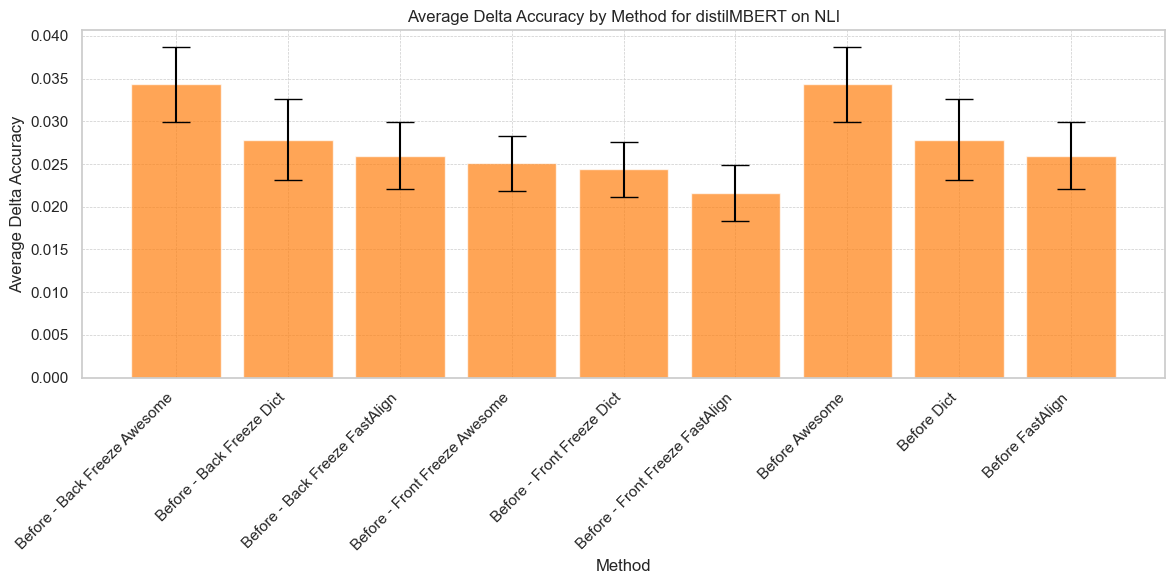

In [58]:
# Calculate average and standard error of delta accuracy grouped by method
average_delta_accuracy = processed_nli_df.groupby('method')['delta_accuracy'].agg(['mean', 'sem']).reset_index()

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create the x-axis positions
x_pos = np.arange(len(average_delta_accuracy))

# Define the color for distilMBERT
distilMBERT_color = '#ff7f0e'

# Plot bars for each method
ax.bar(x_pos, average_delta_accuracy['mean'], yerr=average_delta_accuracy['sem'], align='center', alpha=0.7, ecolor='black', capsize=10, color=distilMBERT_color)

# Set the x-axis tick positions and labels
ax.set_xticks(x_pos)
ax.set_xticklabels([method.replace('_', ' ') for method in average_delta_accuracy['method']], rotation=45, ha='right')

# Set the plot title and labels
ax.set_title('Average Delta Accuracy by Method for distilMBERT on NLI')
ax.set_xlabel('Method')
ax.set_ylabel('Average Delta Accuracy')

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [59]:
nli_train_data, nli_val_data, nli_test_data = split_train_val_test(processed_nli_df, use_standard_split=True)

In [60]:
nli_train_data

model                           method    language  delta_accuracy
0    distilMBERT     Before - Back Freeze Awesome     Russian        0.013573
1    distilMBERT    Before - Front Freeze Awesome   Bulgarian        0.028942
2    distilMBERT                 Before FastAlign  Vietnamese        0.058283
3    distilMBERT                   Before Awesome      French       -0.007784
4    distilMBERT                 Before FastAlign       Hindi        0.030739
..           ...                              ...         ...             ...
435  distilMBERT        Before - Back Freeze Dict       Greek        0.028543
436  distilMBERT     Before - Back Freeze Awesome        Thai        0.134731
437  distilMBERT                 Before FastAlign   Bulgarian        0.021357
438  distilMBERT  Before - Front Freeze FastAlign      German        0.019361
439  distilMBERT  Before - Front Freeze FastAlign        Thai        0.064671

[440 rows x 4 columns]

In [61]:
nli_val_data

model                           method    language  delta_accuracy
0   distilMBERT                 Before FastAlign  Vietnamese        0.118563
1   distilMBERT   Before - Back Freeze FastAlign     Russian        0.014770
2   distilMBERT                 Before FastAlign     Russian        0.008383
3   distilMBERT                 Before FastAlign     Average        0.036560
4   distilMBERT  Before - Front Freeze FastAlign     Turkish        0.029741
..          ...                              ...         ...             ...
58  distilMBERT                      Before Dict        Thai        0.157485
59  distilMBERT                 Before FastAlign     English       -0.001198
60  distilMBERT                      Before Dict     Chinese       -0.004591
61  distilMBERT   Before - Back Freeze FastAlign  Vietnamese        0.069062
62  distilMBERT                      Before Dict       Hindi        0.032136

[63 rows x 4 columns]

In [62]:
nli_test_data

model                           method language  delta_accuracy
0    distilMBERT    Before - Front Freeze Awesome  Spanish        0.002395
1    distilMBERT     Before - Back Freeze Awesome   French        0.002595
2    distilMBERT     Before - Back Freeze Awesome  English        0.002794
3    distilMBERT    Before - Front Freeze Awesome  Average        0.027861
4    distilMBERT   Before - Back Freeze FastAlign   French       -0.017166
..           ...                              ...      ...             ...
122  distilMBERT       Before - Front Freeze Dict  Russian        0.008982
123  distilMBERT                   Before Awesome    Hindi        0.036128
124  distilMBERT  Before - Front Freeze FastAlign  Russian        0.010579
125  distilMBERT        Before - Back Freeze Dict  Russian        0.001996
126  distilMBERT   Before - Back Freeze FastAlign  Average        0.023353

[127 rows x 4 columns]

100%|██████████| 59/59 [00:00<00:00, 400.46it/s]



Final Test MSE for  (Random Forest): 0.00010245675769434442


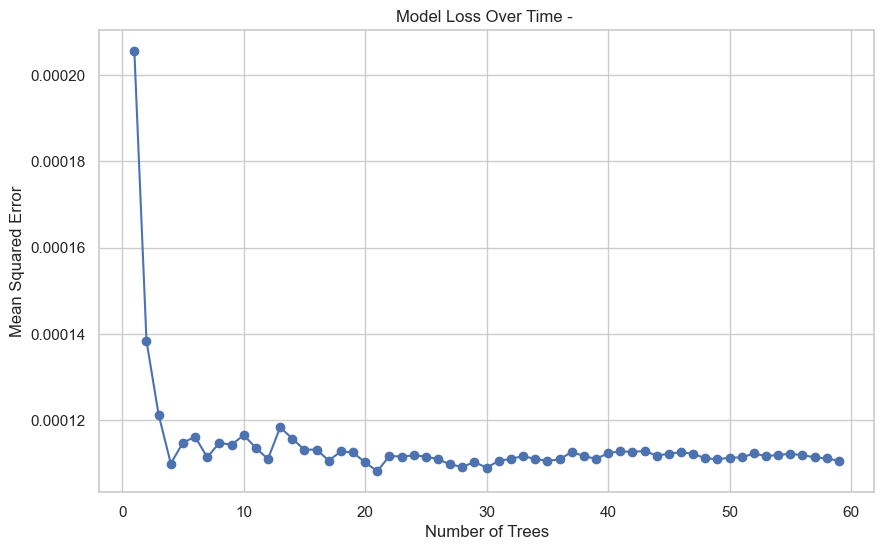

Calculating SHAP values: 100%|██████████| 440/440 [00:00<00:00, 576.37it/s]


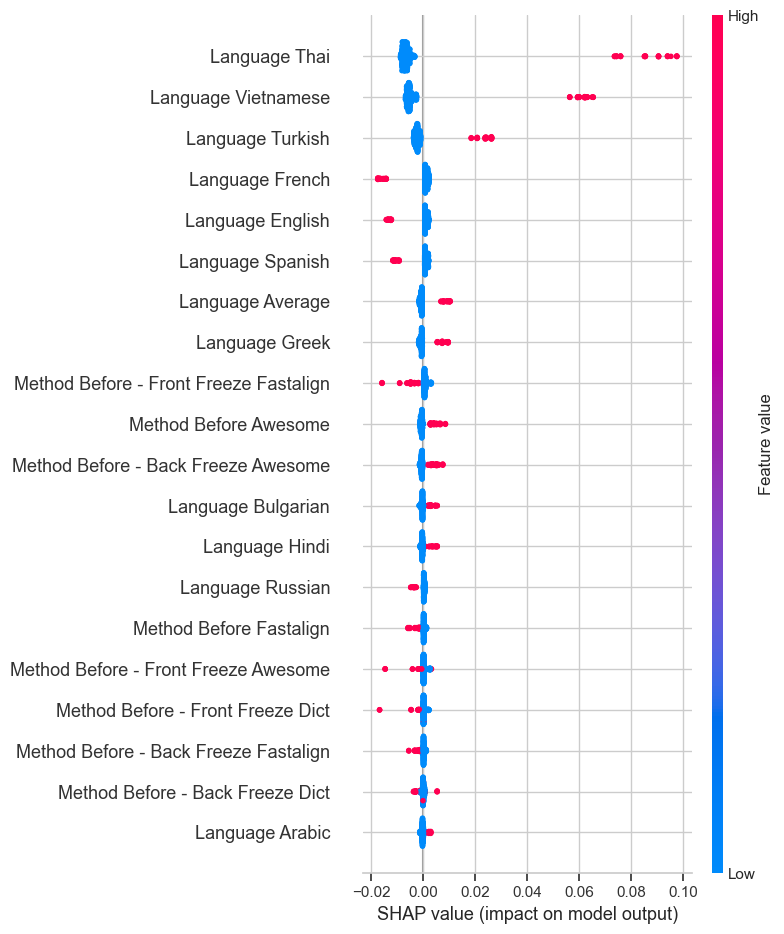

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


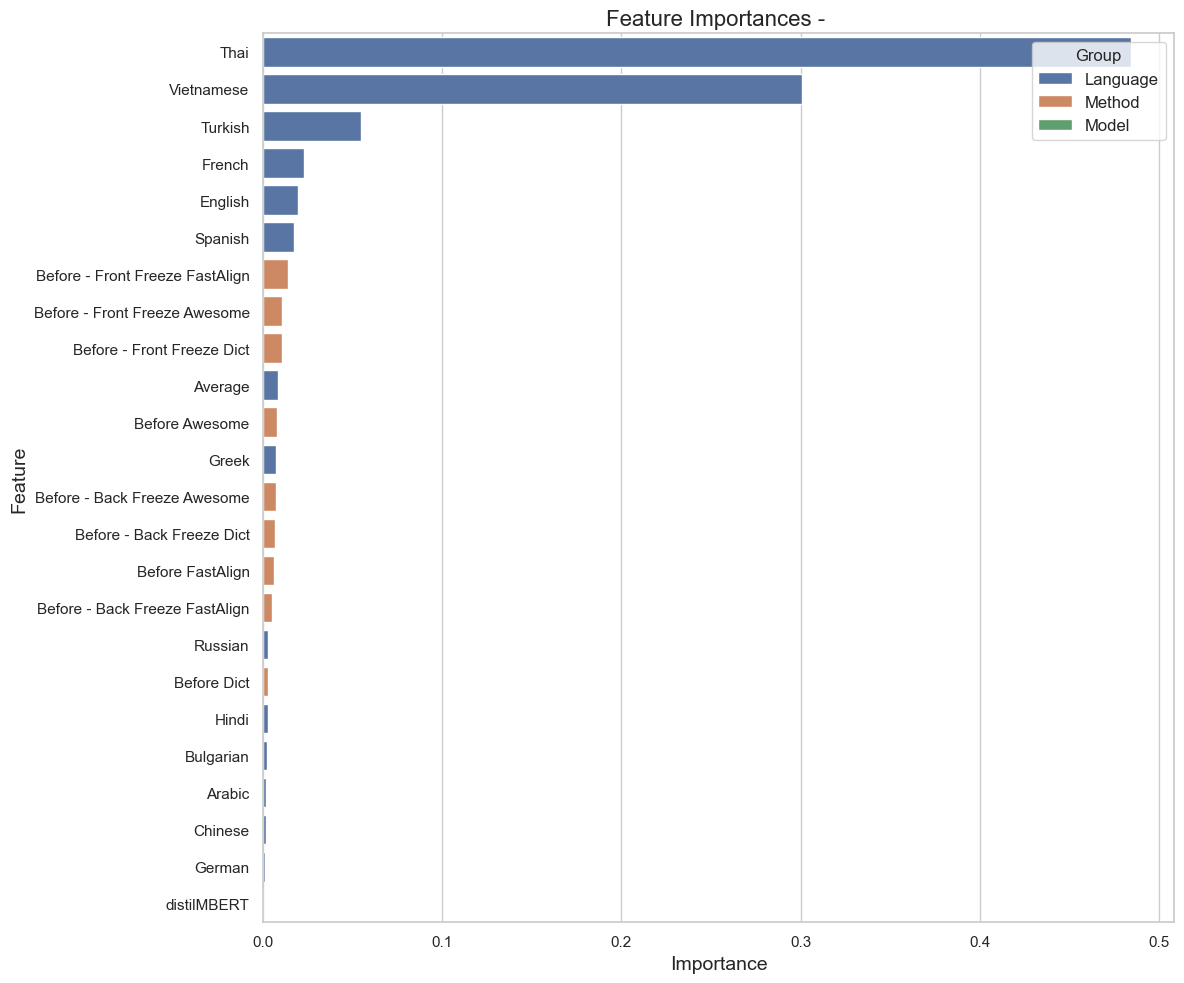

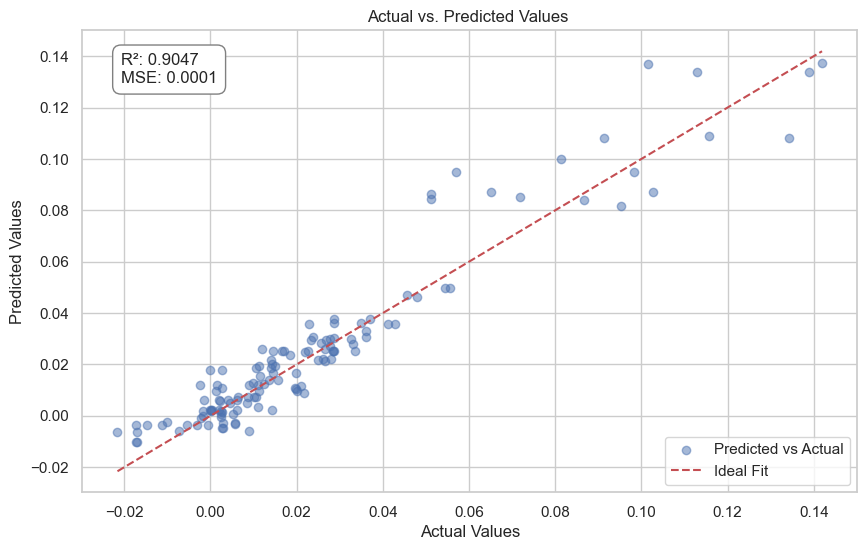

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


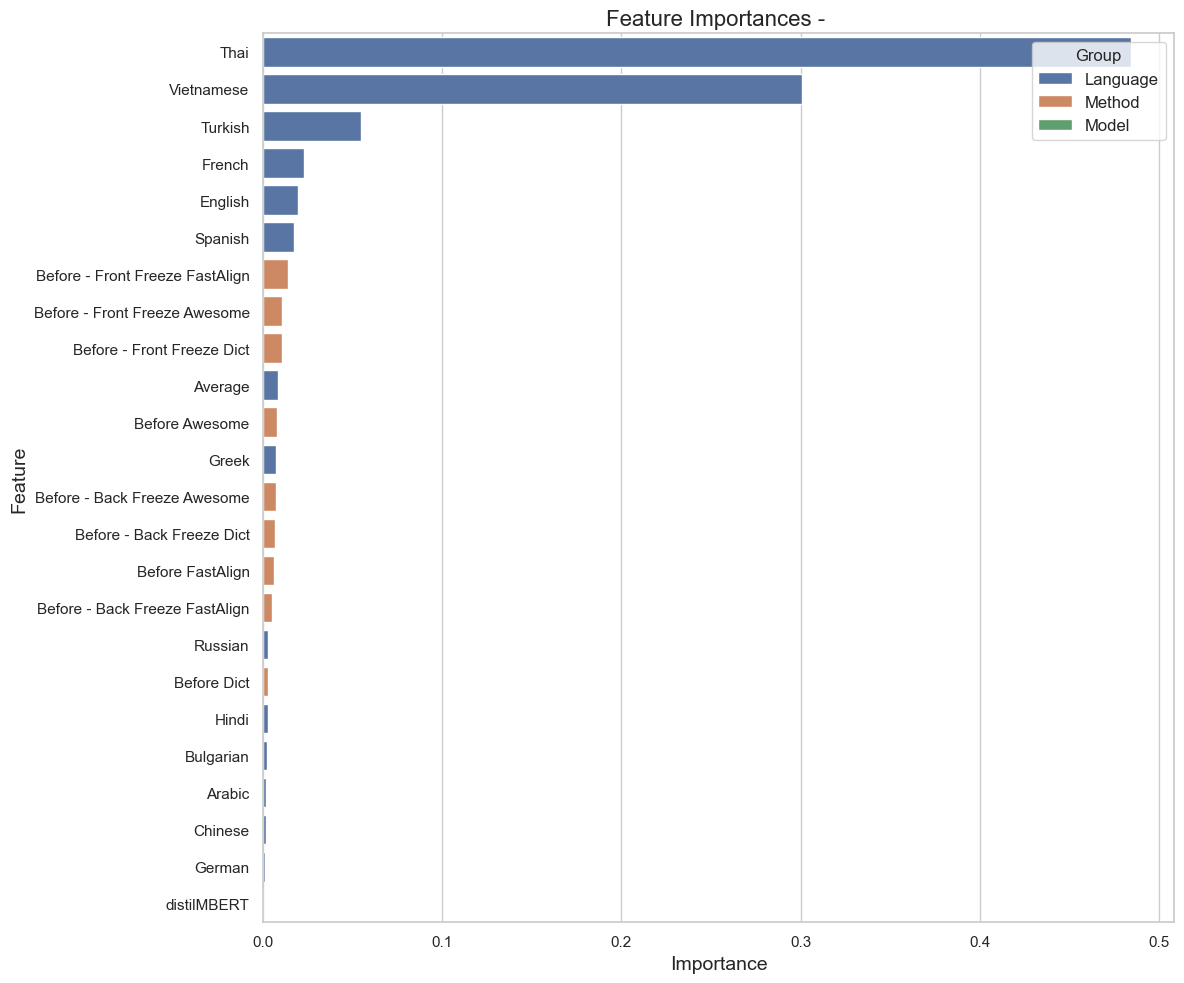

In [63]:
nli_coefficients, nli_encoded_columns = perform_regression(nli_train_data, nli_val_data, nli_test_data)

plot_feature_importances(nli_coefficients, nli_encoded_columns)

In [64]:
processed_nli_df_with_distances = add_language_distances_to_df(processed_nli_df)

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4091662537.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.nan
C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4091662537.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.nan
C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4091662537.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Error: Average is not in the language mapping.


In [65]:
processed_nli_df_with_distances

model                           method    language  seed  accuracy  \
1    distilMBERT                 Before FastAlign      Arabic    17  0.611377   
2    distilMBERT                   Before Awesome      Arabic    17  0.619361   
3    distilMBERT                      Before Dict      Arabic    17  0.598603   
4    distilMBERT  Before - Front Freeze FastAlign      Arabic    17  0.592415   
5    distilMBERT    Before - Front Freeze Awesome      Arabic    17  0.602794   
..           ...                              ...         ...   ...       ...   
695  distilMBERT    Before - Front Freeze Awesome  Vietnamese    66  0.656886   
696  distilMBERT       Before - Front Freeze Dict  Vietnamese    66  0.661078   
697  distilMBERT   Before - Back Freeze FastAlign  Vietnamese    66  0.657485   
698  distilMBERT     Before - Back Freeze Awesome  Vietnamese    66  0.663673   
699  distilMBERT        Before - Back Freeze Dict  Vietnamese    66  0.663074   

     delta_accuracy  syntactic  geographic  phonological  genetic  inventory  \
1          0.014172       0.67         0.2        0.5687      1.0     0.5983   
2          0.022156       0.67         0.2        0.5687      1.0     0.5983   
3          0.001397       0.67         0.2        0.5687      1.0     0.5983   
4         -0.004790       0.67         0.2        0.5687      1.0     0.5983   
5          0.005589       0.67         0.2        0.5687      1.0     0.5983   
..              ...        ...         ...           ...      ...        ...   
695        0.098403       0.57         0.5        0.4270      1.0     0.4550   
696        0.102595       0.57         0.5        0.4270      1.0     0.4550   
697        0.099002       0.57         0.5        0.4270      1.0     0.4550   
698        0.105190       0.57         0.5        0.4270      1.0     0.4550   
699        0.104591       0.57         0.5        0.4270      1.0     0.4550   

     featural  
1         0.8  
2         0.8  
3         0.8  
4         0.8  
5         0.8  
..        ...  
695       0.5  
696       0.5  
697       0.5  
698       0.5  
699       0.5  

[630 rows x 12 columns]

In [66]:
processed_nli_df_with_distances = processed_nli_df_with_distances[~processed_nli_df_with_distances.isna().any(axis=1)]

In [67]:
nli_train_data, nli_val_data, nli_test_data = split_train_val_test(processed_nli_df_with_distances, use_standard_split=True)

In [68]:
nli_train_data

model                           method   language  delta_accuracy  \
0    distilMBERT     Before - Back Freeze Awesome  Bulgarian        0.016567   
1    distilMBERT        Before - Back Freeze Dict     German        0.009581   
2    distilMBERT  Before - Front Freeze FastAlign    English       -0.005389   
3    distilMBERT                   Before Awesome  Bulgarian        0.028543   
4    distilMBERT   Before - Back Freeze FastAlign      Hindi        0.016766   
..           ...                              ...        ...             ...   
404  distilMBERT        Before - Back Freeze Dict      Hindi        0.032335   
405  distilMBERT     Before - Back Freeze Awesome    Turkish        0.051896   
406  distilMBERT                 Before FastAlign     French       -0.006387   
407  distilMBERT  Before - Front Freeze FastAlign    Spanish       -0.013772   
408  distilMBERT  Before - Front Freeze FastAlign    Turkish        0.023952   

     syntactic  geographic  phonological  genetic  inventory  featural  
0         0.48         0.1        0.2804   0.8571     0.5210       0.5  
1         0.42         0.1        0.3277   0.4286     0.4364       0.4  
2         0.00         0.0        0.0002   0.0000     0.0000       0.0  
3         0.48         0.1        0.2804   0.8571     0.5210       0.5  
4         0.59         0.4        0.3433   0.9000     0.4684       0.5  
..         ...         ...           ...      ...        ...       ...  
404       0.59         0.4        0.3433   0.9000     0.4684       0.5  
405       0.70         0.1        0.3433   1.0000     0.5183       0.6  
406       0.46         0.0        0.4270   0.9000     0.4753       0.5  
407       0.40         0.1        0.3433   0.9000     0.5481       0.5  
408       0.70         0.1        0.3433   1.0000     0.5183       0.6  

[409 rows x 10 columns]

In [69]:
nli_val_data

model                           method    language  delta_accuracy  \
0   distilMBERT    Before - Front Freeze Awesome     Spanish        0.002395   
1   distilMBERT  Before - Front Freeze FastAlign       Greek        0.024551   
2   distilMBERT   Before - Back Freeze FastAlign     Russian        0.008383   
3   distilMBERT                   Before Awesome     Spanish        0.011377   
4   distilMBERT   Before - Back Freeze FastAlign      Arabic        0.014172   
5   distilMBERT                 Before FastAlign     English       -0.001597   
6   distilMBERT                   Before Awesome   Bulgarian        0.021357   
7   distilMBERT                   Before Awesome     English        0.002395   
8   distilMBERT                      Before Dict   Bulgarian        0.029341   
9   distilMBERT    Before - Front Freeze Awesome     English        0.002595   
10  distilMBERT                      Before Dict       Greek        0.036926   
11  distilMBERT                   Before Awesome      Arabic        0.033134   
12  distilMBERT    Before - Front Freeze Awesome     Russian        0.019162   
13  distilMBERT   Before - Back Freeze FastAlign       Greek        0.015968   
14  distilMBERT     Before - Back Freeze Awesome      French        0.002994   
15  distilMBERT   Before - Back Freeze FastAlign   Bulgarian        0.023553   
16  distilMBERT    Before - Front Freeze Awesome       Hindi        0.005988   
17  distilMBERT       Before - Front Freeze Dict     Spanish        0.004591   
18  distilMBERT  Before - Front Freeze FastAlign     Chinese        0.014172   
19  distilMBERT   Before - Back Freeze FastAlign   Bulgarian        0.013972   
20  distilMBERT       Before - Front Freeze Dict     Turkish        0.039721   
21  distilMBERT       Before - Front Freeze Dict      French        0.004790   
22  distilMBERT                      Before Dict      French       -0.016966   
23  distilMBERT     Before - Back Freeze Awesome     Spanish        0.011377   
24  distilMBERT    Before - Front Freeze Awesome     Chinese        0.002595   
25  distilMBERT    Before - Front Freeze Awesome      Arabic        0.019760   
26  distilMBERT  Before - Front Freeze FastAlign     English       -0.011178   
27  distilMBERT     Before - Back Freeze Awesome     Russian        0.012774   
28  distilMBERT    Before - Front Freeze Awesome     Russian        0.012176   
29  distilMBERT                      Before Dict     Turkish        0.045709   
30  distilMBERT  Before - Front Freeze FastAlign  Vietnamese        0.054092   
31  distilMBERT                   Before Awesome     Turkish        0.055489   
32  distilMBERT                      Before Dict     English       -0.003992   
33  distilMBERT    Before - Front Freeze Awesome      French        0.000599   
34  distilMBERT                      Before Dict        Thai        0.157485   
35  distilMBERT                      Before Dict       Greek        0.039721   
36  distilMBERT                 Before FastAlign  Vietnamese        0.058283   
37  distilMBERT     Before - Back Freeze Awesome      German        0.015369   
38  distilMBERT                      Before Dict     Chinese       -0.000998   
39  distilMBERT                      Before Dict     Turkish        0.046307   
40  distilMBERT        Before - Back Freeze Dict       Hindi        0.032136   
41  distilMBERT                 Before FastAlign     Russian        0.008383   
42  distilMBERT        Before - Back Freeze Dict  Vietnamese        0.064671   
43  distilMBERT       Before - Front Freeze Dict       Hindi        0.021956   
44  distilMBERT    Before - Front Freeze Awesome  Vietnamese        0.111776   
45  distilMBERT  Before - Front Freeze FastAlign     Spanish        0.009980   
46  distilMBERT  Before - Front Freeze FastAlign       Greek        0.025349   
47  distilMBERT                      Before Dict   Bulgarian        0.026547   
48  distilMBERT     Before - Back Freeze Awesome     Spanish        0.004391   
49  distil

In [70]:
nli_test_data

model                          method language  delta_accuracy  \
0    distilMBERT                  Before Awesome    Hindi        0.033533   
1    distilMBERT  Before - Back Freeze FastAlign   Arabic        0.018164   
2    distilMBERT  Before - Back Freeze FastAlign  English       -0.009980   
3    distilMBERT                     Before Dict   French       -0.002994   
4    distilMBERT      Before - Front Freeze Dict    Hindi        0.032934   
..           ...                             ...      ...             ...   
113  distilMBERT    Before - Back Freeze Awesome    Hindi        0.023752   
114  distilMBERT      Before - Front Freeze Dict    Greek        0.037924   
115  distilMBERT   Before - Front Freeze Awesome   Arabic        0.022156   
116  distilMBERT                     Before Dict    Hindi        0.021956   
117  distilMBERT   Before - Front Freeze Awesome  Chinese        0.022156   

     syntactic  geographic  phonological  genetic  inventory  featural  
0         0.59         0.4        0.3433   0.9000     0.4684       0.5  
1         0.67         0.2        0.5687   1.0000     0.5983       0.8  
2         0.00         0.0        0.0002   0.0000     0.0000       0.0  
3         0.46         0.0        0.4270   0.9000     0.4753       0.5  
4         0.59         0.4        0.3433   0.9000     0.4684       0.5  
..         ...         ...           ...      ...        ...       ...  
113       0.59         0.4        0.3433   0.9000     0.4684       0.5  
114       0.52         0.1        0.1950   0.8333     0.5516       0.5  
115       0.67         0.2        0.5687   1.0000     0.5983       0.8  
116       0.59         0.4        0.3433   0.9000     0.4684       0.5  
117       0.55         0.4        0.3900   1.0000     0.5926       0.6  

[118 rows x 10 columns]

100%|██████████| 59/59 [00:00<00:00, 340.54it/s]



Final Test MSE for  (Random Forest): 0.0001665818035496873


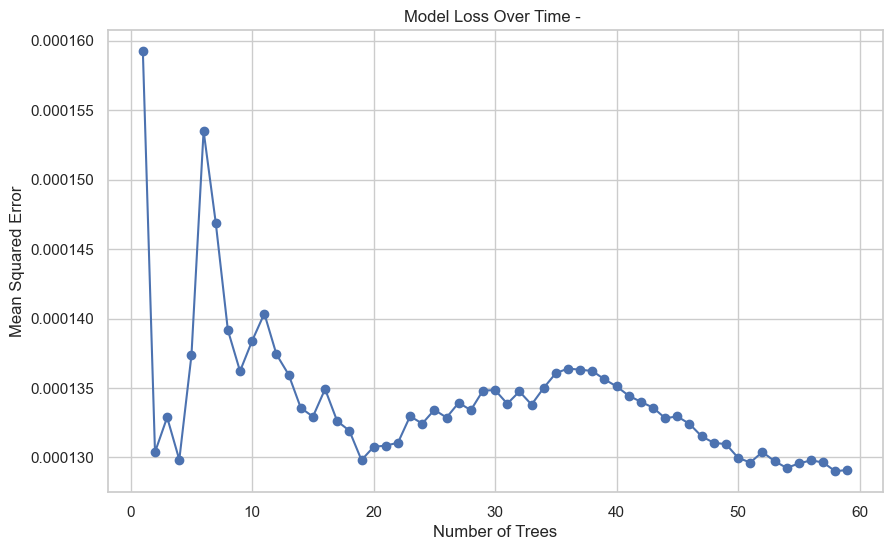

Calculating SHAP values: 100%|██████████| 409/409 [00:00<00:00, 576.83it/s]


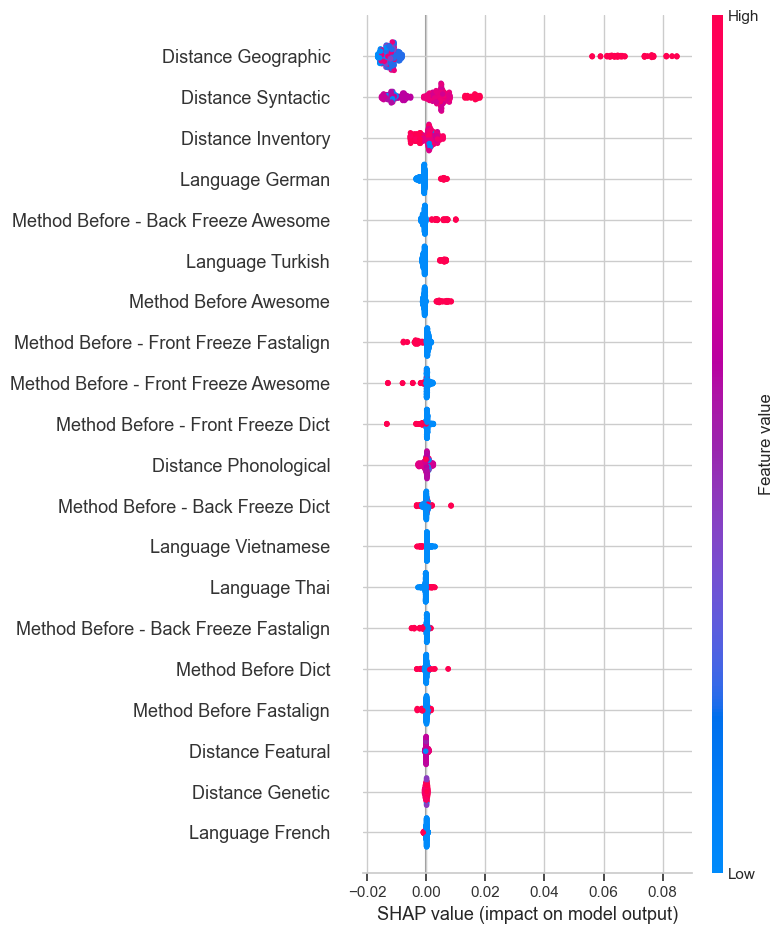

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


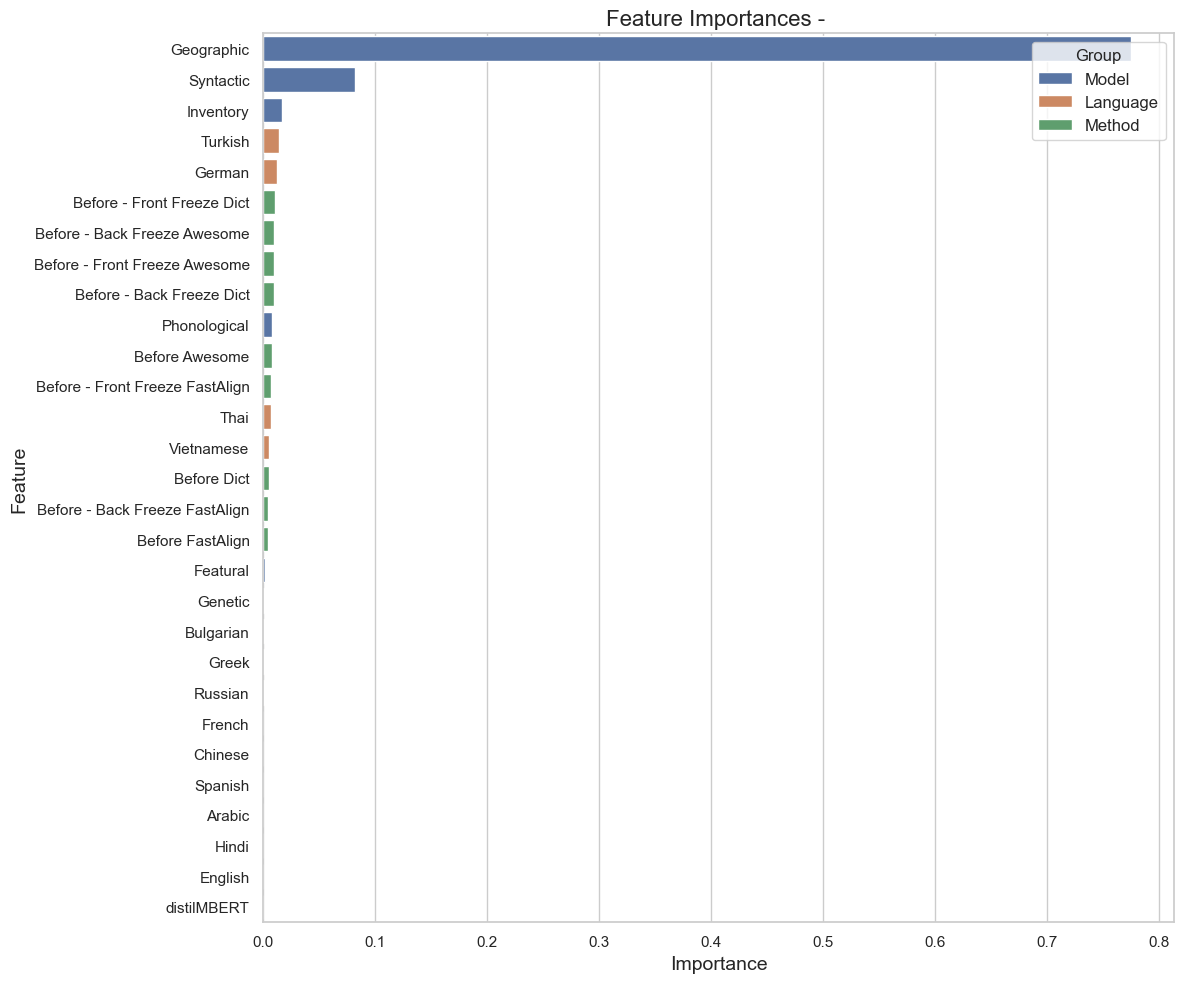

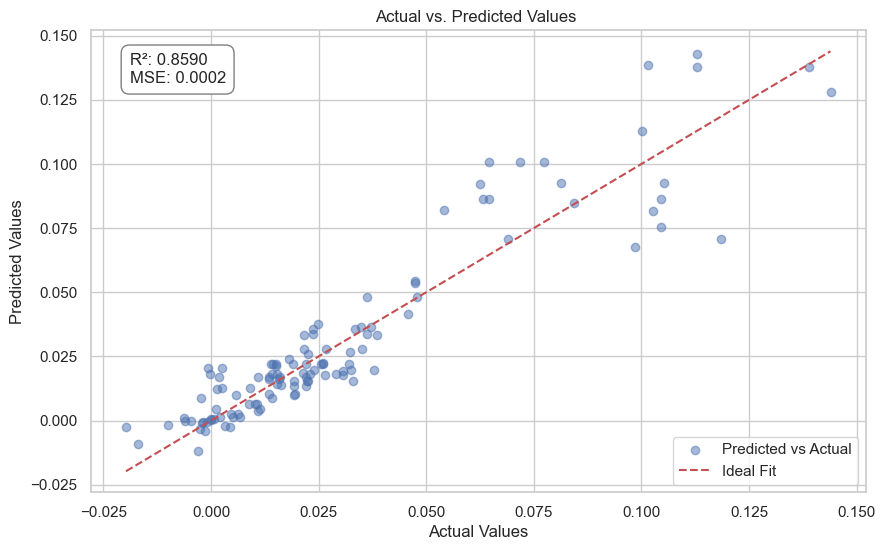

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


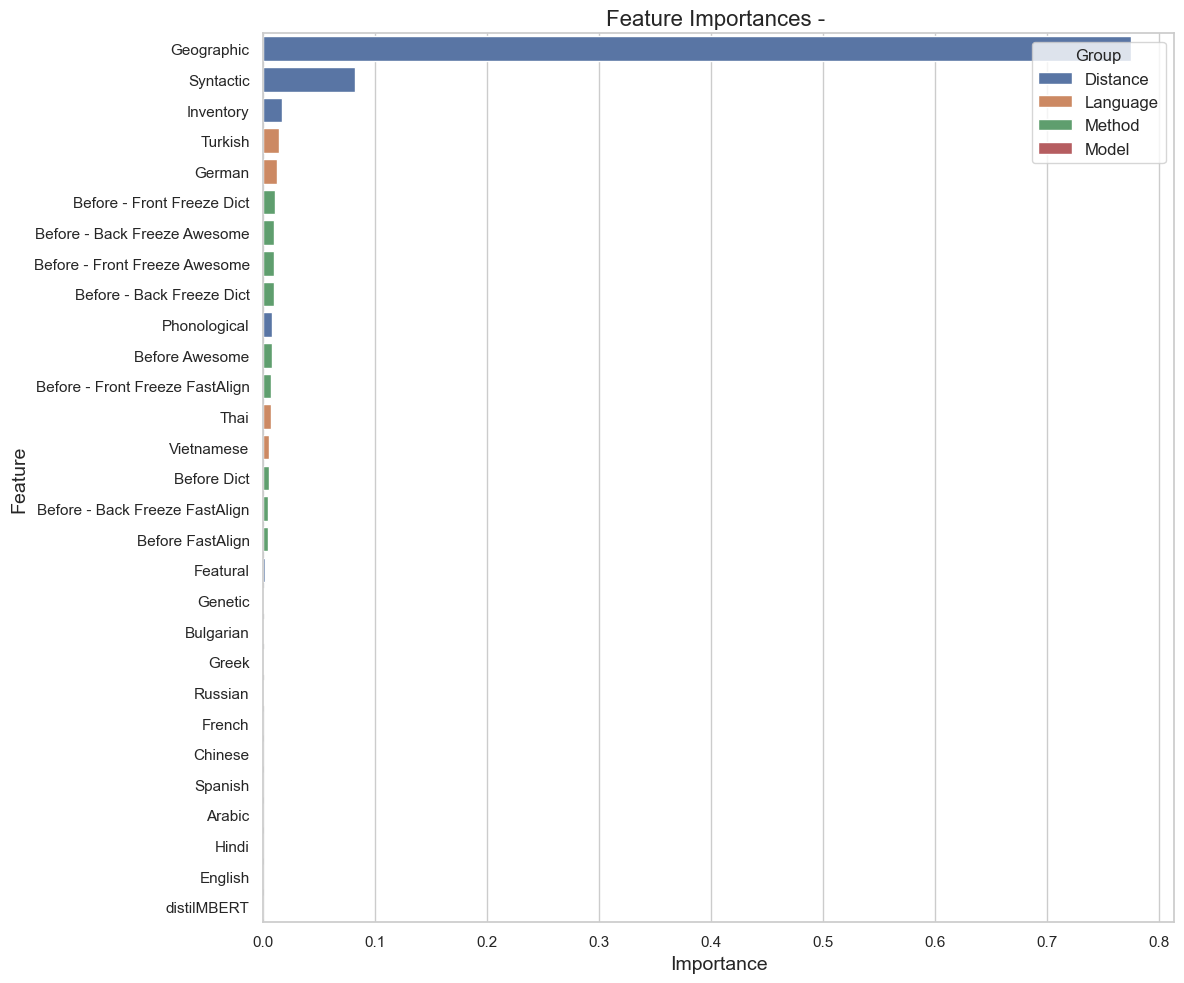

In [71]:
nli_dist_coefficients, nli_dist_encoded_columns = perform_regression(nli_train_data, nli_val_data, nli_test_data)

plot_feature_importances(nli_dist_coefficients, nli_dist_encoded_columns, group_by_distance=True)

In [72]:
nli_df_flagged = flag_freeze_methods(processed_nli_df_with_distances)

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\328518364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['method_type'] = df[method_col].apply(lambda x: 'freeze' if 'freeze' in x.lower() else 'vanilla')


In [73]:
nli_df_flagged = nli_df_flagged[~nli_df_flagged.isna().any(axis=1)]
nli_df_flagged

model                           method    language  seed  accuracy  \
1    distilMBERT                 Before FastAlign      Arabic    17  0.611377   
2    distilMBERT                   Before Awesome      Arabic    17  0.619361   
3    distilMBERT                      Before Dict      Arabic    17  0.598603   
4    distilMBERT  Before - Front Freeze FastAlign      Arabic    17  0.592415   
5    distilMBERT    Before - Front Freeze Awesome      Arabic    17  0.602794   
..           ...                              ...         ...   ...       ...   
695  distilMBERT    Before - Front Freeze Awesome  Vietnamese    66  0.656886   
696  distilMBERT       Before - Front Freeze Dict  Vietnamese    66  0.661078   
697  distilMBERT   Before - Back Freeze FastAlign  Vietnamese    66  0.657485   
698  distilMBERT     Before - Back Freeze Awesome  Vietnamese    66  0.663673   
699  distilMBERT        Before - Back Freeze Dict  Vietnamese    66  0.663074   

     delta_accuracy  syntactic  geographic  phonological  genetic  inventory  \
1          0.014172       0.67         0.2        0.5687      1.0     0.5983   
2          0.022156       0.67         0.2        0.5687      1.0     0.5983   
3          0.001397       0.67         0.2        0.5687      1.0     0.5983   
4         -0.004790       0.67         0.2        0.5687      1.0     0.5983   
5          0.005589       0.67         0.2        0.5687      1.0     0.5983   
..              ...        ...         ...           ...      ...        ...   
695        0.098403       0.57         0.5        0.4270      1.0     0.4550   
696        0.102595       0.57         0.5        0.4270      1.0     0.4550   
697        0.099002       0.57         0.5        0.4270      1.0     0.4550   
698        0.105190       0.57         0.5        0.4270      1.0     0.4550   
699        0.104591       0.57         0.5        0.4270      1.0     0.4550   

     featural method_type  
1         0.8     vanilla  
2         0.8     vanilla  
3         0.8     vanilla  
4         0.8      freeze  
5         0.8      freeze  
..        ...         ...  
695       0.5      freeze  
696       0.5      freeze  
697       0.5      freeze  
698       0.5      freeze  
699       0.5      freeze  

[585 rows x 13 columns]

Using all data



100%|██████████| 59/59 [00:00<00:00, 348.41it/s]


Final Test MSE for Using all data (Random Forest): 0.0001665818035496873


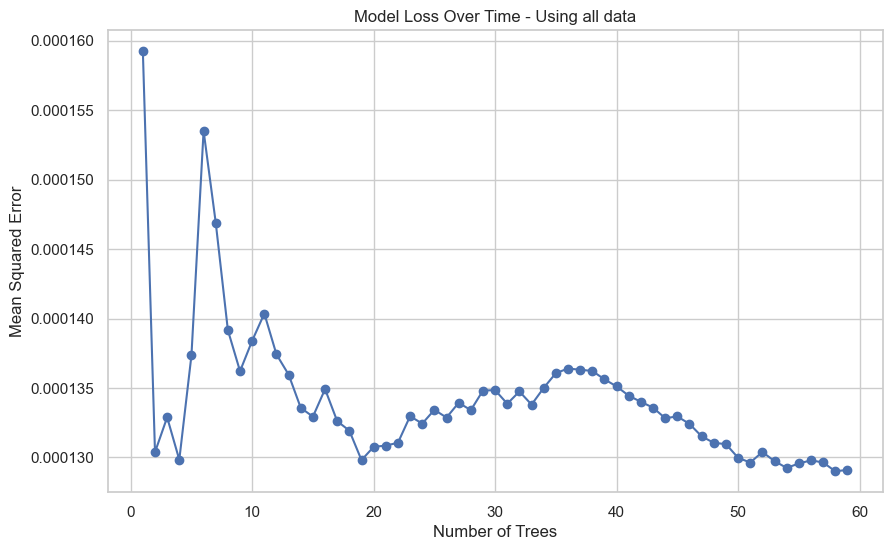

Calculating SHAP values: 100%|██████████| 409/409 [00:00<00:00, 572.92it/s]


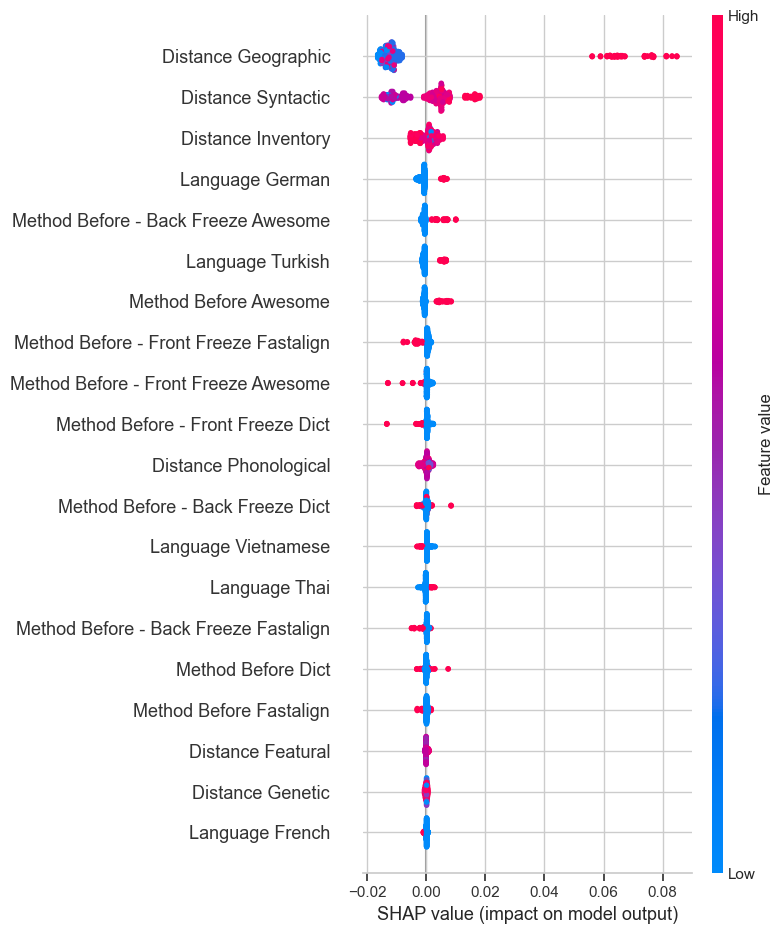

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


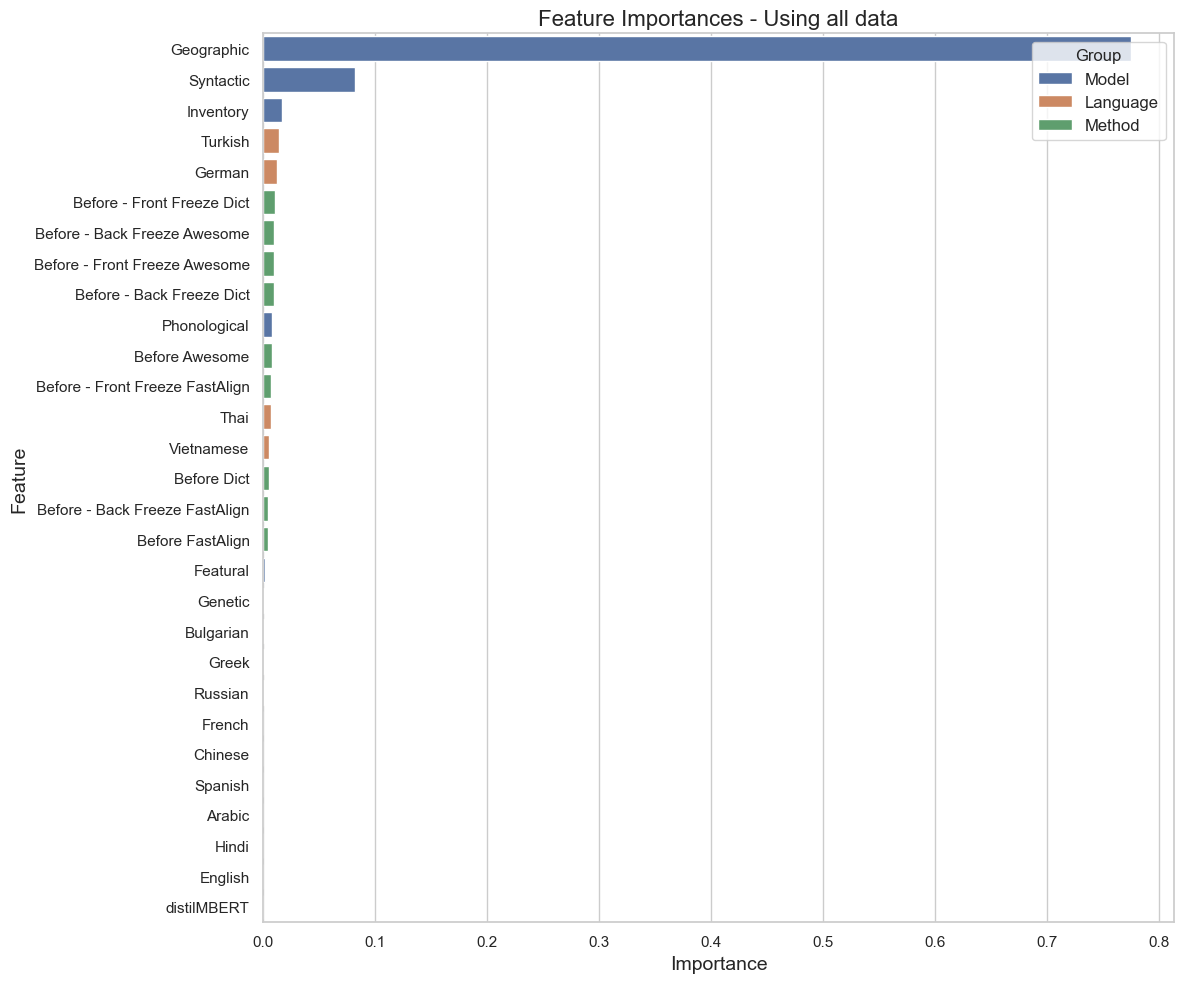

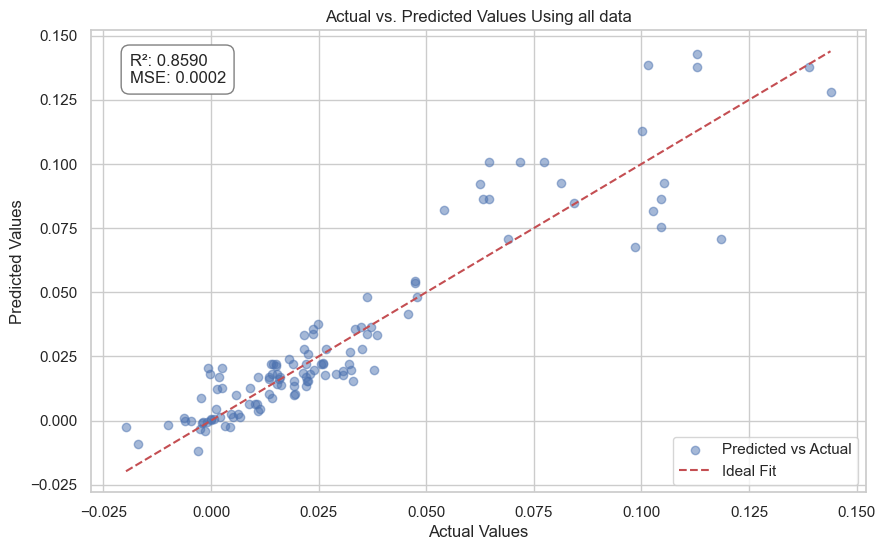

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


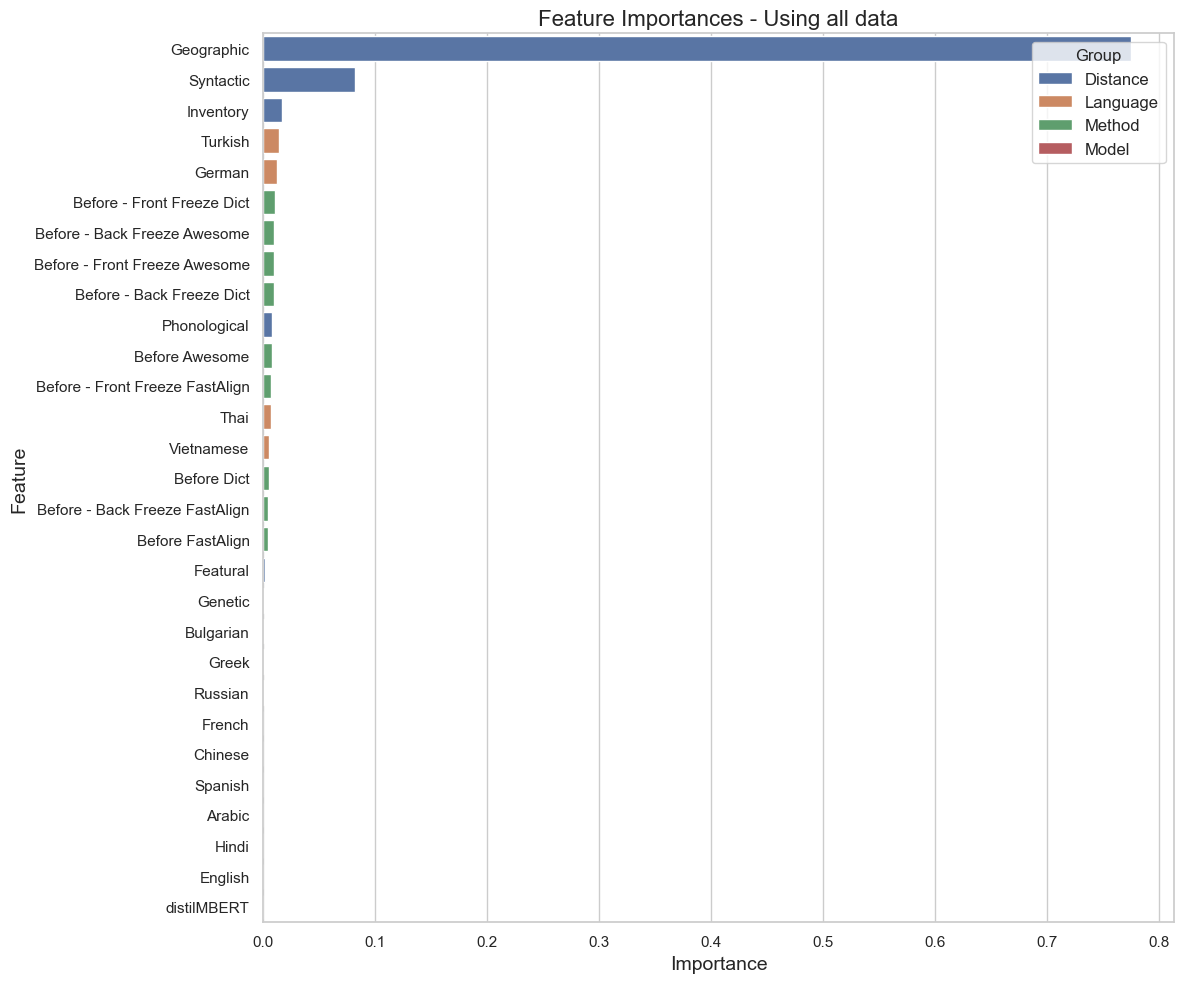

Using freeze methods only



100%|██████████| 59/59 [00:00<00:00, 404.44it/s]


Final Test MSE for Using freeze methods only (Random Forest): 0.0002300285509603544


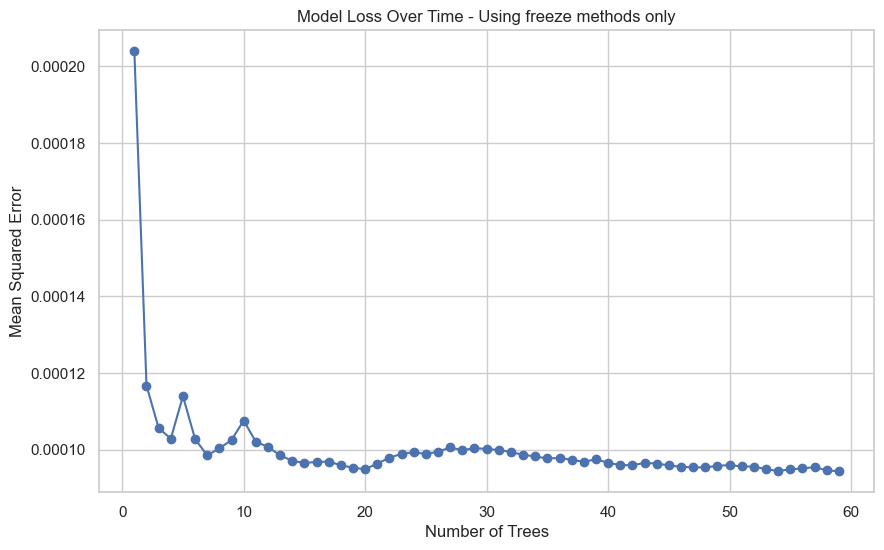

Calculating SHAP values: 100%|██████████| 272/272 [00:00<00:00, 537.54it/s]


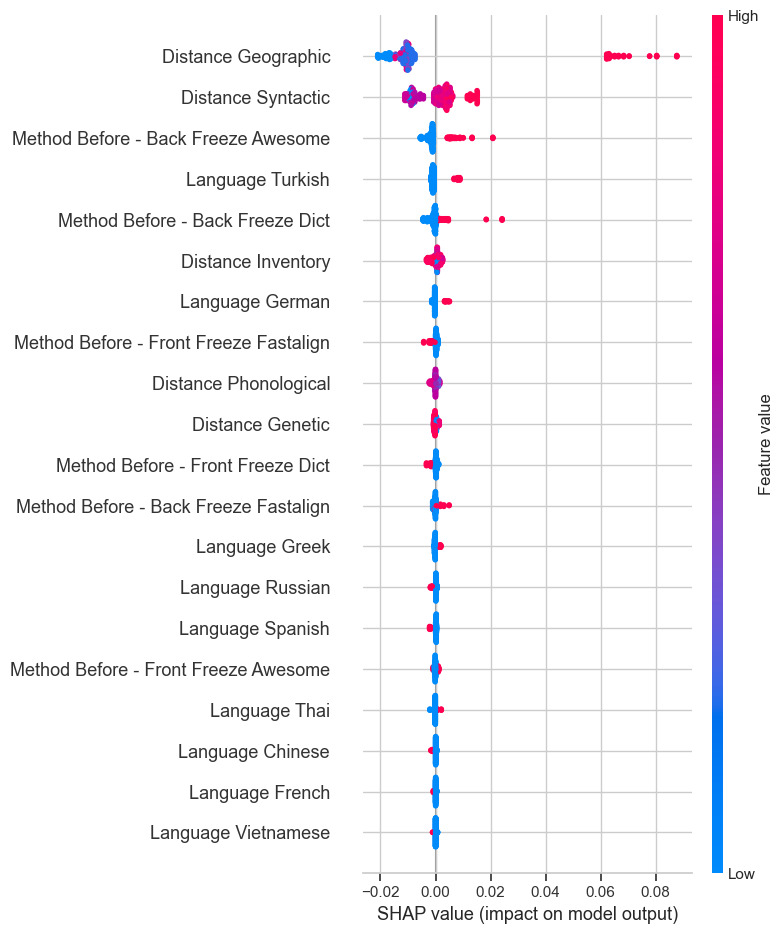

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


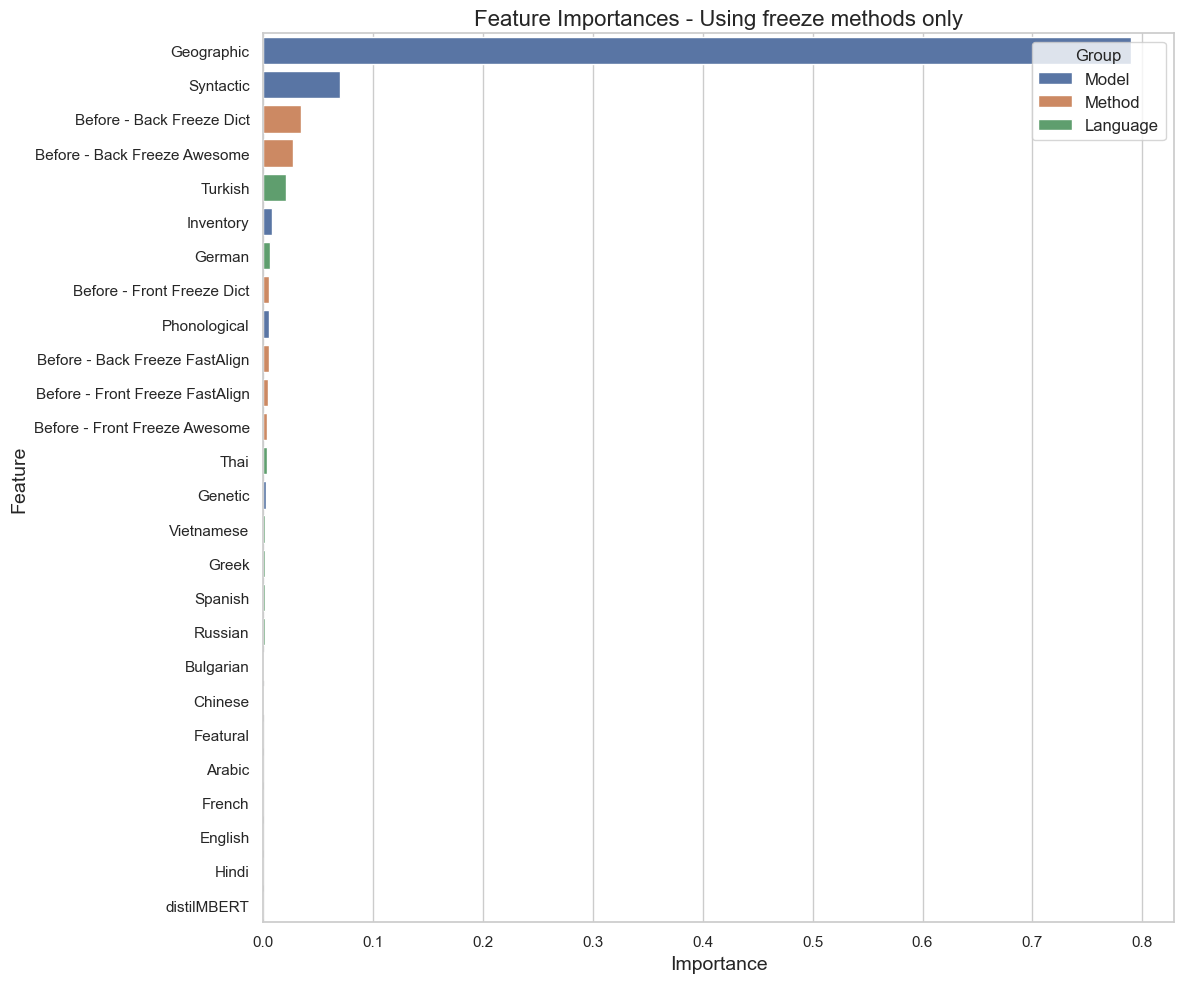

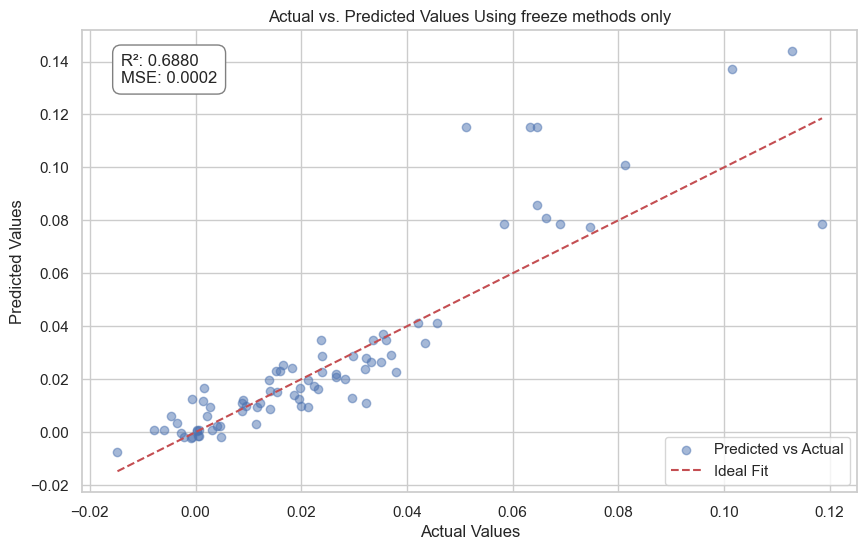

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


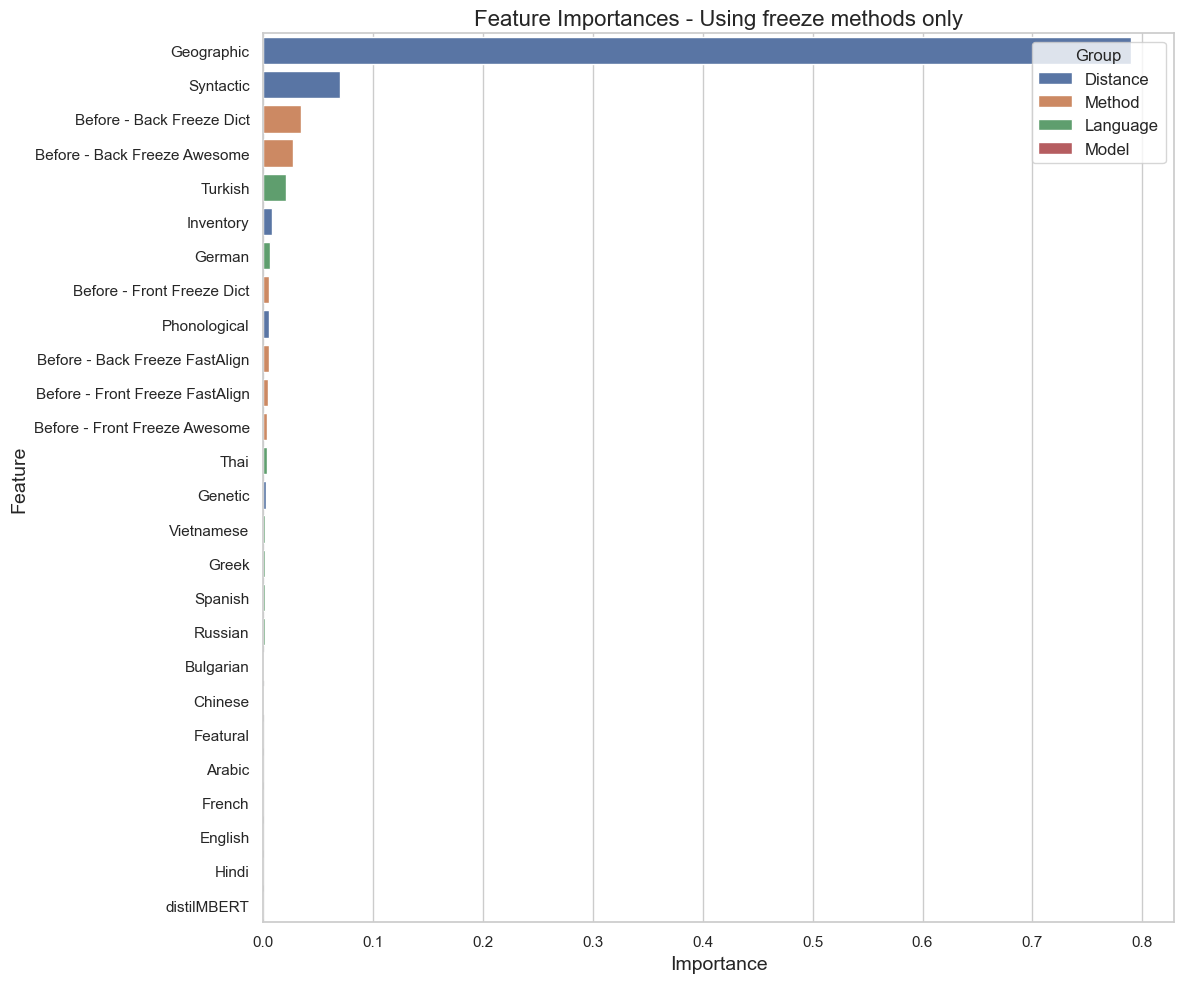

Using vanilla methods only



100%|██████████| 59/59 [00:00<00:00, 433.98it/s]


Final Test MSE for Using vanilla methods only (Random Forest): 0.00015595728465054665


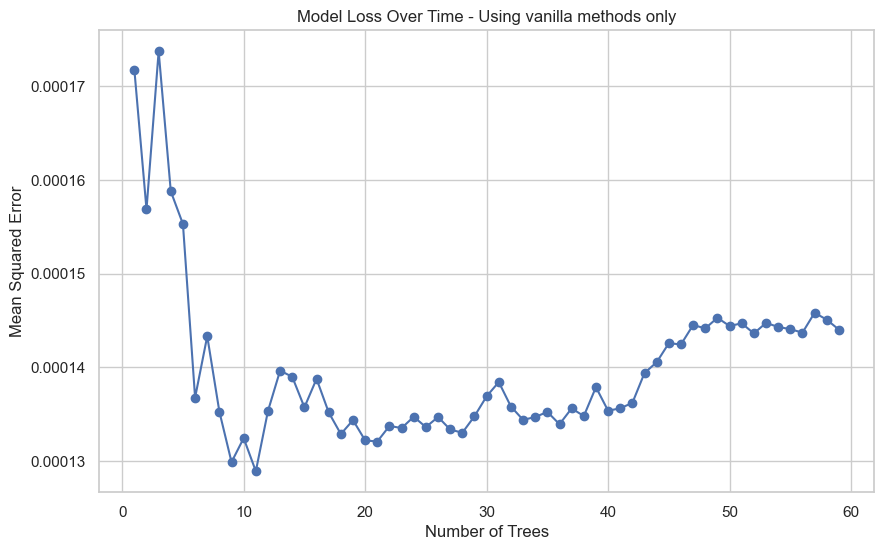

Calculating SHAP values: 100%|██████████| 136/136 [00:00<00:00, 573.10it/s]


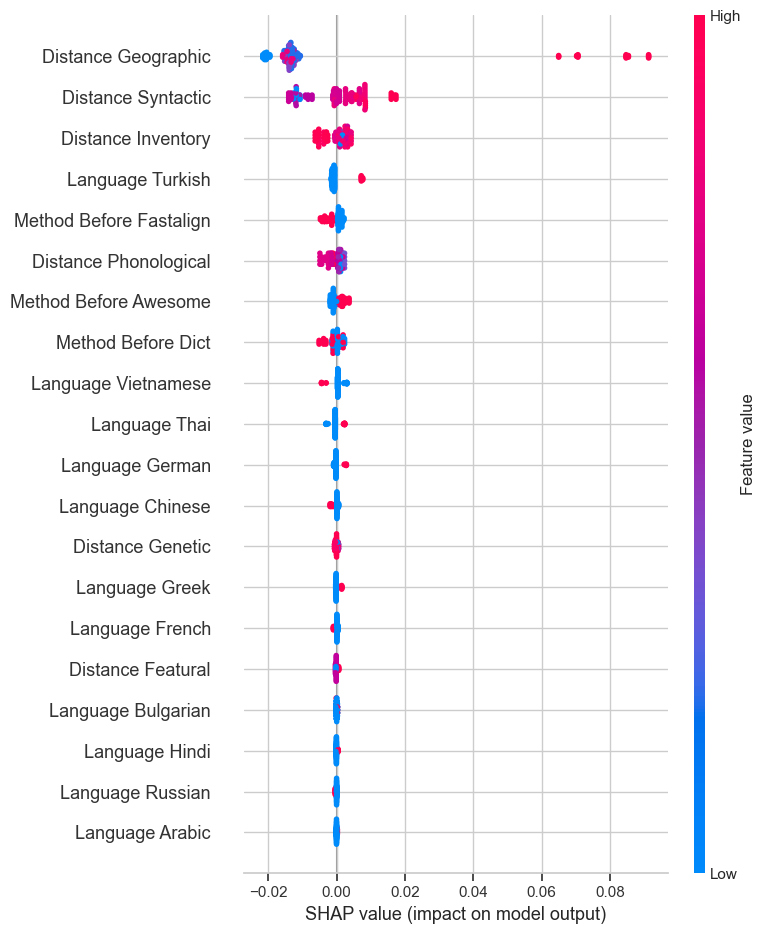

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


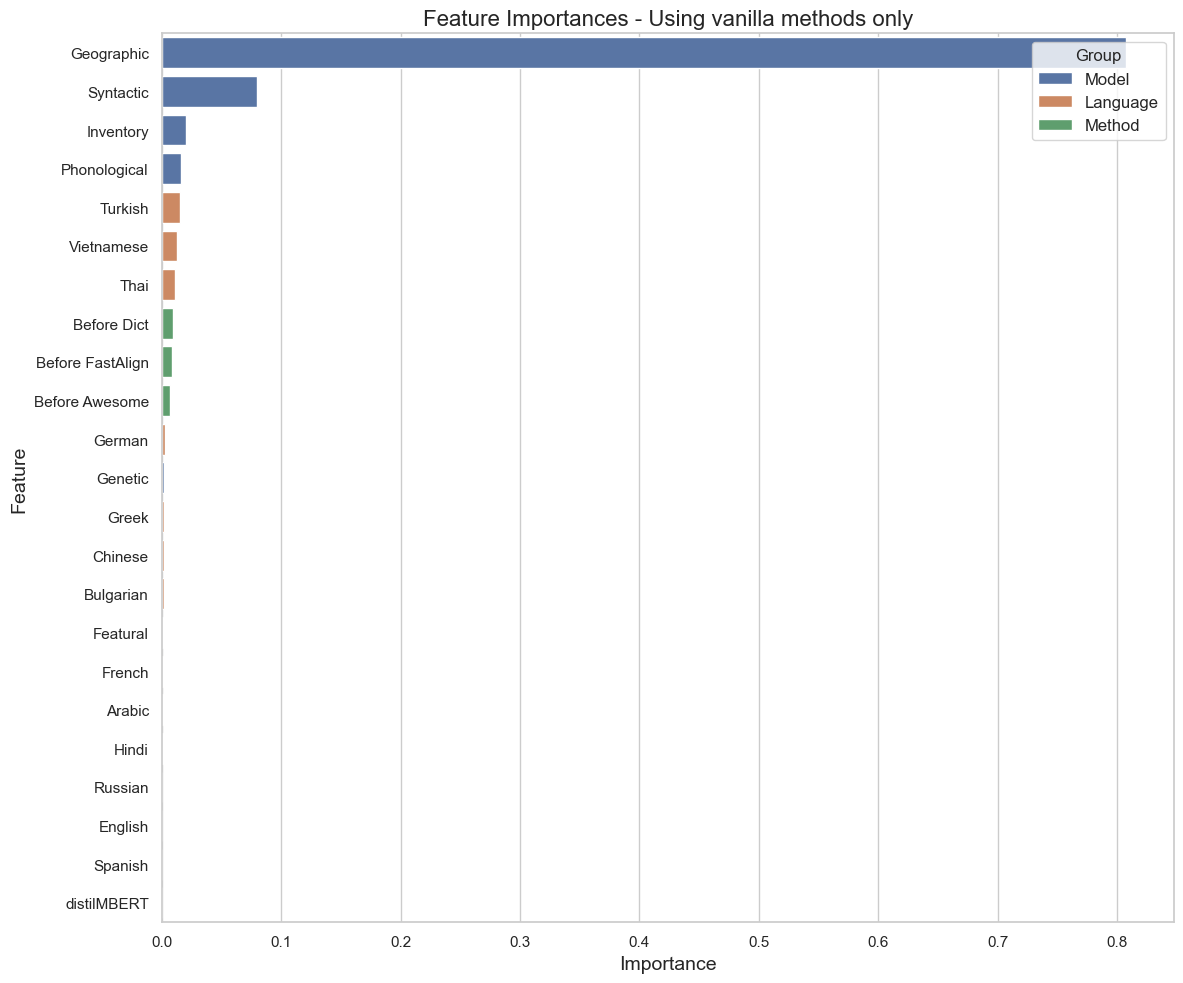

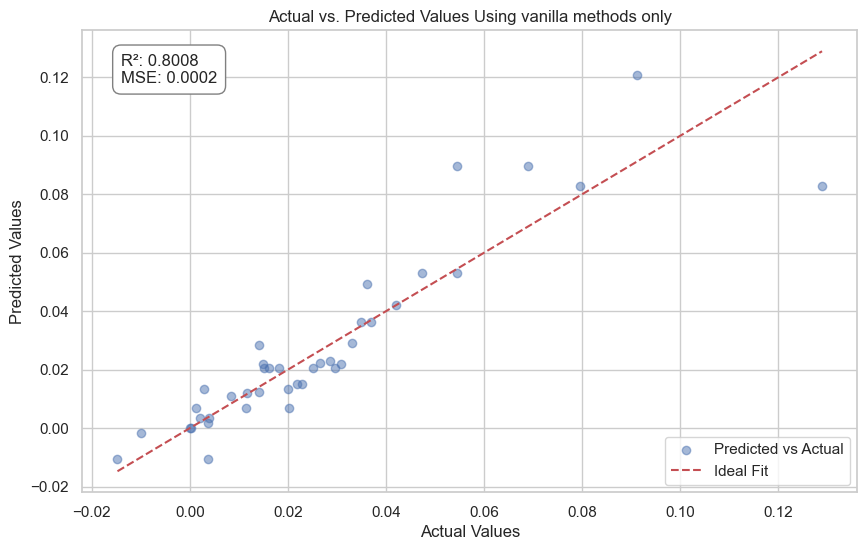

C:\Users\alith\AppData\Local\Temp\ipykernel_70544\4125446563.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


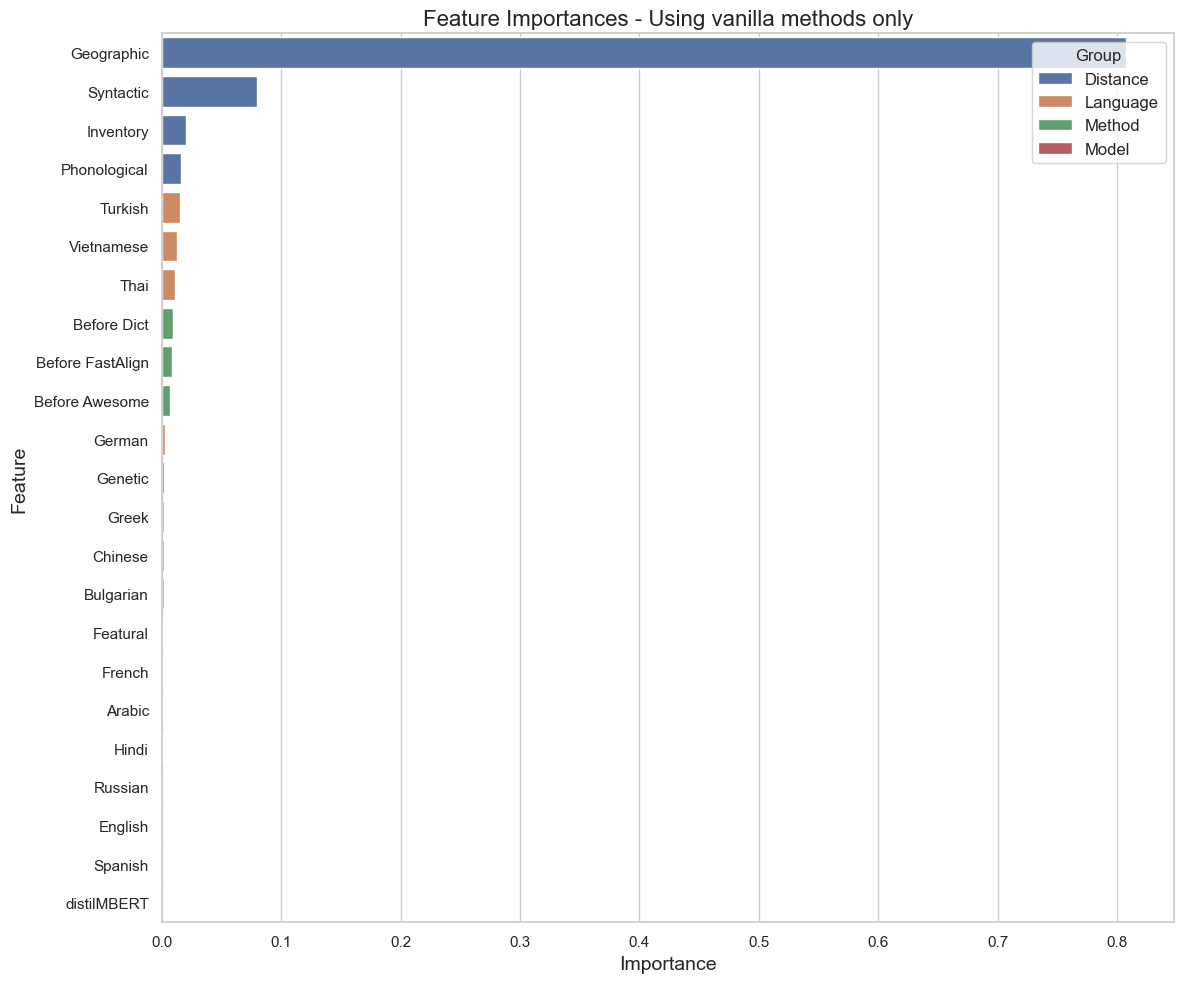

In [74]:
run_regression_and_plot(nli_df_flagged, "Using all data")

# Freeze methods only
freeze_df = nli_df_flagged[nli_df_flagged['method_type'] == 'freeze']
run_regression_and_plot(freeze_df, "Using freeze methods only")

# Vanilla methods only
vanilla_df = nli_df_flagged[nli_df_flagged['method_type'] == 'vanilla']
run_regression_and_plot(vanilla_df, "Using vanilla methods only")